<a href="https://colab.research.google.com/github/magnusbauer/AFM-CoV-2/blob/main/AFM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load dataset from figshare** 




In [ ]:
!wget --no-check-certificate \
    "https://ndownloader.figshare.com/articles/15062373?private_link=eab67c67f835687df3cd" \
    -O "/tmp/example.zip"

--2021-08-02 17:33:59--  https://ndownloader.figshare.com/articles/15062373?private_link=eab67c67f835687df3cd
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.217.124.219, 52.16.102.173, 2a05:d018:1f4:d003:1c8b:1823:acce:812, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.217.124.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662114402 (631M) [application/zip]
Saving to: ‘/tmp/example.zip’

/tmp/example.zip    100%[===================>] 631.44M  32.7MB/s    in 20s     

2021-08-02 17:34:20 (31.1 MB/s) - ‘/tmp/example.zip’ saved [662114402/662114402]



In [ ]:
!unzip -q "/tmp/example.zip" -d "/tmp/example"

replace /tmp/example/fca.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np

import h5py
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.neighbors import KernelDensity

import math

from scipy.interpolate import splrep, sproot, splev, UnivariateSpline
from scipy import stats
from scipy.stats import norm

# import peakutils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
def heatmap( curves, shifts, bins, xyrange):
    xdata = np.empty(0)
    ydata = np.empty(0)

    for idx,i in enumerate(curves):
        data_raw = curves[i][:]
        
        dx = shifts[idx]
        
        xdata = np.append(xdata,data_raw[:,0]*1e9+dx)
        ydata = np.append(ydata,data_raw[:,2]*1e12)

    H, xedges, yedges = np.histogram2d(ydata,xdata,range=xyrange,bins=bins)
    
    return H, xedges, yedges, xdata, ydata

In [ ]:
def load_measurement(name):
  # f = h5py.File('/tmp/example/A2S1.h5', 'r') 
  A2S1_1 = h5py.File('/content/drive/MyDrive/data/PNAS_export/'+name+'.h5', 'r') 
  A2S1_1_curves = A2S1_1["raw"]
  print(A2S1_1.keys())
  if "peak_lbl" in A2S1_1.keys():
    A2S1_1_peak_lbl = A2S1_1["peak_lbl"]
    #print("# of curves: %s"%(len(A2S1_1_curves.keys())))
    A2S1_1_peak_data = A2S1_1["peak_data"]
    A2S1_1_wlc_data = A2S1_1["wlc_data"]
    A2S1_1_liva_data = A2S1_1["liva_data"]
    A2S1_1_hm = heatmap(A2S1_1_curves, A2S1_1["shift_x"][:], 90, [[-15, 100], [-15, 300]]) 
    return A2S1_1_curves, A2S1_1_hm, A2S1_1_peak_data, A2S1_1_wlc_data, A2S1_1_liva_data, A2S1_1_peak_lbl,A2S1_1["shift_x"][:]

  A2S1_1_hm = heatmap(A2S1_1_curves, A2S1_1["shift_x"][:], 90, [[-15, 100], [-15, 300]]) 
  return A2S1_1_curves, A2S1_1_hm

In [ ]:
use_livadaru = 1					# 1/0 = yes/no, PARMETERS below
b = 0.11e-9						# b 0.08, 0.1nm, Stiff element for liva FRC b = 0.08e-9  0.11e-9
bond_angle = 41.0					# or 37, 64 or 41 in deg, angle for liva

threshold_liva_trafo = 1			# if 1 Force Threshold for Liva Trafo, 
threshold_liva_force = 7.5e-12		# force below that will be set near 0 in trafo
threshold_liva_distance = 5.0e-9	# keep in mind that the curve starts at f=0, x=0
qm_corr = 1							# 1/0 = yes/no QM Correction with y values below

do_liva_fits = 0					# Fit livadaru models to each peak
liva_fits_method = "regime_no" 		# method for liva fits, choose from:
									# simple: fit each regime according to max force of stretcg
									# regime_no: fit regime by number of datapoints 
									# optimize_retrafo: globally optimize with QM_corr (slow)
									# if undeclared defaults to "regime_no"

threshold_liva_fit_force_min = 10.0e-12  # Only forces higher /lower than this value will 
threshold_liva_fit_force_max = -1.0	# be considered in the liva fits 
  									# set these to -1.0 to deactivate the limit

liva_fit_enforce_zero_intersect = 0	# 1/0 = yes/no enforce fit to intersect 0
liva_fit_zero_enforce_weight = 50.0	# weight of zero intersect in liva fit, enforced
liva_fits_hf_correction = 1.0		# DOES NOT WORK YET, LEAVE AT 1.0 Offset factor for 
									# highest force regime for fit e.g. 1.1 incr.
    
temp = 300.0						# in Kelvin

In [ ]:
def liva_transformation_order(fthres_x,liva_force, liva_low, liva_high, a,  b, l, liva_c,kT=414.2e-23):
  # Livadaru Modell aufgeteilt nach Kraftbereich

  Fb = np.absolute(liva_force*b)/(kT)
  liva_final = np.zeros( Fb.shape[0] )

  p1 = np.where(liva_low>Fb)[0]
  liva_final[p1] = (fthres_x[p1]*3.0*kT)/(liva_force[p1]*a)

  p2 = np.where(np.logical_and(liva_low <= Fb , liva_high > Fb))[0]
  liva_final[p2] = fthres_x[p2]/(1.0-(np.sqrt( kT/(np.absolute(liva_force[p2])*l*4.0) ) ))

  p3 = np.where(liva_high <= Fb)[0]
  liva_final[p3] = fthres_x[p3]/(1.0 - ( (kT)/(liva_c*liva_force[p3]*b) ) )

  return liva_final

In [ ]:
def liva_low(b,y):
	y = abs(y/180.0)*np.pi
	liva_low = np.absolute((np.absolute(np.log(np.cos(y)))/(np.cos(y/2.0) )) )
	return liva_low

In [ ]:
def liva_high(b,y):
	y = abs(y/180.0)*np.pi
	liva_high = (1.0/np.absolute((np.absolute(np.log(np.cos(y)))/(np.cos(y/2.0) )) ))
	return liva_high

In [ ]:
def make_rad(deg):
	return np.abs(deg/180.0)*np.pi

In [ ]:
def prep_liva_values(bond_angle,b, kT, liva_c):

	y = make_rad(bond_angle)

	l = b * np.cos(y/2.0)/(np.absolute(np.log(np.cos(y))))

	a = b * ( (1.0+np.cos(y)) / ( ( 1.0-np.cos(y) ) * np.cos(y/2.0)) )

	b_div_l = np.absolute((np.absolute(np.log(np.cos(y)))/(np.cos(y/2.0) )) )

	liva_low = b_div_l
	liva_high = (1.0/b_div_l)

	return a, l, b, liva_low, liva_high

In [ ]:
use_livadaru = 1					# 1/0 = yes/no, PARMETERS below
b = 0.11e-9						# b 0.08, 0.1nm, Stiff element for liva FRC b = 0.08e-9  0.11e-9
bond_angle = 41.0					# or 37, 64 or 41 in deg, angle for liva

threshold_liva_trafo = 1			# if 1 Force Threshold for Liva Trafo, 
threshold_liva_force = 7.5e-12		# force below that will be set near 0 in trafo
threshold_liva_distance = 5.0e-9	# keep in mind that the curve starts at f=0, x=0
qm_corr = 1							# 1/0 = yes/no QM Correction with y values below

do_liva_fits = 0					# Fit livadaru models to each peak
liva_fits_method = "regime_no" 		# method for liva fits, choose from:
									# simple: fit each regime according to max force of stretcg
									# regime_no: fit regime by number of datapoints 
									# optimize_retrafo: globally optimize with QM_corr (slow)
									# if undeclared defaults to "regime_no"

threshold_liva_fit_force_min = 10.0e-12  # Only forces higher /lower than this value will 
threshold_liva_fit_force_max = -1.0	# be considered in the liva fits 
  									# set these to -1.0 to deactivate the limit

liva_fit_enforce_zero_intersect = 0	# 1/0 = yes/no enforce fit to intersect 0
liva_fit_zero_enforce_weight = 50.0	# weight of zero intersect in liva fit, enforced
liva_fits_hf_correction = 1.0		# DOES NOT WORK YET, LEAVE AT 1.0 Offset factor for 
									# highest force regime for fit e.g. 1.1 incr.
    
temp = 300.0						# in Kelvin

In [ ]:
### LIVADARU TRAFO VARIABLE PREP ####################
liva_c = 2.0 # degrees of freedom for High force regime
from scipy.constants import Boltzmann as k_B
kT = k_B*temp
a, l, b, liva_low, liva_high = prep_liva_values(bond_angle, b, kT, liva_c)

In [ ]:
def kde_hg(X_, X_plot_, kde_kernel, bandwidth, rtol=1.0e-2):
	#X: sequence to be fitted, > 1 numbers, please (eg nm)
	#X_plot: resulting pdf will be plotted over this range
	#kde_kernel, bandwidth = type of kernel, smoothing parameter
	X = X_[:,np.newaxis]
	X_plot = X_plot_[:, np.newaxis]
	kde = KernelDensity(kernel=kde_kernel, bandwidth=bandwidth, rtol=rtol).fit(X)
	zzz = np.exp( kde.score_samples(X_plot) )
	#zzz = np.exp(log_dens)
	return zzz

In [ ]:
lc_increment = 0.1e-9				# Contour Length Trafo bins ... stepsize 
lc_start = 0.0e-9					# ... from
lc_cutoff = 451.0e-9				# ... to; All peaks with contour lengths larger 

kde_kernel = 'gaussian'				# use gaussian, alternative: "epanechnikov"
kde_bandwidth = 4.0					# kernel bandwidth, 'smoothness' of the pdf estim.

bins = np.arange(lc_start,lc_cutoff,lc_increment)

In [ ]:
def align_hists_sum_full_iteration( liva_qm_hists, corr, full_output , curve_id="%06d"): #, liva_qm_lcfs):
	length = len(liva_qm_hists)
	shifts = np.zeros(length)

	ini_hist = align_hists_sum_full(liva_qm_hists,  corr, curve_id)

	N = ini_hist.shape[0]
	hist_corr = np.zeros(N)

	for idx,i in enumerate(liva_qm_hists):
		bb = np.zeros(N)
		bb[(N*3)//8:-N//8] += i

		corr_matrix = np.correlate(ini_hist,bb,"full")
		#print corr_matrix
		shift = int(np.argmax(corr_matrix) - N)
		bb = np.roll(bb,shift)
		shifts[idx] = float(shift)
		#weight with shift? =
		hist_corr += bb
		#lcf_corr =
	if full_output == 0: # if we do not want to plot
		return hist_corr/float(length) # divide to average
	elif full_output == 1 :
		return shifts, hist_corr/float(length)

In [ ]:
def align_hists_sum_full(liva_qm_hists, corr, curve_id="%06d"): #, liva_qm_lcfs):
	N = 0

	for idx,i in enumerate(liva_qm_hists):
# 		print idx
		#weigh with max autocorr value
		if idx == 0:
			bb = liva_qm_hists[0]
# 			print "bb",bb
			N = bb.size*2
# 			print "N",N
			aa = np.zeros(N)
# 			aa[-N//8]=1
# 			print -N//8
# 			print (N*3)//8
# 			aa[(N*3)//8]=1
# 			plt.plot(aa)
			aa[(N*3)//8:-N//8] += i
# 			print (N*3)//8,-N//8
# 			plt.plot(aa[(N*3)//8:-N//8])
# 			plt.plot(aa)
# 			break
			hist_corr = aa
			continue
		else:
			aa = hist_corr
			bb = np.zeros(N)
			bb[(N*3)//8:-N//8] += i

		corr_matrix = np.correlate(aa,bb,"full")
		#print corr_matrix
		shift = int(np.argmax(corr_matrix) - np.shape(aa)[0])
		bb = np.roll(bb,shift)
		#hist_corr[] =
		hist_corr = (aa + bb) / 2.0
# 		print hist_corr.shape
		#lcf_corr =
	return hist_corr

In [ ]:
bins_all = np.array([  0.00000000e+00,   6.00000000e-12,   1.20000000e-11,   1.80000000e-11,
   2.40000000e-11,   3.00000000e-11,   3.60000000e-11,   4.20000000e-11,
   4.80000000e-11,   5.40000000e-11,   6.00000000e-11,   6.60000000e-11,
   7.20000000e-11,   7.80000000e-11,   8.40000000e-11,   9.00000000e-11,
   9.60000000e-11,   1.02000000e-10,   1.08000000e-10,   1.14000000e-10,
   1.20000000e-10,   1.26000000e-10,   1.32000000e-10,   1.38000000e-10,
   1.44000000e-10,   1.50000000e-10,   1.56000000e-10,   1.62000000e-10,
   1.68000000e-10,   1.74000000e-10,   1.80000000e-10,   1.86000000e-10,
   1.92000000e-10,   1.98000000e-10])

In [ ]:
def gaussian(x, A, x0, sig):
    return A*np.exp(-(x-x0)**2/(2*sig**2))

def one_gaussian(x, *pars):
    offset = pars[-1]
    g1 = gaussian(x, pars[0], pars[1], pars[2])
    return g1 + offset

def triple_gaussian(x, *pars):
    offset = pars[-1]
    g1 = gaussian(x, pars[0], pars[1], pars[2])
    g2 = gaussian(x, pars[3], pars[4], pars[5])
    g3 = gaussian(x, pars[6], pars[7], pars[8])

    return g1+g2+g3 + offset

In [ ]:
def fit_peak(curve, fit_range, model, guess, bounds):
    plt.plot(curve)

    x_data = np.arange(fit_range[0],fit_range[1])
    y_data = curve[fit_range[0]:fit_range[1]]

    popt, pcov = curve_fit(model, x_data, y_data, p0=guess, bounds=bounds)
    print (popt)

    for liness in range(1,len(guess),3):
        plt.axvline(popt[liness])

    plt.plot(x_data, y_data, '-', linewidth=4)
    plt.plot(x_data, model(x_data, *popt), 'r--', linewidth=2)

    plt.xlim(fit_range[0]-200,fit_range[1]+200)

    #plt.xlim([3500,6000])

    plt.ylim([np.min(curve[fit_range[0]:fit_range[1]])-0.00005,np.max(curve[fit_range[0]:fit_range[1]])+0.00005])
    plt.show()
    return popt,pcov

In [ ]:
def fwhm(x, y):
  ''' Return FWHM of a x/y trace. Uses a cubic spline interpolation. Required exaclty two crossovers of half maximum line '''
  class MultiplePeaks(Exception): pass
  class NoPeaksFound(Exception): pass

  half_max = max(y)/2.0
  tck = splrep(x, y - half_max)
  roots = sproot(tck)
  y2 = splev(x, tck)

  if len(roots) > 2:
        raise MultiplePeaks("The dataset appears to have multiple peaks, and thus the FWHM can't be determined.")
  elif len(roots) < 2:
        raise NoPeaksFound("No proper peaks were found in the data set; likely the dataset is flat (e.g. all zeros).")
  else:
    #return abs(roots[1] - roots[0]), half_max
        return [roots[0], roots[1]], half_max, x[np.argmax(y)]

In [ ]:
def fit_be_deltax_koff( curr_lr, x, kT, binwidth, guesses, max_ ):
	
	fdot=curr_avg_loadrate = np.mean(curr_lr)
	curr_std_loadrate = np.std(curr_lr)
	if max_ == -1.0: # set maximum automatically
		max_ = np.max(x) + binwidth
	else: # max_ was set by hand, take this value
		pass

	bins = np.arange(0.0, max_, binwidth)
	bins__ = np.arange(0.0, max_+binwidth, binwidth/80.0)


	# histogram, ensure that first value is 0
	# hi_pr = np.zeros(bins.shape[0])
	hi_pr, hi_bins = np.histogram(x, bins=bins, density=True)

	if np.sum(bins-hi_bins) != 0 :
		print ("bin error !")
		return None

	#correct bins by half the binwidth
	bins_fit = hi_bins[1:] - (binwidth/2.0)

	xdata = bins_fit # center corrected bins
	ydata = hi_pr    # prob. for this bin center position


	fit_precision = 1.5e-8

	# fit the distribution
	params , pcov = curve_fit(lambda F, deltax, koff0: bell_evans_p_of_F(F, deltax, koff0, fdot, kT) , 
		xdata,ydata, guesses, ftol=fit_precision, xtol=fit_precision)

	bell_ = bell_evans_p_of_F(bins__, params[0], params[1] , fdot, kT)
	fiterr = np.sqrt(np.diag(pcov))

	deltax = params[0]
	deltax_fiterr = fiterr[0] 
	koff = params[1] 
	koff_fiterr = fiterr[1]

	# get most probable rupture force and the asymmetric fwhm error
	most_probable_force = bell_evans(fdot, deltax, koff, kT)
	
	fwhm_bins = bins__[ np.where( bell_ >= 0.5*np.max(bell_) )[0] ]
	
	try:
		f_error_neg = most_probable_force - fwhm_bins[0]
		f_error_pos = fwhm_bins[-1] - most_probable_force
	except IndexError:
		print ("FWHM errors fail - non converging fit?")
		f_error_neg = -1.0
		f_error_pos = -1.0

	return most_probable_force, f_error_neg, f_error_pos, deltax, deltax_fiterr, koff, koff_fiterr, bins, xdata,ydata, bins__, bell_


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Blue = '#2CBDFE'
Green = '#47DBCD'
Pink = '#F3A0F2'
Purple = '#9D2EC5'
Violet = '#661D98'
Amber = '#F5B14C'
Clfa = '#E84E1B'
S2green="#A1CC36"
S2greenalt="#12934B"
S1blue="#29378D"

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet,CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [ ]:
def iterate_peaks(nb_meas,peaks,prop):
  if   prop == "f" :
    b = 2
  elif prop == "f_raw" :
    b = 1
  elif prop == "f_drop" :
    b = 3
  elif prop == "dp" :
    b = 4
  elif prop == "lr" :
    b = 5
  elif prop == "lc" :
    b = 6
  elif prop == "x" :
    b = 0
  elif prop == "wlc_lc_fit":
    b = 1
    curve_id += "wlc"
  elif prop == "wlc_lp_fit":
    b = 0
    curve_id += "wlc"

  curves=nb_meas[0]
  peak_lbl=nb_meas[5]
  peak_data=nb_meas[2]
  for i,peak in enumerate(peaks):

      ydata = np.empty(0)
      for idx, curve in enumerate(curves):
          # print(curve)
          # print(peak_lbl[curve][:])
          if np.where(peak_lbl[curve][:]==peak)[0].size == 0:
              continue
          ydata = np.append(ydata,peak_data[curve][:][np.where(peak_lbl[curve][:]==peak)[0][0]][b])
  return ydata

In [ ]:
!pip install peakutils

In [ ]:
import peakutils
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
A2S1_1 = load_measurement('A2S1_1')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


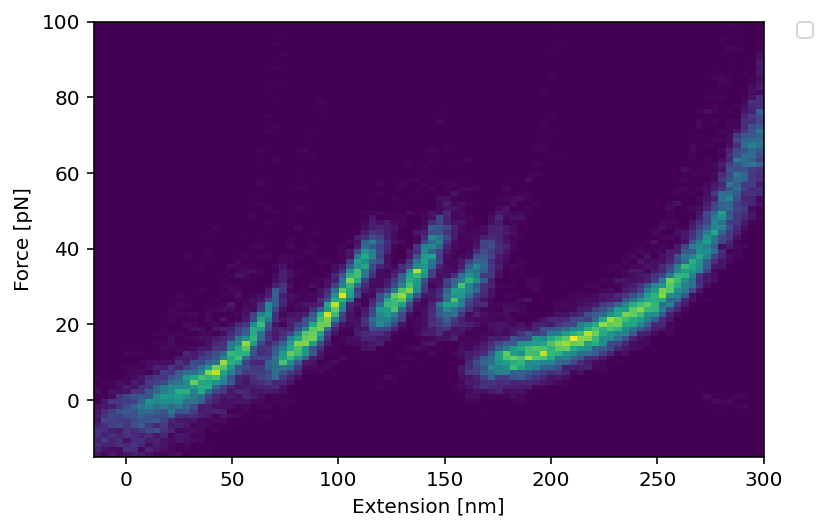

In [ ]:
plt.pcolormesh(A2S1_1[1][2],A2S1_1[1][1],A2S1_1[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
A2S1_2 = load_measurement('A2S1_2')

<KeysViewHDF5 ['raw', 'shift_x']>


No handles with labels found to put in legend.


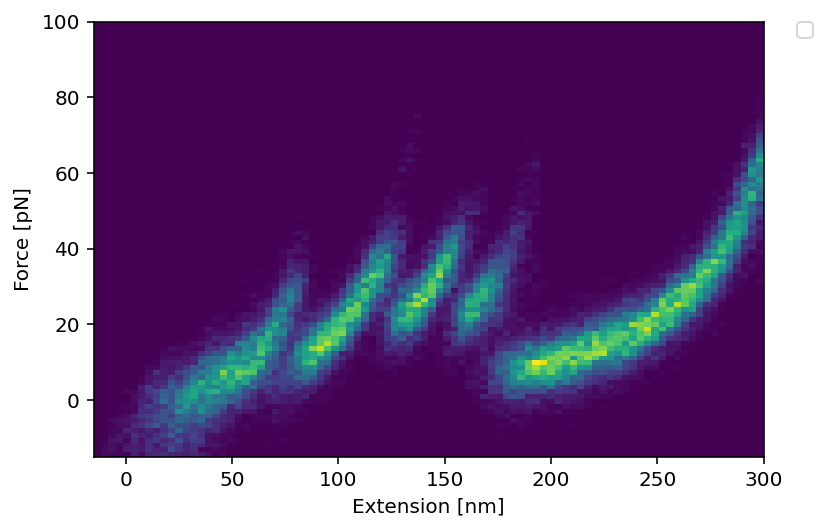

In [ ]:
plt.pcolormesh(A2S1_2[1][2],A2S1_2[1][1],A2S1_2[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
livas32=[]

for i in A2S1_2[0]:
  print(i)
  fthres=A2S1_2[0][i][:]
  liva_fthres = fthres

  liva = liva_transformation_order(liva_fthres[:,0],liva_fthres[:,1],
  liva_low, liva_high, a, b, l, liva_c, kT)
  
  liva_pdf = kde_hg(liva*1e9,bins*1e9,kde_kernel,kde_bandwidth)
  livas32.append(liva_pdf)

for i in A2S1_1[0]:
  print(i)
  fthres=A2S1_1[0][i][:]
  liva_fthres = fthres

  liva = liva_transformation_order(liva_fthres[:,0],liva_fthres[:,1],
  liva_low, liva_high, a, b, l, liva_c, kT)
  
  liva_pdf = kde_hg(liva*1e9,bins*1e9,kde_kernel,kde_bandwidth)
  livas32.append(liva_pdf)

002827
008527
010778
012712
014866
018359
025861
027151
027454
033787
035864
037681
038301
040058
045108
045349
053567
058587
059086
060935
063887
070124
083974
104578
109506
112465
118803
120564
120704
121940
123569
134677
134922
136094
137375
146326
156510
159247
173091
178827
191804
195850
203216
213400
217710
002911
003905
004120
004331
004541
006907
008251
008357
008397
008728
009975
010199
010380
012229
014488
015629
015807
015987
017050
020543
020918
022859
025013
027308
027423
028818
030393
032956
033957
034247
036701
037008
037367
041822
045858
049026
049269
049987
050220
054088
056032
056267
057143
057217
058981
059055
059651
060250
063752
068726
070006
075024
076463
078083
078662
081267
084294
084638
086397
087328
087468
089406
090386
090591
090805
090911
096631
096832
098103
098443
099083
101277
103777
108950
110152
111616
115692
116987
117346
118946
119728
120524
126215
126312
131066
132187
134690
134996
135310
141471
146020
149022
167568
169725
172088
173552
183653
184292

In [ ]:
len(livas32)

210

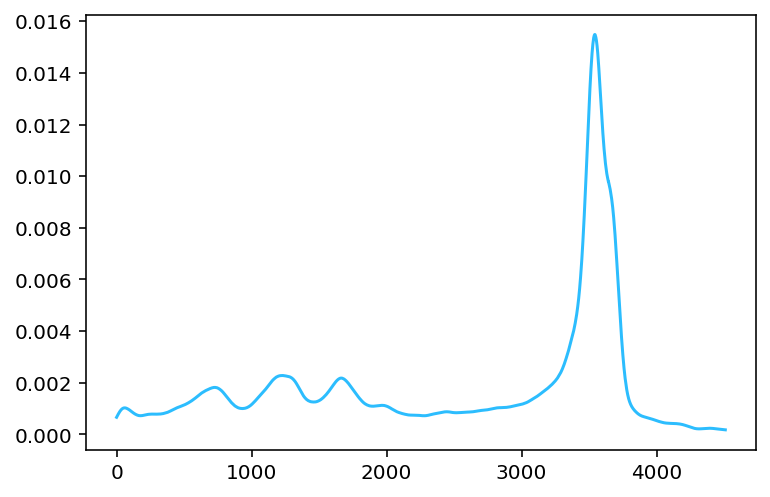

In [ ]:
plt.plot(livas32[1])

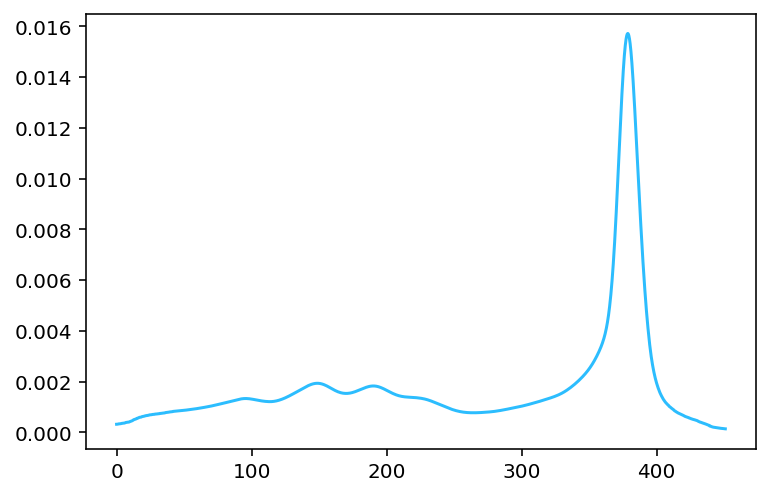

In [ ]:
alignhist33=align_hists_sum_full_iteration(livas32,1,1)
plt.plot(np.arange(0,451,0.1),alignhist33[1][3382+int(np.mean(alignhist33[0])):3382+int(np.mean(alignhist33[0]))+4510])

[ 2.22980781e-04  4.44085986e+03 -9.38560174e+01  1.11080171e-03]


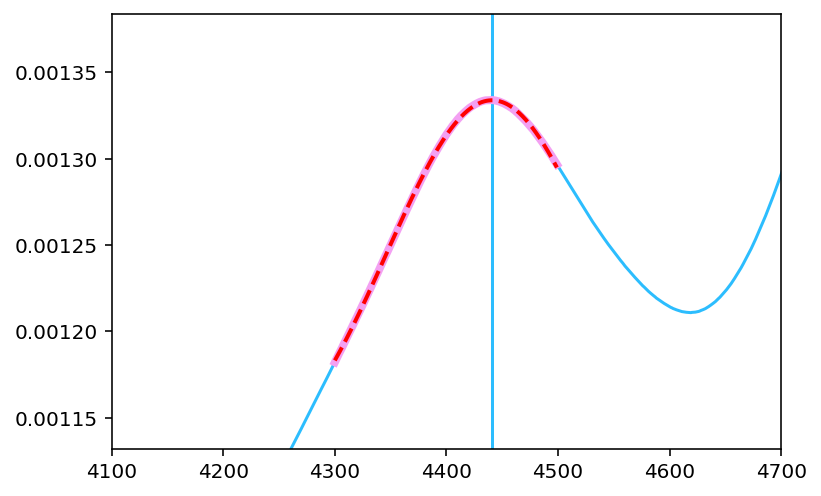

In [ ]:
popt33_1,pcov33_1=fit_peak(alignhist33[1],[4300,4500],one_gaussian,[1, 4450, 1,1],([-10,4000,-200,-1],[10,6000,200,1]))

[1.18231185e-03 4.95907099e+03 1.71010572e+02 9.77973880e-04
 5.38233067e+03 1.28303841e+02 5.90440699e-04 5.71929502e+03
 1.57057142e+02 7.37523673e-04]


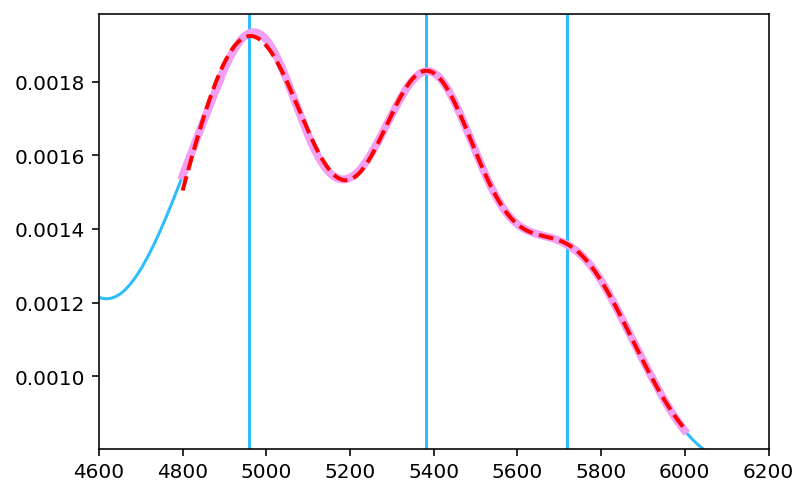

In [ ]:
popt33_t,pcov33_t=fit_peak(alignhist33[1],[4800,6000],triple_gaussian,[1, 5180, 140,1, 5400, 100,1, 5800, 100,0],([-10,4000,-200,-10,4000,-200,-10,4000,-200,-1],[1000,6000,2000,1000,6000,2000,1000,6000,2000,1]))

[ 6.09869981e-04  4.96941761e+03 -1.15555643e+02  1.32474020e-03]


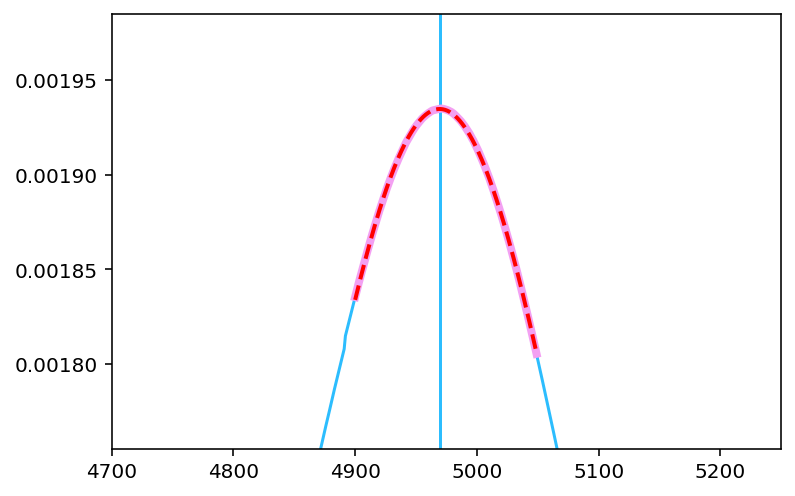

In [ ]:
popt33_2,pcov33_2=fit_peak(alignhist33[1],[4900,5050],one_gaussian,[1, 4950, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

[6.03300190e-04 5.38459483e+03 1.19090667e+02 1.22569559e-03]


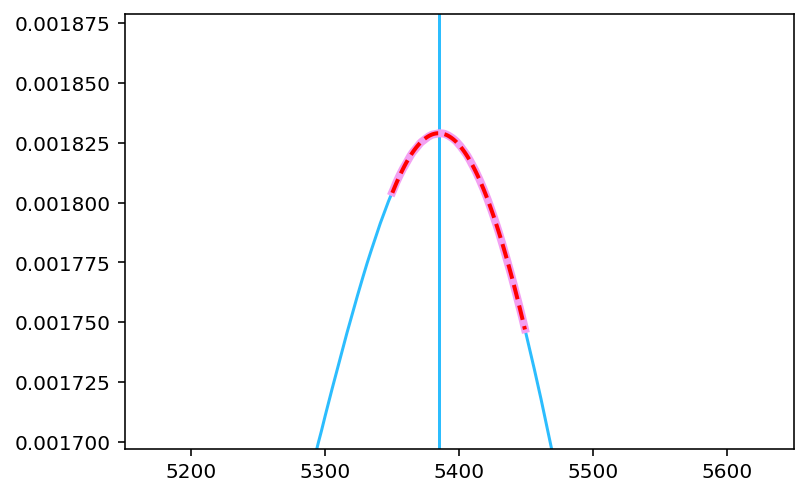

In [ ]:
popt33_3,pcov33_3=fit_peak(alignhist33[1],[5350,5450],one_gaussian,[1, 5390, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

[ 8.87265580e-03  7.26966626e+03 -5.68148557e+01  6.84923036e-03]


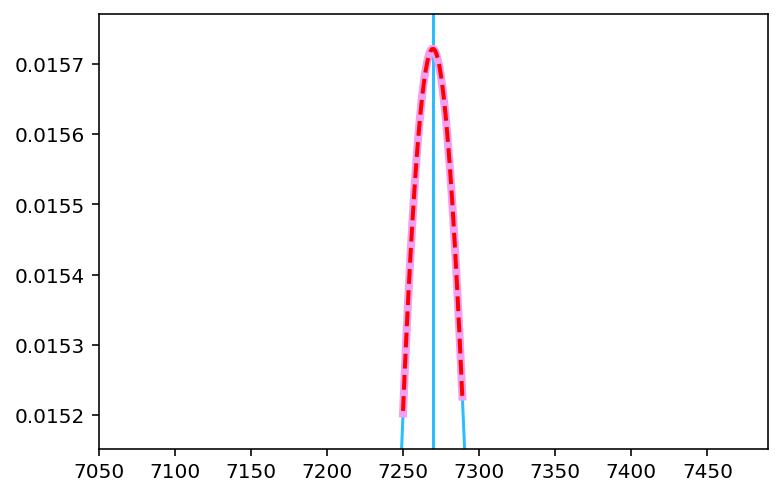

In [ ]:
popt33_5,pcov33_5=fit_peak(alignhist33[1],[7250,7290],one_gaussian,[1, 7280, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

In [ ]:
A2S1_long_1 = load_measurement('A2S1_long_1')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


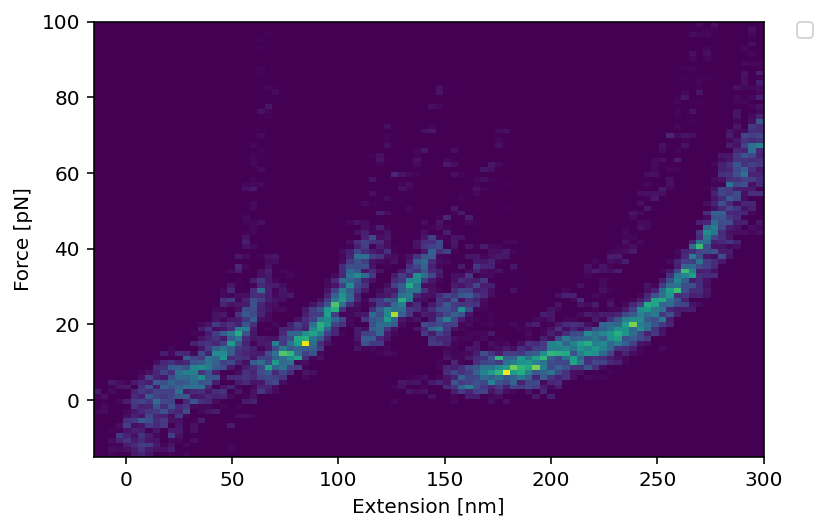

In [ ]:
plt.pcolormesh(A2S1_long_1[1][2],A2S1_long_1[1][1],A2S1_long_1[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
A2S1_long_1[0]

<HDF5 group "/raw" (31 members)>

2.7537366993550513e-11

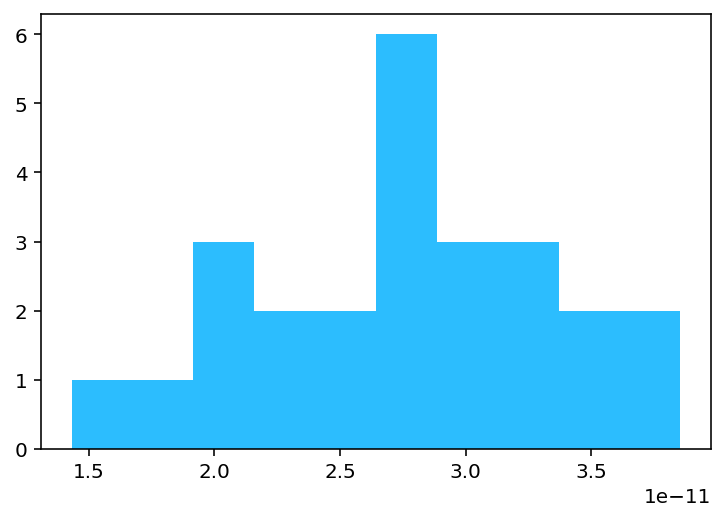

In [ ]:
x=A2S1_long_1
peak_it=[b'RBD']
lcs=iterate_peaks(x,peak_it,"f")
plt.hist(lcs[lcs>0])
np.mean(lcs[lcs>0])

In [ ]:
A2S1_long_2 = load_measurement('A2S1_long_2')

<KeysViewHDF5 ['raw', 'shift_x']>


No handles with labels found to put in legend.


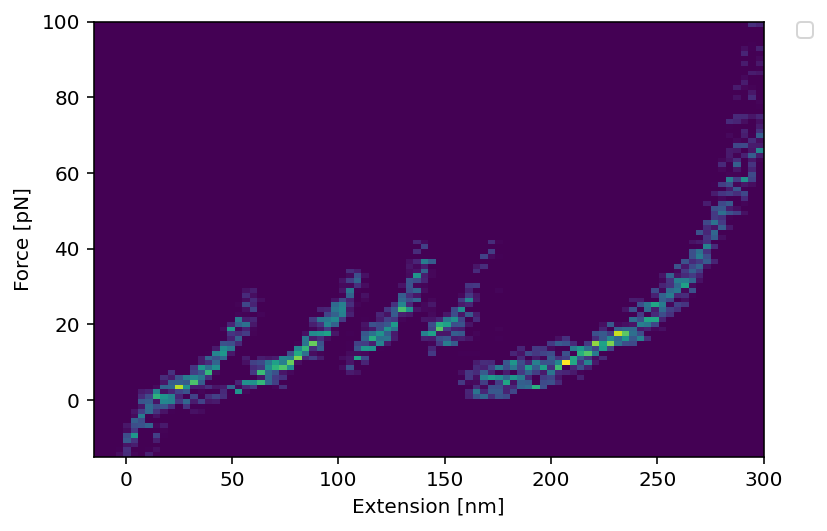

In [ ]:
plt.pcolormesh(A2S1_long_2[1][2],A2S1_long_2[1][1],A2S1_long_2[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
A2S1_long_3 = load_measurement('A2S1_long_3')

<KeysViewHDF5 ['raw', 'shift_x']>


In [ ]:
A2S1_long_4 = load_measurement('A2S1_long_4')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


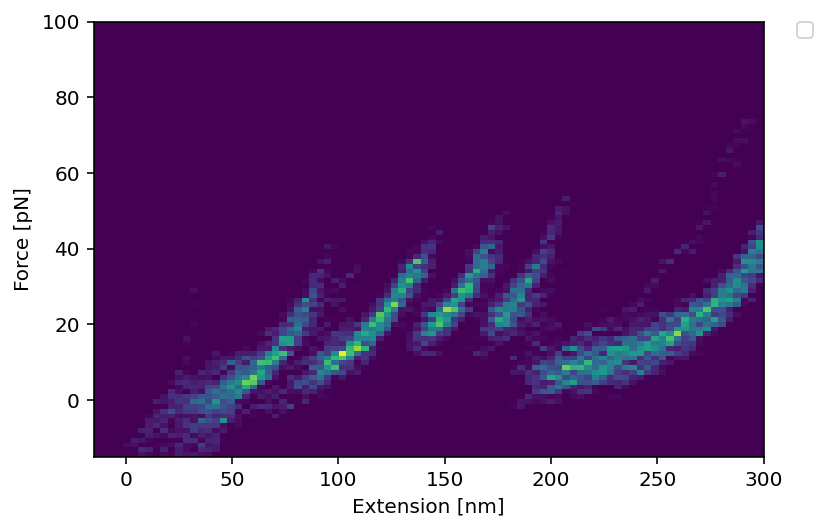

In [ ]:
plt.pcolormesh(A2S1_long_4[1][2],A2S1_long_4[1][1],A2S1_long_4[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
A2S1_long_4[0]

<HDF5 group "/raw" (29 members)>

3.7740208043605204e-07

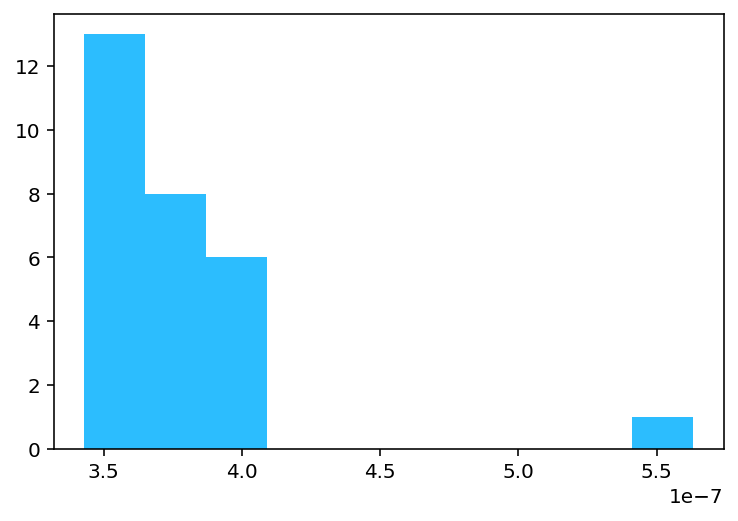

In [ ]:
x=A2S1_long_4
peak_it=[b'ClfA']
lcs=iterate_peaks(x,peak_it,"lc")
plt.hist(lcs[lcs>0])
np.mean(lcs[lcs>0])

3.708828152873589e-07

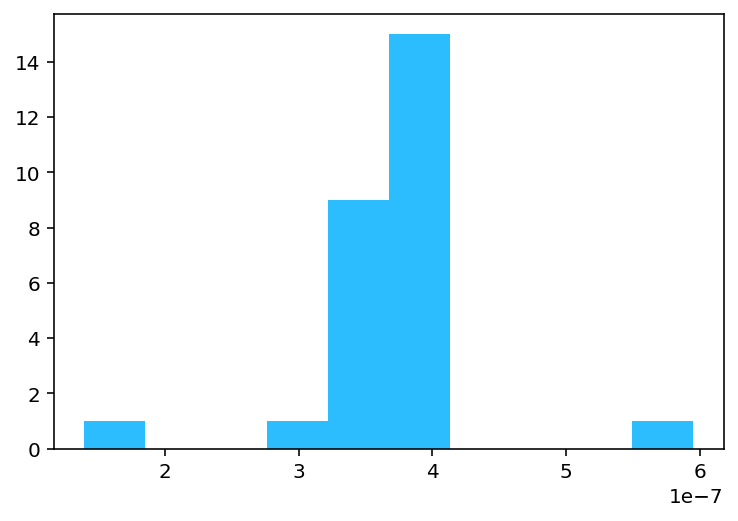

In [ ]:
x=A2S1_long_1
peak_it=[b'ClfA']
lcs=iterate_peaks(x,peak_it,"lc")
plt.hist(lcs[lcs>0])
np.mean(lcs[lcs>0])

1.5881481481481483e-07

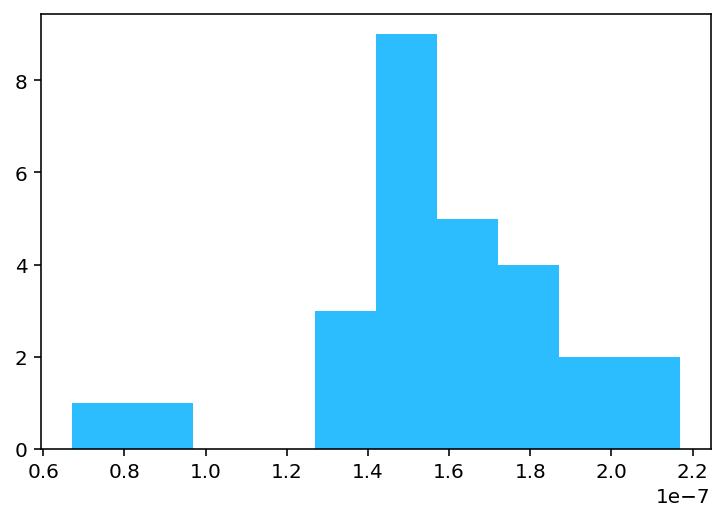

In [ ]:
x=A2S1_long_4
peak_it=[b'ACE2_1']
lcs=iterate_peaks(x,peak_it,"lc")
plt.hist(lcs[lcs>0])
np.mean(lcs[lcs>0])

1.5775000000000002e-07

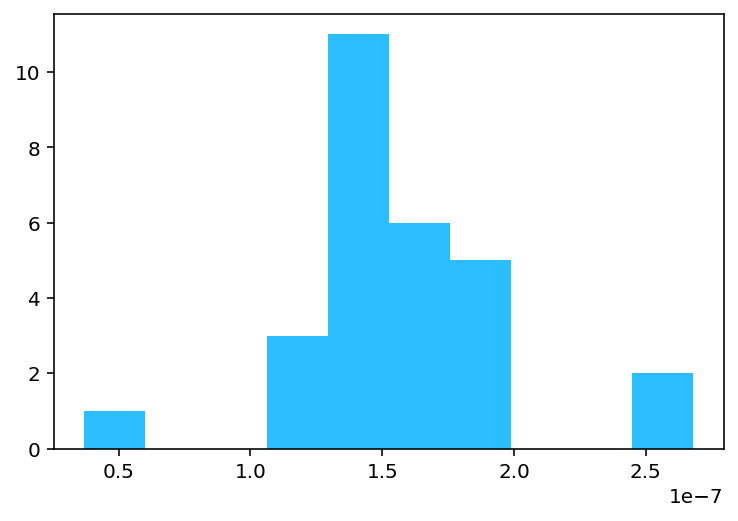

In [ ]:
x=A2S1_long_1
peak_it=[b'ACE2_1']
lcs=iterate_peaks(x,peak_it,"lc")
plt.hist(lcs[lcs>0])
np.mean(lcs[lcs>0])

In [ ]:
type(A2S1_long_1[0])

h5py._hl.group.Group

In [ ]:
A2S1_1_hm = heatmap(A2S1_1_curves, A2S1_1["shift_x"][:], 90, [[-15, 100], [-15, 300]]) 

No handles with labels found to put in legend.


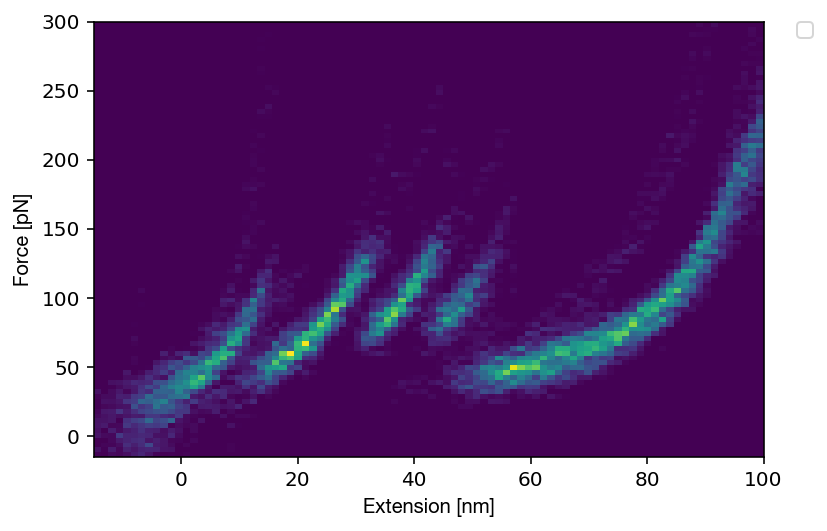

In [ ]:
bins=90 
xyrange=[[-15, 100], [-15, 300]]

xdata = np.empty(0)
ydata = np.empty(0)

for idx,i in enumerate(A2S1_long_1[0]):
    data_raw = A2S1_long_1[0][i][:]
    
    dx = A2S1_long_1[6][idx]
    
    xdata = np.append(xdata,data_raw[:,0]*1e9+dx)
    ydata = np.append(ydata,data_raw[:,2]*1e12)
    # plt.plot(xdata,ydata)
    # break

for idx,i in enumerate(A2S1_long_4[0]):
    data_raw = A2S1_long_4[0][i][:]
    
    dx = A2S1_long_4[6][idx]-25
    
    xdata = np.append(xdata,data_raw[:,0]*1e9+dx)
    ydata = np.append(ydata,data_raw[:,2]*1e12)
    # plt.plot(xdata,ydata)
    # break

# plt.ylim([0,60])
# plt.xlim([0,200])
H, xedges, yedges = np.histogram2d(ydata,xdata,range=xyrange,bins=bins)

plt.pcolormesh(xedges,yedges,H, zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
livas42=[]

for i in A2S1_long_1[0]:
  print(i)
  fthres=A2S1_long_1[0][i][:]
  liva_fthres = fthres

  liva = liva_transformation_order(liva_fthres[:,0],liva_fthres[:,1],
  liva_low, liva_high, a, b, l, liva_c, kT)
  
  liva_pdf = kde_hg(liva*1e9,bins*1e9,kde_kernel,kde_bandwidth)
  livas42.append(liva_pdf)

for i in A2S1_long_2[0]:
  print(i)
  fthres=A2S1_long_2[0][i][:]
  liva_fthres = fthres

  liva = liva_transformation_order(liva_fthres[:,0],liva_fthres[:,1],
  liva_low, liva_high, a, b, l, liva_c, kT)
  
  liva_pdf = kde_hg(liva*1e9,bins*1e9,kde_kernel,kde_bandwidth)
  livas42.append(liva_pdf)

for i in A2S1_long_3[0]:
  print(i)
  fthres=A2S1_long_3[0][i][:]
  liva_fthres = fthres

  liva = liva_transformation_order(liva_fthres[:,0],liva_fthres[:,1],
  liva_low, liva_high, a, b, l, liva_c, kT)
  
  liva_pdf = kde_hg(liva*1e9,bins*1e9,kde_kernel,kde_bandwidth)
  livas42.append(liva_pdf)

for i in A2S1_long_4[0]:
  print(i)
  fthres=A2S1_long_4[0][i][:]
  liva_fthres = fthres

  liva = liva_transformation_order(liva_fthres[:,0],liva_fthres[:,1],
  liva_low, liva_high, a, b, l, liva_c, kT)
  
  liva_pdf = kde_hg(liva*1e9,bins*1e9,kde_kernel,kde_bandwidth)
  livas42.append(liva_pdf)

000527
001300
004441
004683
009293
009839
012061
013679
013850
016312
017854
030776
034764
037846
038381
042354
042911
043243
053981
055841
055968
060618
061026
064240
065834
071955
079366
080048
106839
108471
110793
003615
007385
017985
018646
018875
037340
000572
011871
015697
001474
006421
008641
017963
021132
021215
021701
022458
024255
025645
025893
026721
028206
039731
039873
048960
049961
058012
062176
066498
086880
089090
094166
095366
099942
139316
139538
150026
160091


In [ ]:
len(livas42)

69

In [ ]:
alignhist42=align_hists_sum_full_iteration(livas42,1,1)

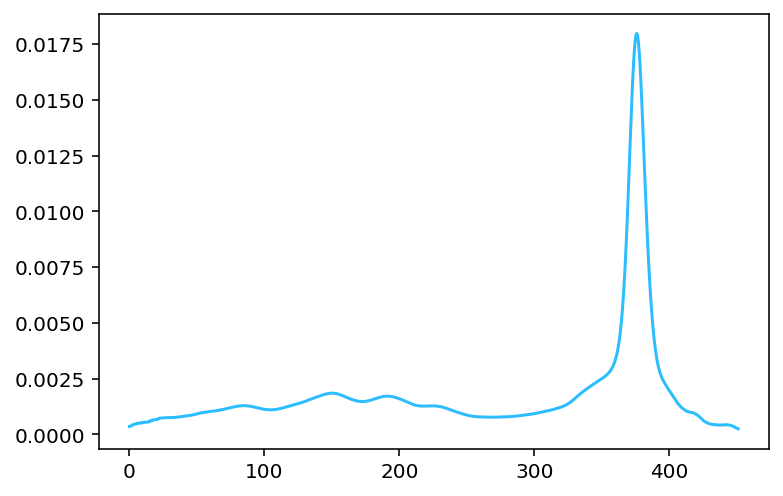

In [ ]:
plt.plot(np.arange(0,451,0.1),alignhist42[1][3382+int(np.mean(alignhist42[0])):3382+int(np.mean(alignhist42[0]))+4510])

[ 2.45411505e-04  3.72992576e+03 -1.01668584e+02  1.04094992e-03]


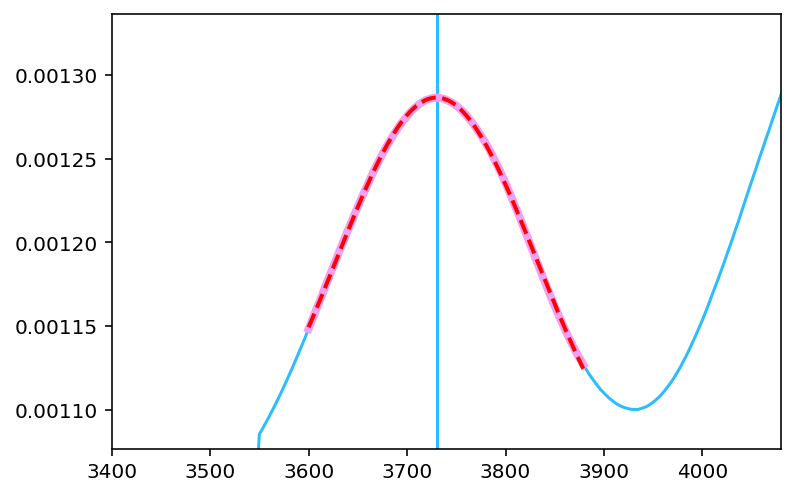

In [ ]:
popt42_1,pcov42_1=fit_peak(alignhist42[1],[3600,3880],one_gaussian,[1, 3750, 1,1],([-10,3000,-200,-1],[10,6000,200,1]))

[9.86429128e-04 4.37164338e+03 1.61842811e+02 8.32325179e-04
 4.81068128e+03 1.38291185e+02 3.79791620e-04 5.15932522e+03
 1.09736458e+02 8.53097055e-04]


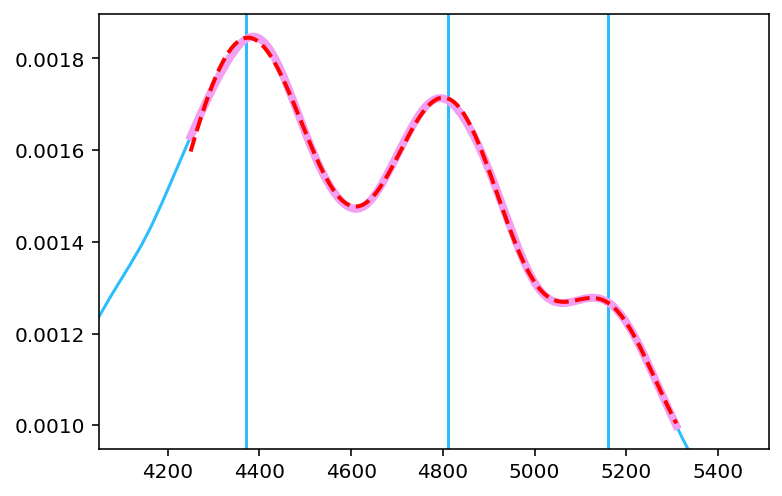

In [ ]:
popt42_t,pcov42_t=fit_peak(alignhist42[1],[4250,5310],triple_gaussian,[1, 4300, 140,1, 4800, 100,1, 5300, 100,0],([-10,4000,-200,-10,4000,-200,-10,4000,-200,-1],[1000,6000,2000,1000,6000,2000,1000,6000,2000,1]))

[ 2.84061583e-04  4.38435331e+03 -8.24601329e+01  1.56324792e-03]


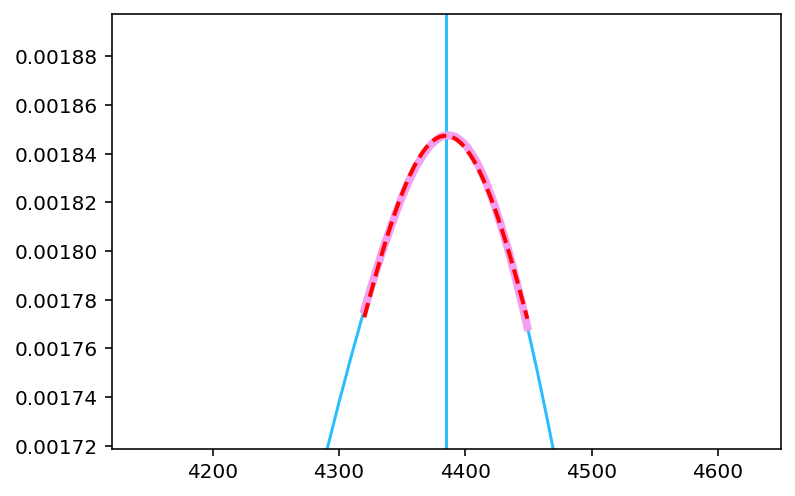

In [ ]:
popt42_2,pcov42_2=fit_peak(alignhist42[1],[4320,4450],one_gaussian,[1, 4390, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

[ 3.17476599e-04  4.79417174e+03 -9.38420104e+01  1.39579602e-03]


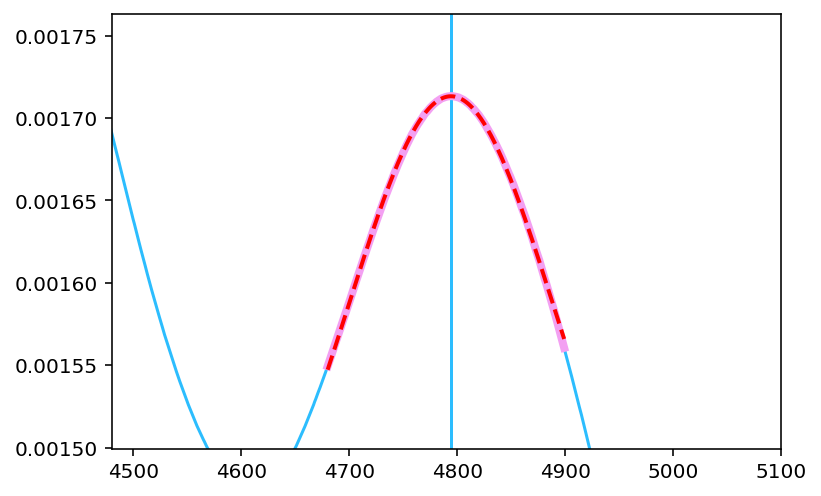

In [ ]:
popt42_3,pcov42_3=fit_peak(alignhist42[1],[4680,4900],one_gaussian,[1, 4800, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

[ 1.40160867e-02  6.64231315e+03 -5.32357267e+01  3.95415674e-03]


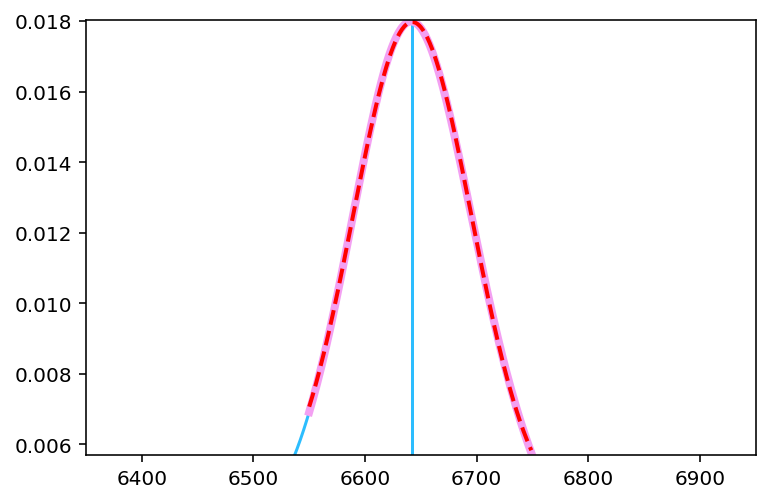

In [ ]:
popt42_5,pcov42_5=fit_peak(alignhist42[1],[6550,6750],one_gaussian,[1, 6690, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

In [ ]:
A2S2 = load_measurement('A2S2')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


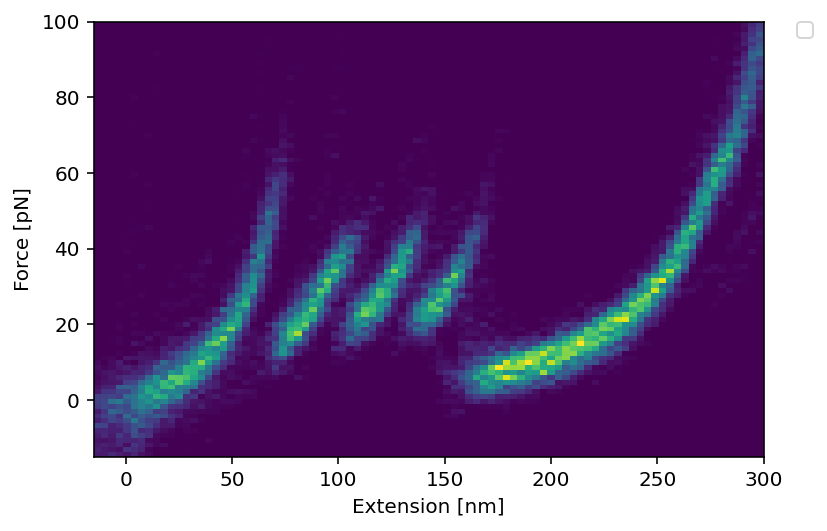

In [ ]:
plt.pcolormesh(A2S2[1][2],A2S2[1][1],A2S2[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
livasS2=[]

for i in A2S2[0]:
  print(i)
  fthres=A2S2[0][i][:]
  liva_fthres = fthres

  np.savetxt("/content/drive/MyDrive/data/liva.txt",liva_fthres)
  break

  liva = liva_transformation_order(liva_fthres[:,0],liva_fthres[:,1],
  liva_low, liva_high, a, b, l, liva_c, kT)
  
  liva_pdf = kde_hg(liva*1e9,bins*1e9,kde_kernel,kde_bandwidth)
  livasS2.append(liva_pdf)

000120


In [ ]:
alignhist_S2=align_hists_sum_full_iteration(livasS2,1,1)

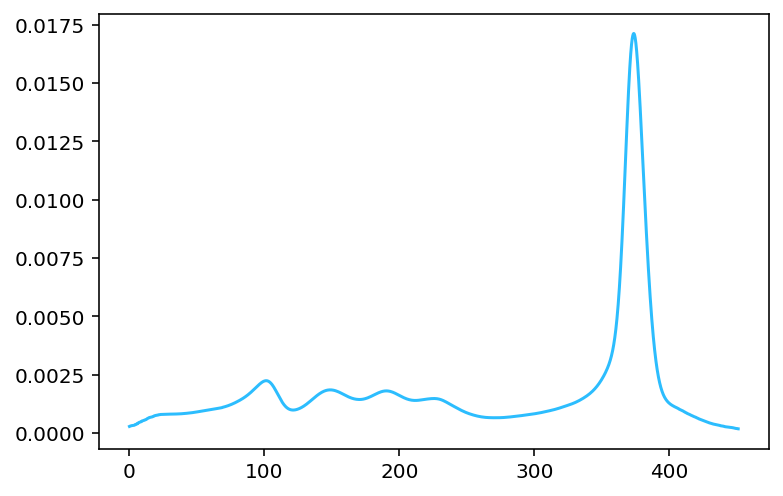

In [ ]:
plt.plot(np.arange(0,451,0.1),alignhist_S2[1][3382+int(np.mean(alignhist_S2[0])):3382+int(np.mean(alignhist_S2[0]))+4510])

[ 2.01682118e-04  4.15312003e+03 -3.40937155e+01  2.04769730e-03]


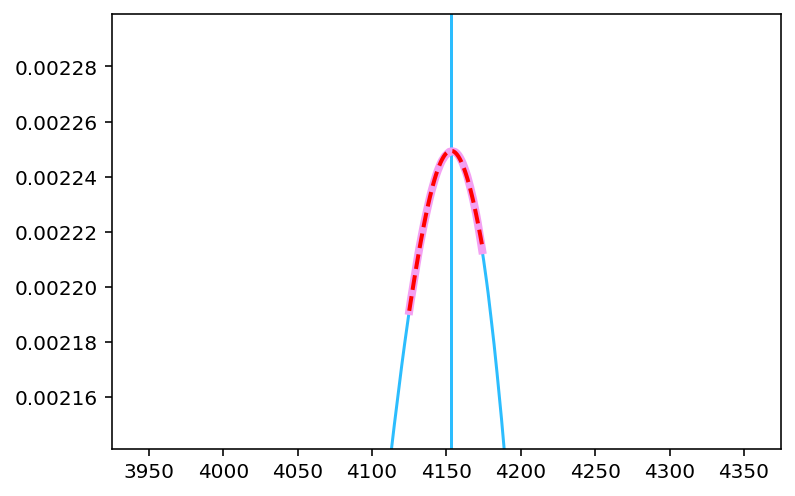

In [ ]:
poptS2_1,pcovS2_1=fit_peak(alignhist_S2[1],[4125,4175],one_gaussian,[1, 4150, 1,1],([-10,3000,-200,-1],[10,6000,200,1]))

[1.06594794e-03 4.62820298e+03 1.38156255e+02 1.00066149e-03
 5.04228673e+03 1.34695628e+02 6.80044953e-04 5.40581937e+03
 1.25997434e+02 7.79821970e-04]


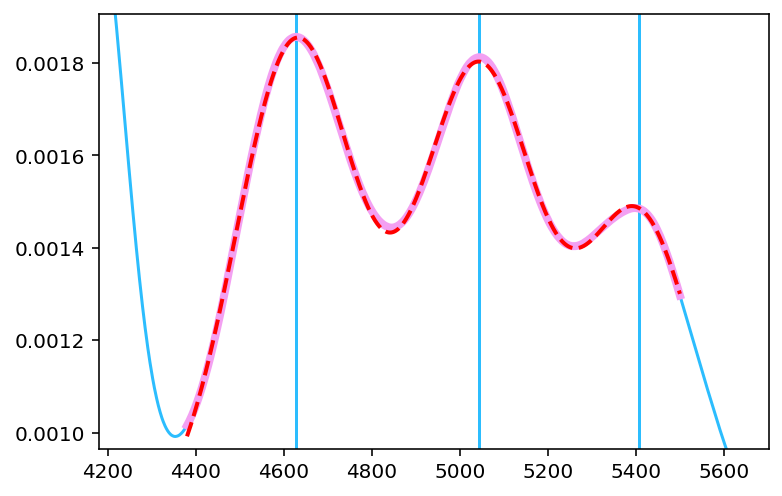

In [ ]:
poptS2_t,pcovS2_t=fit_peak(alignhist_S2[1],[4380,5500],triple_gaussian,[1, 4600, 140,1, 5000, 100,1, 5400, 100,0],([-10,4000,-200,-10,4000,-200,-10,4000,-200,-1],[1000,6000,2000,1000,6000,2000,1000,6000,2000,1]))

[ 2.33760436e-04  4.62828742e+03 -6.61075604e+01  1.62261423e-03]


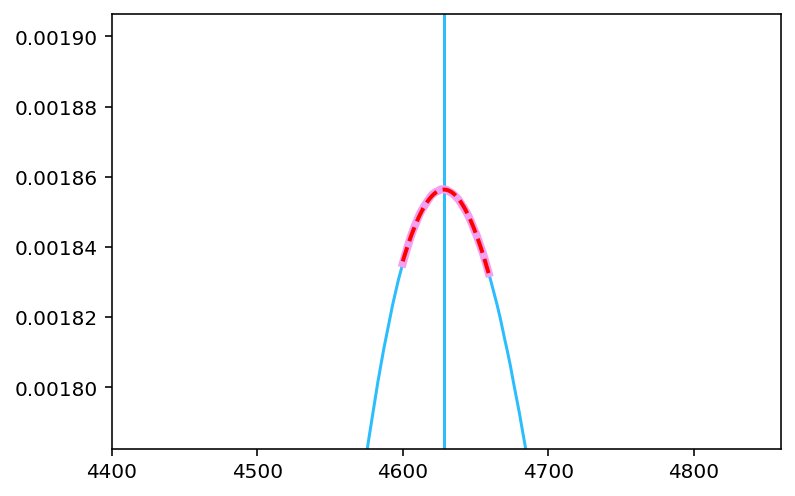

In [ ]:
poptS2_2,pcovS2_2=fit_peak(alignhist_S2[1],[4600,4660],one_gaussian,[1, 4630, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

[ 4.25852206e-04  5.04293289e+03 -8.80376795e+01  1.38730707e-03]


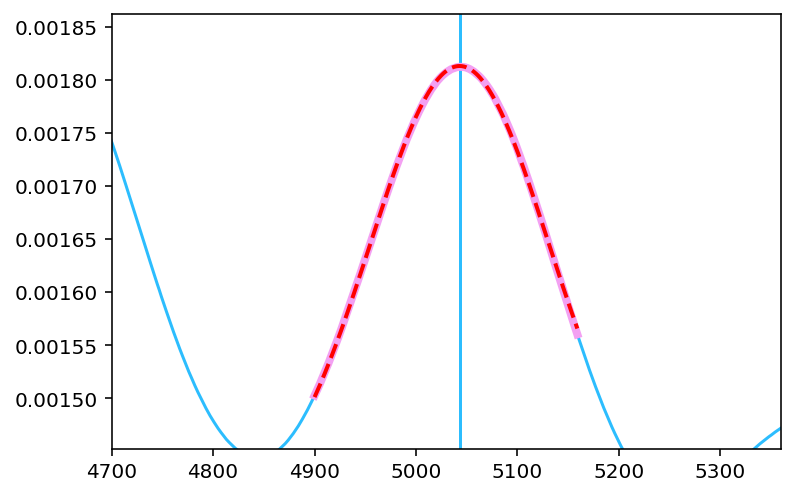

In [ ]:
poptS2_3,pcovS2_3=fit_peak(alignhist_S2[1],[4900,5160],one_gaussian,[1, 5000, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

[ 4.74182928e-05  5.39550620e+03 -4.03528581e+01  1.43866765e-03]


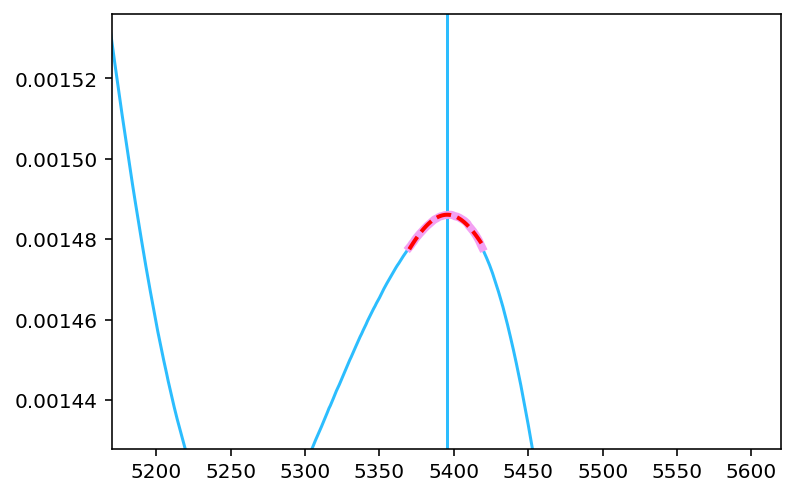

In [ ]:
poptS2_4,pcovS2_4=fit_peak(alignhist_S2[1],[5370,5420],one_gaussian,[1, 5400, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

[ 7.58413649e-03  6.87671980e+03 -4.61587190e+01  9.53565613e-03]


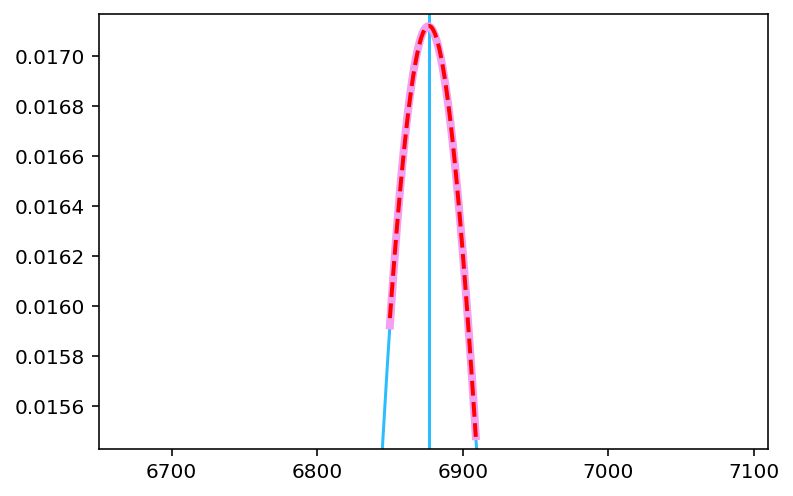

In [ ]:
poptS2_5,pcovS2_5=fit_peak(alignhist_S2[1],[6850,6910],one_gaussian,[1, 6890, 1,1],([-10,4000,-200,-1],[10,8000,200,1]))

In [ ]:
A2 = load_measurement('A2')

<KeysViewHDF5 ['raw', 'shift_x']>


No handles with labels found to put in legend.


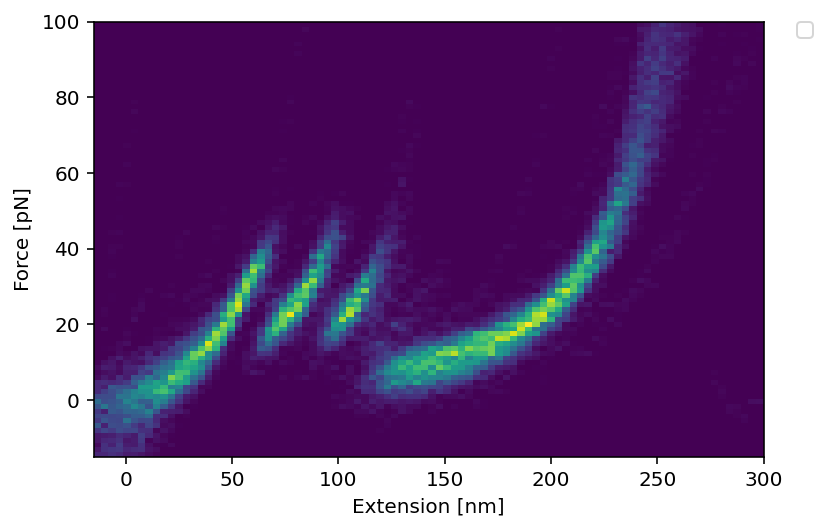

In [ ]:
plt.pcolormesh(A2[1][2],A2[1][1],A2[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
for idx, i in enumerate(A2S2[0]):
  print (idx, i)

0 000120
1 000180
2 000383
3 000934
4 001916
5 004070
6 004355
7 004705
8 004706
9 004743
10 004775
11 005027
12 005381
13 005914
14 006121
15 006460
16 007397
17 008561
18 008837
19 008988
20 009277
21 009443
22 009598
23 009673
24 009900
25 010191
26 010333
27 010734
28 010791
29 010893
30 011271
31 011548
32 011907
33 011974
34 013056
35 013116
36 013329
37 013920
38 014066
39 014143
40 014278
41 014614
42 014986
43 015399
44 016158
45 016364
46 016411
47 016644
48 016930
49 017120
50 017388
51 017434
52 017816
53 018077
54 018217
55 018952
56 019048
57 019077
58 019867
59 020488
60 020620
61 020914
62 021531
63 021681
64 021842
65 021968
66 022553
67 022817
68 022842
69 023173
70 023790
71 025204
72 025266
73 025363
74 025554
75 026186
76 026498
77 026704
78 026797
79 028384
80 028396
81 028685
82 028748
83 029004
84 029313
85 029364
86 029795
87 029849
88 030219
89 030228
90 030485
91 030919
92 031060
93 031474
94 031510
95 031526
96 031907
97 031912
98 031957
99 032343
100 032840

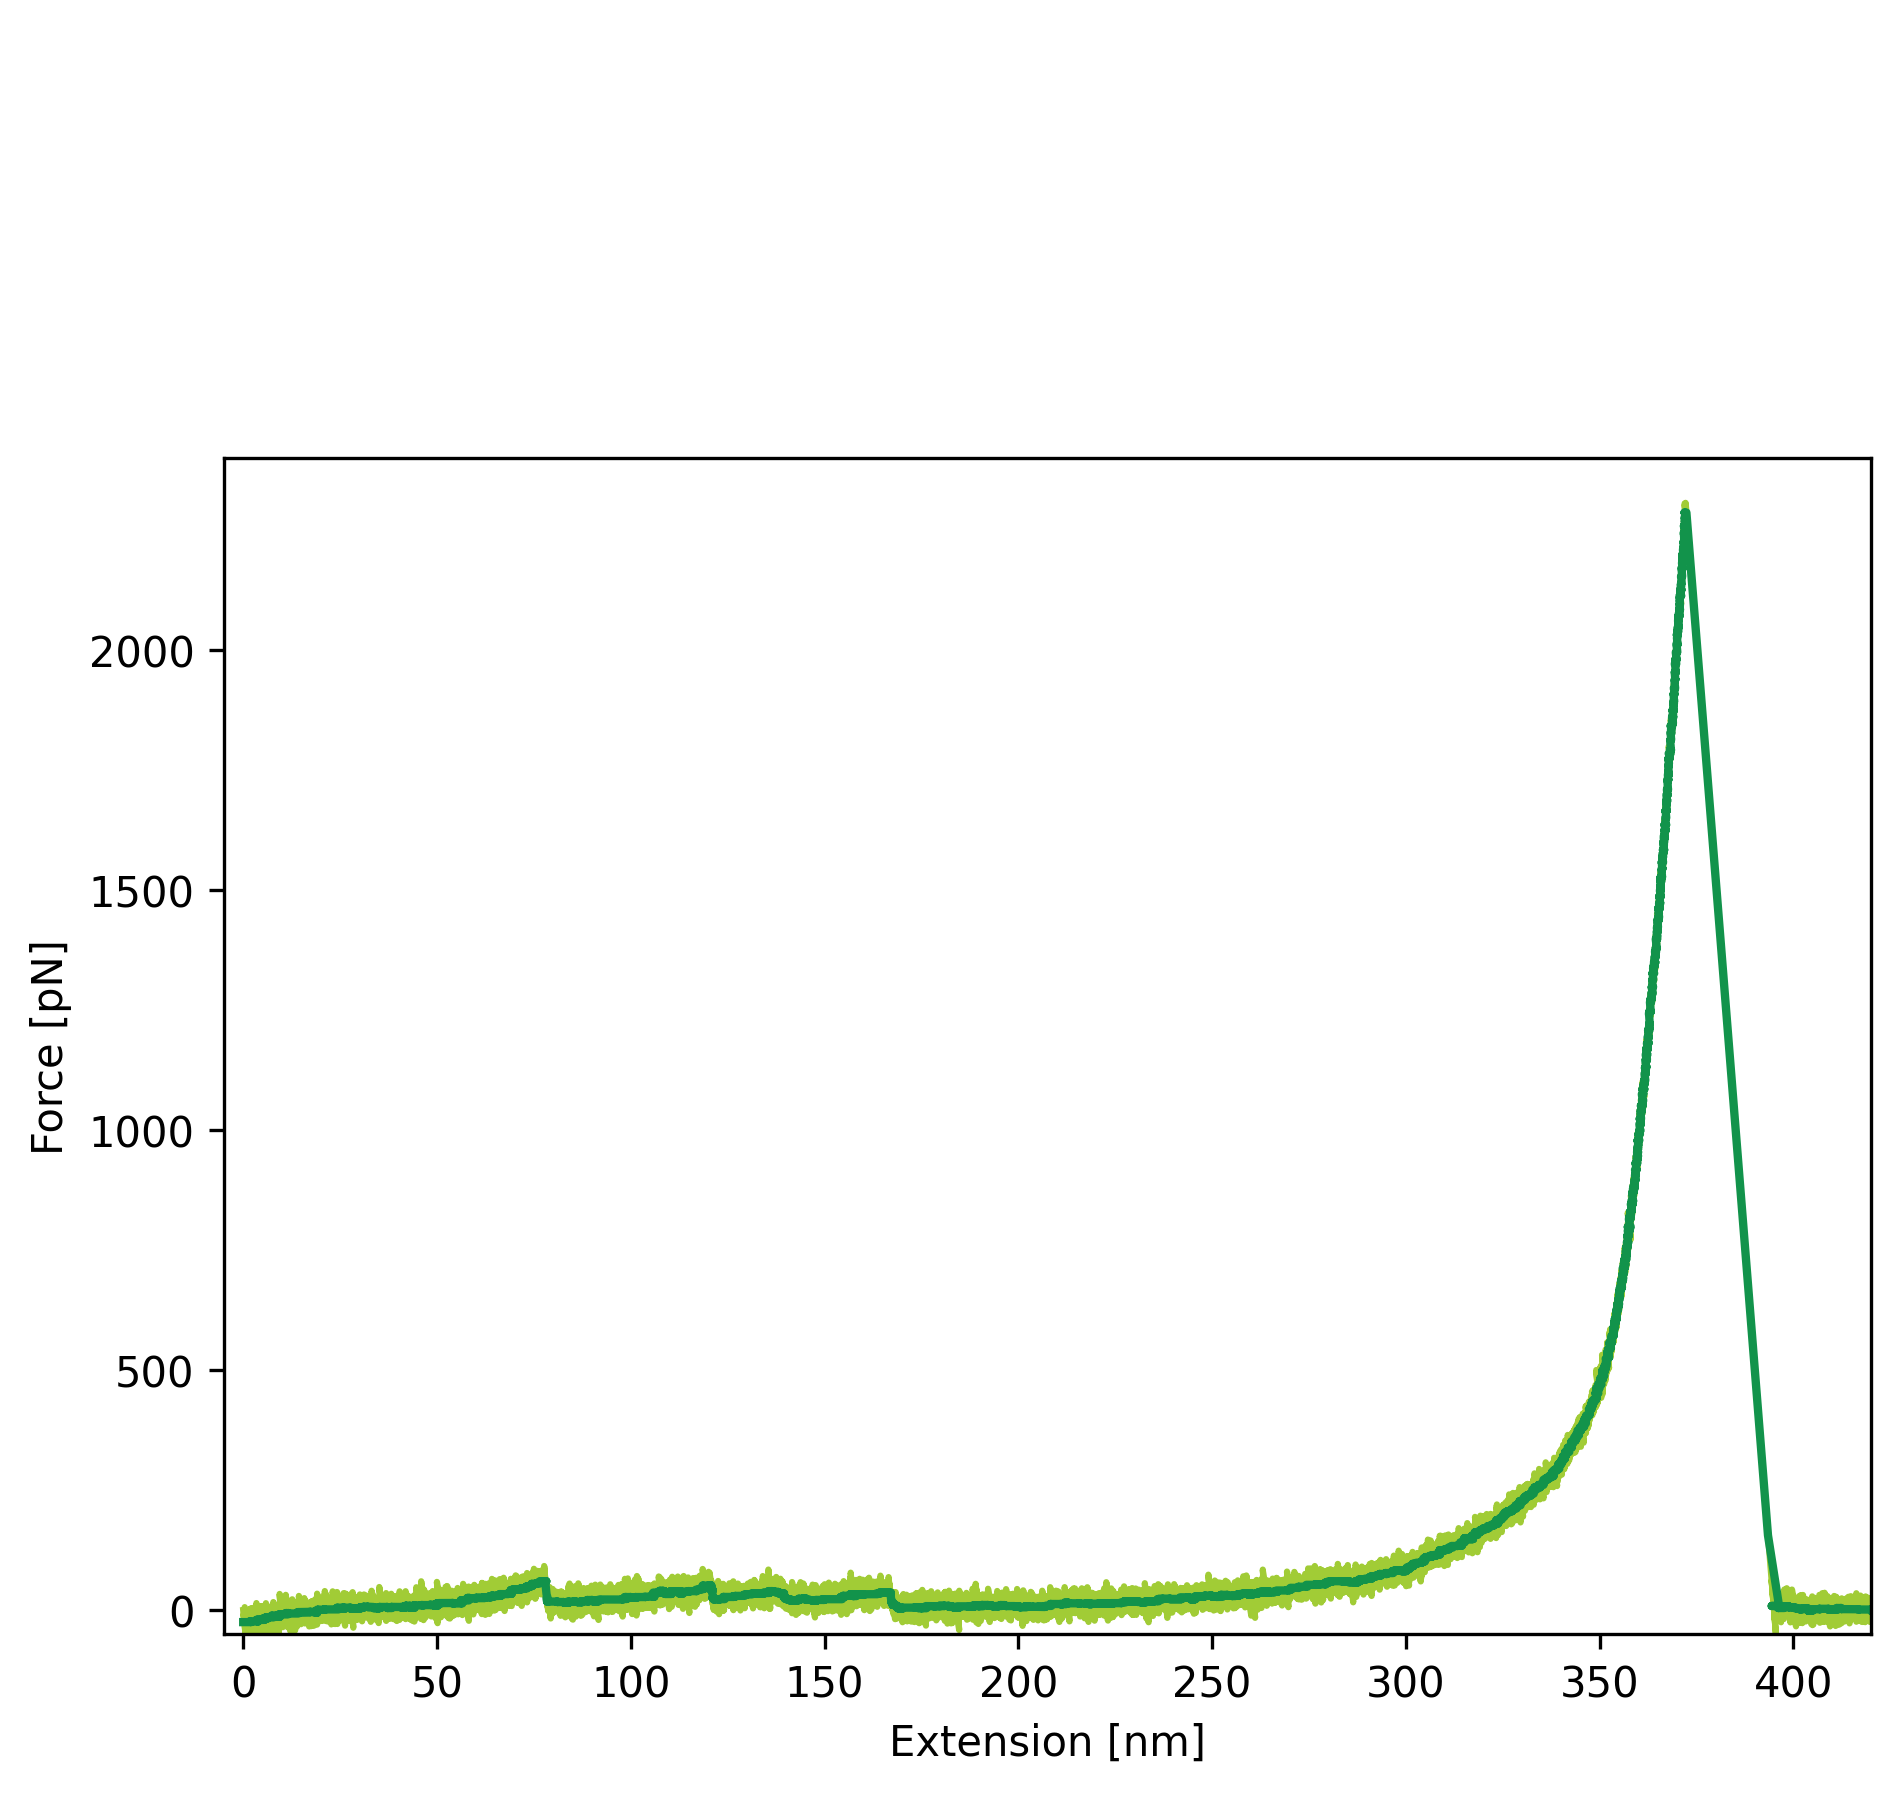

In [ ]:
cm = 1/2.54  # centimeters in inches
plt.rcParams['font.family']='Helvetica Neue'
plt.rcParams["font.weight"] = "regular"
fig = plt.figure(figsize=(22*cm,18*cm), dpi=150)#6.3*cm

gs = gridspec.GridSpec(2, 2,
                       height_ratios=[1.2,4],
                       width_ratios=[4,0.83]
                       )
gs.update(wspace=0.025, hspace=0.1)
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[0])
# ax3 = plt.subplot(gs[3],sharey=ax1)
# ax3.tick_params(axis='y', labelsize=10)
# ax3.tick_params(axis='x', labelsize=10)
# ax3.set_xlabel('probability density', fontsize=10, fontweight='bold')

ax2.axis('off')

# ax3.yaxis.tick_right()
    
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_xlabel('Extension [nm]', fontsize=10, fontweight='regular')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='regular')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='regular')
ax1.tick_params(axis='y', labelsize=10)
# ax1.set_xticks([])

# ax1.set_yticks([0,10,20,30,40,50])
# ax1.set_yticks([0,20,40,60,80,100])
# ax1.set_xticks([0,50,100,150,200])
# ax1.set_yticks(range(0, 60, 10))

ax1.set_xlim([-5, 420])
ax1.set_ylim([-50, 2400])


data_full = A2S2[0]['008988'][:]
dx=A2S2[6][19]

ax1.plot(data_full[:,0]*1e9+dx, data_full[:,1]*1e12,color=S2green,rasterized=True)

ax1.plot(data_full[:,0]*1e9+dx, data_full[:,2]*1e12,color=S2greenalt,linewidth=2)#'black' , +dy

plt.savefig('S1_single_full_curve.pdf', dpi=600,bbox_inches = "tight",transparent=True)#114 167 195 228 373

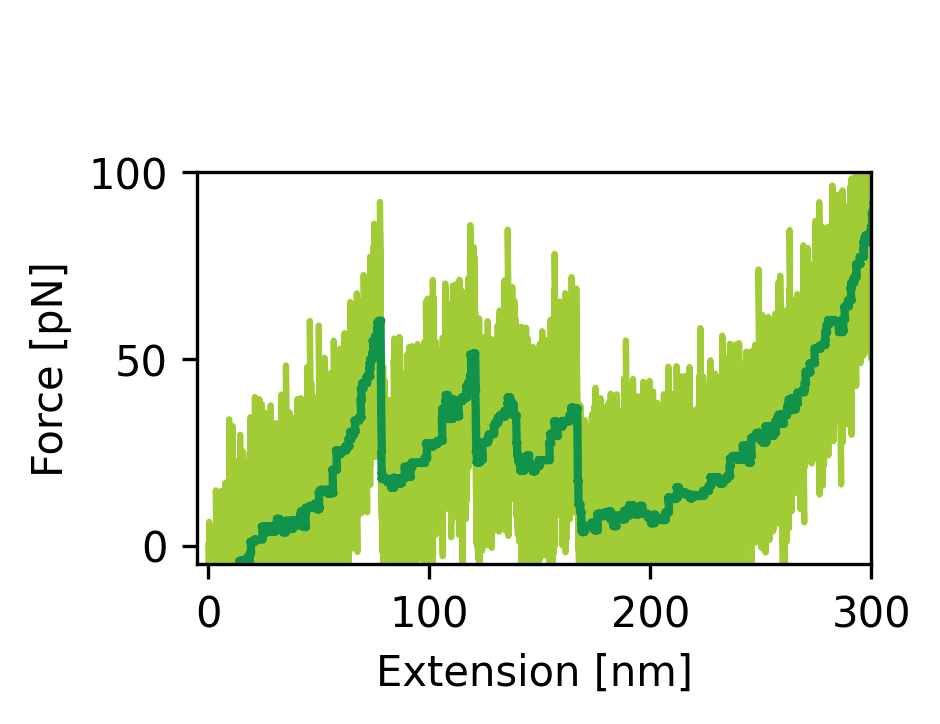

In [ ]:
cm = 1/2.54  # centimeters in inches
plt.rcParams['font.family']='Helvetica Neue'
plt.rcParams["font.weight"] = "regular"
fig = plt.figure(figsize=(9*cm,6*cm), dpi=150)#6.3*cm

gs = gridspec.GridSpec(2, 2,
                       height_ratios=[1.2,4],
                       width_ratios=[4,0.83]
                       )
gs.update(wspace=0.025, hspace=0.1)
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[0])
# ax3 = plt.subplot(gs[3],sharey=ax1)
# ax3.tick_params(axis='y', labelsize=10)
# ax3.tick_params(axis='x', labelsize=10)
# ax3.set_xlabel('probability density', fontsize=10, fontweight='bold')

ax2.axis('off')

# ax3.yaxis.tick_right()
    
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_xlabel('Extension [nm]', fontsize=10, fontweight='regular')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='regular')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='regular')
ax1.tick_params(axis='y', labelsize=10)
# ax1.set_xticks([])

# ax1.set_yticks([0,10,20,30,40,50])
# ax1.set_yticks([0,20,40,60,80,100])
# ax1.set_xticks([0,50,100,150,200])
# ax1.set_yticks(range(0, 60, 10))

ax1.set_xlim([-5, 300])
ax1.set_ylim([-5, 100])

data_full = A2S2[0]['008988'][:]
dx=A2S2[6][19]

ax1.plot(data_full[:,0]*1e9+dx, data_full[:,1]*1e12,color=S2green,rasterized=True)

ax1.plot(data_full[:,0]*1e9+dx, data_full[:,2]*1e12,color=S2greenalt,linewidth=2)#'black' , +dy


ax3.set_xlim([0, 0.095])
plt.savefig('single_full_curve_inset.pdf', dpi=600,bbox_inches = "tight",transparent=True)#114 167 195 228 373

0.0
5013.0
0 101.2
1 148.70000000000002
2 190.10000000000002
3 225.4
4 373.5


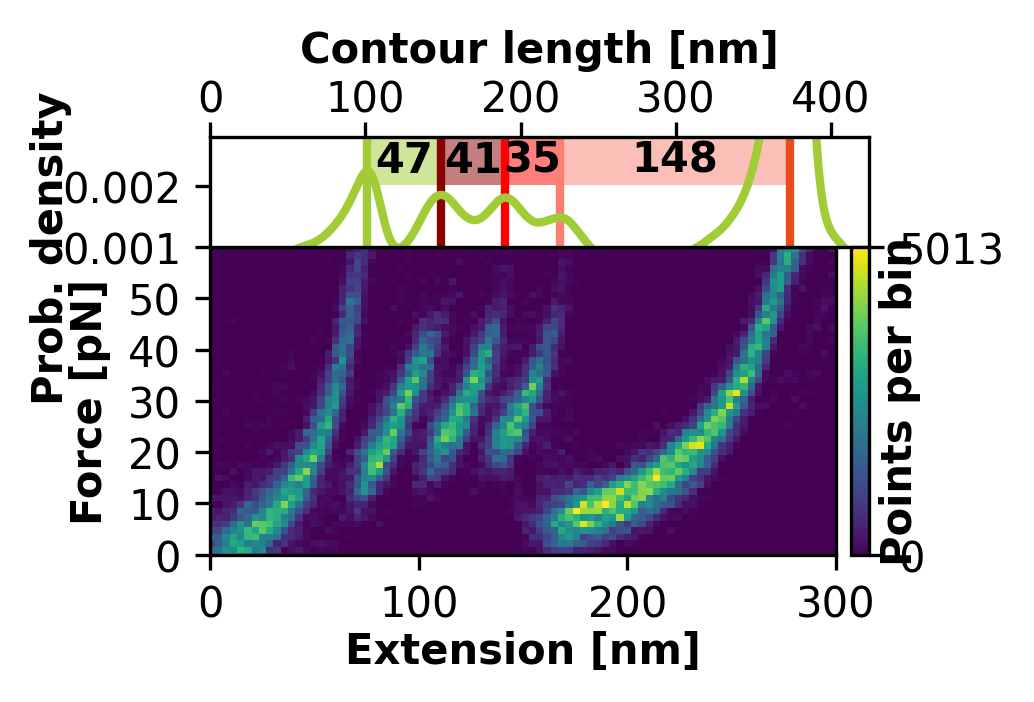

In [ ]:
cm = 1/2.54  # centimeters in inches
plt.rc('font', family='Helvetica Neue')
plt.rcParams["font.weight"] = "regular"
fig = plt.figure(figsize=(7.2*cm,4.68*cm), dpi=150)#6.3*cm
gs = gridspec.GridSpec(2, 1,
                       height_ratios=[1.5, 4.2]
                       )
gs.update(wspace=0.025, hspace=0.0)
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[2])

plot4 = ax1.pcolormesh(A2S2[1][2],A2S2[1][1],A2S2[1][0], zorder=-2,rasterized=True,label='Data1')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.05)
h_hm=1
if h_hm == 0:
    cax1.get_xaxis().set_visible(False)
    cax1.axes.get_yaxis().set_visible(False)
    cax1.patch.set_visible(False)
    cax1.set_axis_off()
if h_hm == 1:
    cbar1 = fig.colorbar(plot4, cax = cax1)
    yticks = cax1.yaxis.get_major_ticks()


    print (np.min(A2S2[1][0]))
    print (np.max(A2S2[1][0]))
    cbar1.set_ticks([np.min(A2S2[1][0]), np.max(A2S2[1][0])])
    cax1.tick_params(axis='y', labelsize=10)
    cax1.yaxis.set_label_coords(1.5,0.5)
    cax1.set_ylabel('Points per bin', fontsize=10,fontweight='bold')
    
ax1.plot([],linewidth=4,label='ACE2-85aa_linker-RBD-SARS-CoV-1',color=Blue)
ax1.plot([],linewidth=4,label='ACE2-85aa_linker-RBD-SARS-CoV-1',color=Amber)


ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_xlabel('Extension [nm]', fontsize=10, fontweight='bold')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='bold')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='bold')
ax1.tick_params(axis='y', labelsize=10)
# ax1.set_xticks([])

ax1.set_yticks([0,10,20,30,40,50])
ax1.set_yticks([0,10,20,30,40,50])
# ax1.set_yticks(range(0, 60, 10))

ax1.set_xlim([-0, 300])
ax1.set_ylim([-0, 60])

# for idx,liness in enumerate([popt42_1[1],popt42_2[1],popt42_3[1],popt42_t[7],popt42_5[1]]):
#     if idx == 0:
#         ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))],linewidth=2.5, color=Amber,linestyle="--", alpha=0.6)
#     else:
#         ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))],linewidth=2.5, color=Amber, alpha=0.6)
    
# for liness in [popt33_1[1],popt33_2[1],popt33_3[1],popt33_t[7],popt33_5[1]]:
#     ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist33[0]))))],linewidth=2,color=Blue, alpha=0.6)

# ax2.plot(np.arange(0,451,0.1),alignhist42[1][3382+int(np.mean(alignhist42[0])):3382+int(np.mean(alignhist42[0]))+4510],linewidth=4, color=Amber)
# ax2.plot(np.arange(0,451,0.1),alignhist33[1][3382+int(np.mean(alignhist33[0])):3382+int(np.mean(alignhist33[0]))+4510],linewidth=4, color=Blue)


ax2.xaxis.set_label_position('top') 
ax2.xaxis.tick_top()
ax2.set_xlabel('Contour length [nm]', fontsize=10,fontweight='bold')
ax2.set_ylabel('Prob. density', fontsize=10,fontweight='bold')
ax2.yaxis.set_label_coords(-0.21, -0.00)
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

# ax2.set_ylim([0.0010, 0.0028])
ax2.set_xlim([-20, 400])
ax1.xaxis.labelpad = 1
ax2.tick_params(axis='x', pad=0.5)
# ax3.set_xlim([0, 410])


colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]
colors = ["dodgerblue","darkred","red","salmon",Clfa]
colors_42 = [Amber,"darkred","red","salmon",Clfa]


# ax2.hist(peaksgsS2[:, 1]-shifts,color=colors_42[0],alpha=0.5)
# ax2.hist(peaksgsS2[:, 2]-shifts,color=colors_42[1],alpha=0.5)
# ax2.hist(peaksgsS2[:, 3]-shifts,color=colors_42[2],alpha=0.5)
# ax2.hist(peaksgsS2[:, 0]-shifts,color=colors_42[3],alpha=0.5)



    
bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height

colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]

for liness in [poptS2_1[1],poptS2_2[1],poptS2_3[1],poptS2_4[1],poptS2_5[1]]:
    increments.append(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist_S2[0]))))])
    
    
bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height

colors = [S2green,"darkred","red","salmon",Clfa]

for idx,fit in enumerate(increments):
    print (idx,fit)
    ax2.vlines(fit,color=colors[idx],ymin=0, ymax=max,linewidth=2)
        
    if idx == len(increments)-1:
        break
        
    ax2.annotate(int(increments[idx+1]-fit), xy=(fit+(increments[idx+1]-fit)/2, max-(max-min)/3.2), xycoords='data',color='black', ha='center',fontweight='bold', fontsize=10)

#     if idx != 0:
#         ax2.annotate(int(bfits[idx+1]-fit), xy=(fit+(bfits[idx+1]-fit)/2, 0.14-((0.378048780488*(ax1h/height))/1.4)), xycoords='data',color='white', ha='center',fontweight='bold', fontsize=16)
    rect1 = matplotlib.patches.Rectangle((fit,max-factor*0.16), increments[idx+1]-fit, factor*0.25, color=colors[idx], alpha = 0.5,linewidth=0)
    ax2.add_patch(rect1)

ax2.set_ylim([0.0010, 0.0028])
ax2.set_xlim([0, 425])


ax2.plot(np.arange(0,451,0.1),alignhist_S2[1][3382+int(np.mean(alignhist_S2[0])):3382+int(np.mean(alignhist_S2[0]))+4510], color=S2green,linewidth=2)
    

fig.savefig('A2S2.pdf',bbox_inches = "tight", dpi=600,transparent=True)#114 167 195 228 373

0.0
0 95.7
1 148.6
2 190.10000000000002
3 223.60000000000002
4 378.6


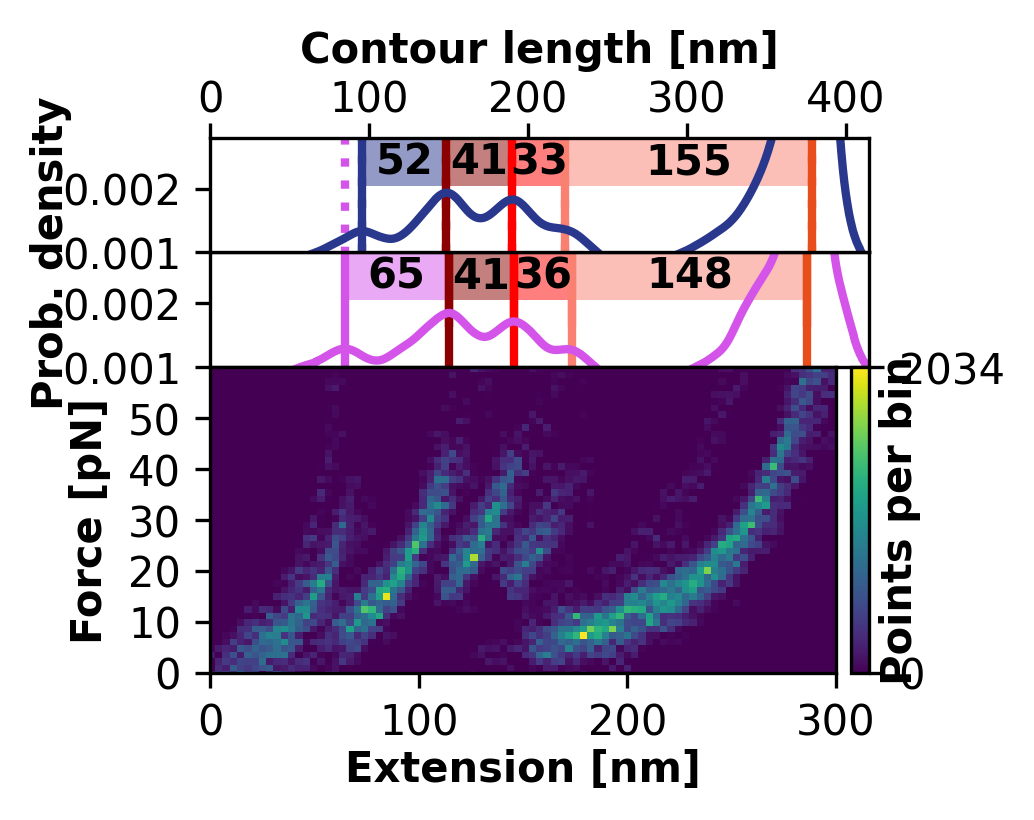

In [ ]:
cm = 1/2.54  # centimeters in inches

plt.rc('font', family='Helvetica Neue')
plt.rcParams["font.weight"] = "regular"
fig = plt.figure(figsize=(7.2*cm,6*cm), dpi=150,frameon=False)
gs = gridspec.GridSpec(3, 1,
                       height_ratios=[1.5,1.5,4]
                       )
gs.update(wspace=0.025, hspace=0.0)
ax3 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])

plot4=ax1.pcolormesh(A2S1_long_1[1][2],A2S1_long_1[1][1],A2S1_long_1[1][0], zorder=-2,rasterized=True)

divider1 = make_axes_locatable(ax1)
h_hm=1
cax1 = divider1.append_axes("right", size="3%", pad=0.05)
if h_hm == 0:
    cax1.get_xaxis().set_visible(False)
    cax1.axes.get_yaxis().set_visible(False)
    cax1.patch.set_visible(False)
    cax1.set_axis_off()
if h_hm == 1:
    cbar1 = fig.colorbar(plot4, cax = cax1)
    yticks = cax1.yaxis.get_major_ticks()


    print (np.min(A2S1_long_1[1][0]))

    cbar1.set_ticks([np.min(A2S1_long_1[1][0]), np.max(A2S1_long_1[1][0])])
    cax1.tick_params(axis='y', labelsize=10)
    cax1.yaxis.set_label_coords(1.5,0.5)
    cax1.set_ylabel('Points per bin', fontsize=10,fontweight='bold')
    
ax1.plot([],linewidth=4,label='ACE2-85aa_linker-RBD-SARS-CoV-1',color=Blue)
ax1.plot([],linewidth=4,label='ACE2-85aa_linker-RBD-SARS-CoV-1',color=Amber)


ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_xlabel('Extension [nm]', fontsize=10,fontweight='bold')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='bold')
ax1.set_ylabel('Force [pN]', fontsize=10,fontweight='bold')
ax1.tick_params(axis='y', labelsize=10)
# ax1.set_xticks([])

ax1.set_yticks([0,10,20,30,40,50])
ax1.set_yticks([0,10,20,30,40,50])
# ax1.set_yticks(range(0, 60, 10))

ax1.set_xlim([-0, 300])
ax1.set_ylim([-0, 60])

# for idx,liness in enumerate([popt42_1[1],popt42_2[1],popt42_3[1],popt42_t[7],popt42_5[1]]):
#     if idx == 0:
#         ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))],linewidth=2.5, color=Amber,linestyle="--", alpha=0.6)
#     else:
#         ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))],linewidth=2.5, color=Amber, alpha=0.6)
    
# for liness in [popt33_1[1],popt33_2[1],popt33_3[1],popt33_t[7],popt33_5[1]]:
#     ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist33[0]))))],linewidth=2,color=Blue, alpha=0.6)

# ax2.plot(np.arange(0,451,0.1),alignhist42[1][3382+int(np.mean(alignhist42[0])):3382+int(np.mean(alignhist42[0]))+4510],linewidth=4, color=Amber)
# ax2.plot(np.arange(0,451,0.1),alignhist33[1][3382+int(np.mean(alignhist33[0])):3382+int(np.mean(alignhist33[0]))+4510],linewidth=4, color=Blue)


ax2.xaxis.set_label_position('top') 
ax2.xaxis.tick_top()
ax3.get_xaxis().set_ticks([])
ax2.set_xlabel('Contour length [nm]', fontsize=10,fontweight='bold')#,fontweight='regular'
ax2.set_ylabel('Prob. density', fontsize=10,fontweight='bold')
ax2.yaxis.set_label_coords(-0.21, -0.00)
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

# ax2.set_ylim([0.0010, 0.0028])
ax2.set_xlim([-0, 415])
ax3.set_xlim([-0, 415])
ax1.xaxis.labelpad = 1
ax2.tick_params(axis='x', pad=0.5)

colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]
colors = ["dodgerblue","darkred","red","salmon",Clfa]
colors_42 = [Amber,"darkred","red","salmon",Clfa]
    
bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height


colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]

for liness in [popt33_1[1],popt33_2[1],popt33_3[1],popt33_t[7],popt33_5[1]]:
    increments.append(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist33[0]))))])
    
incrementslong=[]

for liness in [popt42_1[1],popt42_2[1],popt42_3[1],popt42_t[7],popt42_5[1]]:
    incrementslong.append(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))])

    
ax3.plot(np.arange(0,451,0.1),alignhist42[1][3382+int(np.mean(alignhist42[0])):3382+int(np.mean(alignhist42[0]))+4510],linewidth=2, color="#D454EA")
ax2.plot(np.arange(0,451,0.1),alignhist33[1][3382+int(np.mean(alignhist33[0])):3382+int(np.mean(alignhist33[0]))+4510],linewidth=2, color=S1blue)


bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height

colors = [S1blue,"darkred","red","salmon",Clfa]
colors_42 = ["#D454EA","darkred","red","salmon",Clfa]

for idx,fit in enumerate(increments):
    print (idx,fit)
    ax2.vlines(fit,color=colors[idx],ymin=0, ymax=max-2*factor*0.25,linewidth=2)
    
    ax2.vlines(fit,color=colors[idx],ymin=0.0010, ymax=0.0028,linewidth=2,linestyle=":")
    ax2.vlines(fit,color=colors[idx],ymin=max-2*factor*0.25, ymax=max,linewidth=2)
    
    if idx == 0:
        ax2.vlines(incrementslong[idx],color=colors_42[idx],linestyle=":",ymin=0.00095, ymax=0.0028,linewidth=2)
        ax3.vlines(incrementslong[idx],color=colors_42[idx],ymin=0, ymax=max,linewidth=2)
    else:
        ax3.vlines(incrementslong[idx],color=colors_42[idx],ymin=0, ymax=max,linewidth=2)
        ax3.vlines(incrementslong[idx],color=colors_42[idx],ymin=max-factor*0.25, ymax=max,linewidth=2)
        
    if idx == len(increments)-1:
        break
        
    ax2.annotate(int(increments[idx+1]-fit), xy=(fit+(increments[idx+1]-fit)/2, max-(max-min)/3.2), xycoords='data',color='black', ha='center',fontweight='bold', fontsize=10)
    ax3.annotate(int(incrementslong[idx+1]-incrementslong[idx]), xy=(incrementslong[idx]+(incrementslong[idx+1]-incrementslong[idx])/2, max-(max-min)/3.2), xycoords='data',color='black', ha='center',fontweight='bold', fontsize=10)
#     if idx != 0:
#         ax2.annotate(int(bfits[idx+1]-fit), xy=(fit+(bfits[idx+1]-fit)/2, 0.14-((0.378048780488*(ax1h/height))/1.4)), xycoords='data',color='white', ha='center',fontweight='bold', fontsize=16)
    rect1 = matplotlib.patches.Rectangle((fit,max-factor*0.16), increments[idx+1]-fit, factor*0.25, color=colors[idx], alpha = 0.5,linewidth=0)
    ax2.add_patch(rect1)
    
    rect2 = matplotlib.patches.Rectangle((incrementslong[idx],max-factor*0.16), incrementslong[idx+1]-incrementslong[idx], factor*0.25, color=colors_42[idx], alpha = 0.5,linewidth=0)
    ax3.add_patch(rect2)
    
# ax2.axhline(max-factor*0.25,color='black',linewidth=1)

    
# ax2.axhline(max-factor*0.25,color='black',linewidth=1)
# ax1.legend(loc="upper left",prop={'size': 15})
# ax0.legend(loc="upper left",prop={'size': 15})

# bbox = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# width, height = bbox.width, bbox.height
# print width/cm, height/cm

# bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# width, height = bbox.width, bbox.height
# print width/cm, height/cm

# bbox = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# width, height = bbox.width, bbox.height
# print width/cm, height/cm

ax2.set_ylim([0.0010, 0.0028])
ax3.set_ylim([0.0010, 0.0028])

# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('test0.pdf',bbox_inches = "tight", dpi=600,transparent=True)#114 167 195 228 373

In [ ]:
A2S2_dyn_400 = load_measurement('A2S2_dyn_400')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


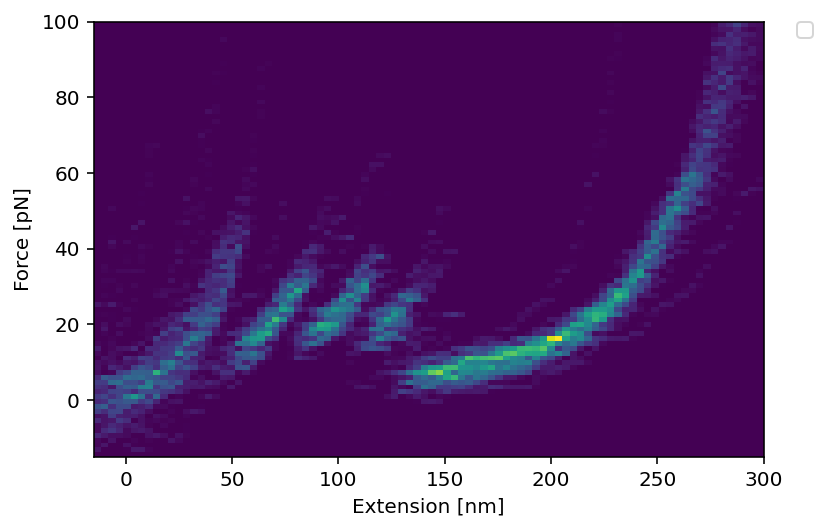

In [ ]:
plt.pcolormesh(A2S2_dyn_400[1][2],A2S2_dyn_400[1][1],A2S2_dyn_400[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
A2S2_dyn_800 = load_measurement('A2S2_dyn_800')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


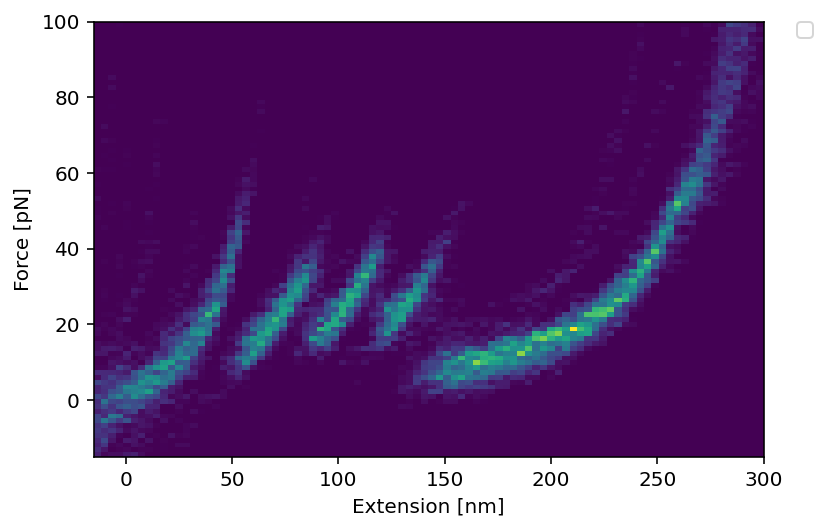

In [ ]:
plt.pcolormesh(A2S2_dyn_800[1][2],A2S2_dyn_800[1][1],A2S2_dyn_800[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
A2S2_dyn_1600 = load_measurement('A2S2_dyn_1600')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


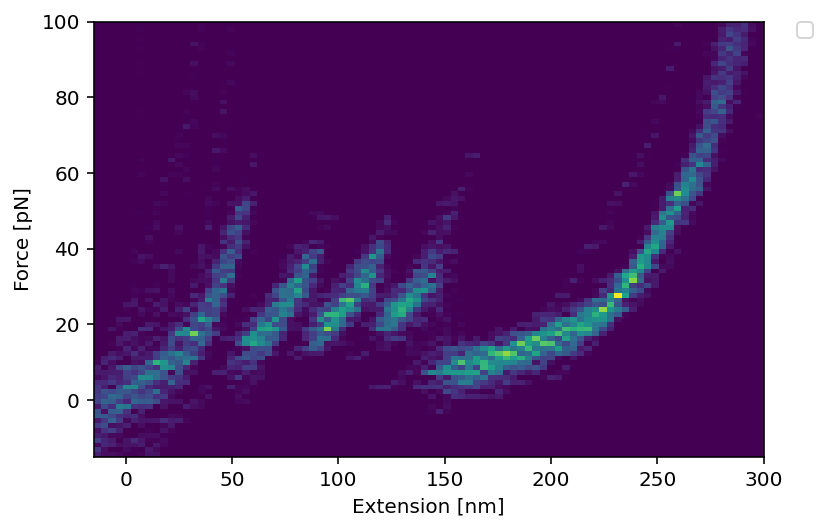

In [ ]:
plt.pcolormesh(A2S2_dyn_1600[1][2],A2S2_dyn_1600[1][1],A2S2_dyn_1600[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
A2S2_dyn_3200 = load_measurement('A2S2_dyn_3200')

<KeysViewHDF5 ['liva_data', 'peak_data', 'peak_lbl', 'raw', 'shift_x', 'wlc_data']>


No handles with labels found to put in legend.


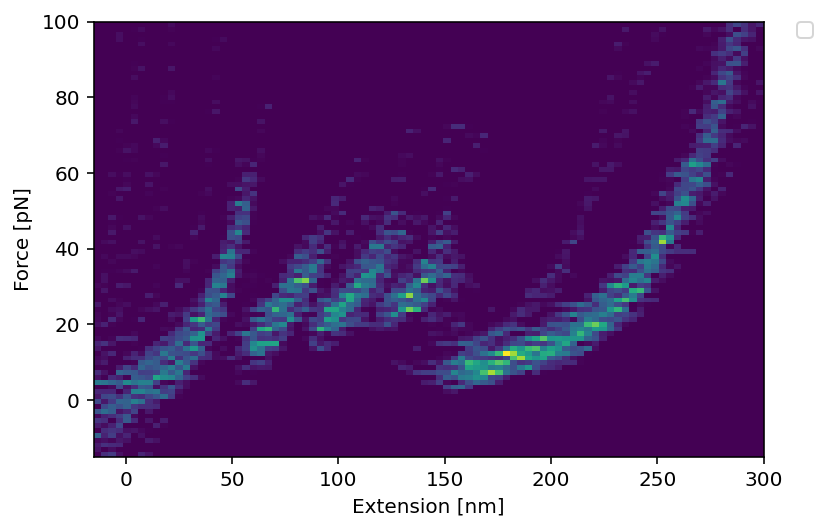

In [ ]:
plt.pcolormesh(A2S2_dyn_3200[1][2],A2S2_dyn_3200[1][1],A2S2_dyn_3200[1][0], zorder=-2,rasterized=True)
plt.xlabel('Extension [nm]')
plt.ylabel('Force [pN]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
def force_hists(peak,forces,loadingrates):
#     print peak,"------"
#     plt.figure(figsize=(28, 9), dpi=300)
    fig, ax = plt.subplots(len(forces)+1, sharex=True, sharey=True,figsize=(4, 6), dpi=300)
    
    
    mpforce=np.empty(0)
    2
    for idx,(force,loadingrate) in enumerate(zip(forces,loadingrates)):
        print (["A2S1","A2S2","A2S2_dyn800","A2S1_long_1"][idx],"---",peak)

        pub = 0
        # delete all values with rupture forces below 0.0
        # should not exist in any case
        # curr_loading_rates = S2N501Y_lr#a[:,1]*1e-12#
        curr_loading_rates =loadingrate
        # this one last
        # curr_rup_forces = S2N501Y#ydata_#a[:,0]*1e-12#ydata2_
        curr_rup_forces = force

        fdot = curr_avg_loadrate = np.mean(curr_loading_rates[curr_loading_rates>0.0])
        curr_avg_loadrate_std = np.std(curr_loading_rates[curr_loading_rates>0.0] )

        N_ = curr_rup_forces.shape[0]

        if pub == 1:
            max_ = 200.0e-12
            binwidth = 50.0e-12 # pN, we calculate in SI
        else:
            max_ = np.max(curr_rup_forces)
            print(max_)
            if max_ > 2.0*np.mean(curr_rup_forces) : # maximum guessed too large
                max_ = 2 * np.mean(curr_rup_forces)

            # max_ = 120.0e-12
            binwidth = (int(max_*1.0e12)//20 )*1.0e-12 # we calculate in SI


        guesses = [ 0.7e-9, 0.1 ]
        ( most_probable_force, f_error_neg, f_error_pos,
                deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
                ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )

        if most_probable_force == -1 : # the fit must have failed, try again:
            guesses = [ 0.1e-9, 0.001 ]
            ( most_probable_force, f_error_neg, f_error_pos,
                deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
                ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )

            if most_probable_force == -1 : # the fit must have failed, try again:
                guesses = [ 0.05e-9, 0.00000001 ]
                ( most_probable_force, f_error_neg, f_error_pos,
                        deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
                        ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )



        koff0 = koff
        probability_density=ydata
        # width = 0.9*binwidth
        # self.dia_ax.bar( (bins-binwidth+(0.1*binwidth) )*1.0e12, probability_density*1.0e-12 , width*1.0e12, color=thiscolor,
        #     linewidth=1 , alpha=alpha*0.5)

        # binsall = bins
        nn, nbins, npatches = ax[idx].hist(curr_rup_forces*1.0e12, bins=bins_all*1.0e12,
             histtype='bar', rwidth=0.8 , density=True, stacked=True,
            cumulative=False, linewidth=1, color=color_list[idx],alpha=0.5)
        
        nn, nbins, npatches = ax[len(forces)].hist(curr_rup_forces*1.0e12, bins=bins_all*1.0e12,
             histtype='bar', rwidth=0.8 , density=True, stacked=True,
            cumulative=False, linewidth=1, color=color_list[idx],alpha=0.5)

        if most_probable_force == -1.0:
            print(" BELL EVANS FIT FAILED !")
        else:
            # pass
            print("bla")
            print(bins__*1.0e12)
            ax[idx].plot( bins__*1.0e12, bell_*1.0e-12,linewidth=2,color=color_list[idx])#, linestyle="--"
            ax[len(forces)].plot( bins__*1.0e12, bell_*1.0e-12,linewidth=2,color=color_list[idx])#, linestyle="--"

        #
        #
        # plt.set_xlim([0.0,np.max(bins)*1.0e12])

        # print("\n\n------ [RESULTS] v=%s nm/s ------"%np.round( int(
        #          *1e9), decimals=-2)
        print(" mean loading rate +- sigma = %6.4G pN/s +- %6.4G pN/s"% (curr_avg_loadrate*1.0e12,
            curr_avg_loadrate_std*1.0e12 ))
        print(" Most probable rupture Force = %6.4G pN "%(most_probable_force*1.0e12 ))
        print(" asymmetric FWHM Errors      = -%6.4G pN  +%6.4G pN"%(f_error_neg*1.0e12,f_error_pos*1.0e12 ))
        print(" deltax = %6.4G nm\n koff0 = %6.4G s^-1"%(deltax*1.0e9, koff))
        print("\n resulting error in fit covar. matrix \n deltax +- %6.4G nm , koff0 +- %6.4G 1/s" %(
            deltax_fiterr*1.0e9, koff_fiterr*1.0e9))
        print("---------------------------------")
        ax[idx].axvline(most_probable_force*1.0e12,color=color_list[idx],linewidth=2.5)
        ax[len(forces)].axvline(most_probable_force*1.0e12,color=color_list[idx],linewidth=2.5)
        ax[idx].text(most_probable_force*1.0e12+1.5, .052, int(most_probable_force*1.0e12),color=color_list[idx],fontsize=16,fontweight='bold')
        mpforce=np.append(mpforce,most_probable_force)
        ax[idx].set_xlim([0,80])
        ax[idx].set_ylim([0,0.09])

        ax[idx].tick_params(axis='x', labelsize=16)
        ax[idx].tick_params(axis='y', labelsize=16)
        
        ax[idx].spines['right'].set_color('none')
        ax[idx].spines['top'].set_color('none')

    ax[len(forces)].set_xlim([0,80])
    ax[len(forces)].set_ylim([0,0.09])

    ax[len(forces)].tick_params(axis='x', labelsize=16)
    ax[len(forces)].tick_params(axis='y', labelsize=16)
#     fig.xlabel('Force [pN]',fontsize=16,fontweight='bold')
#     fig.ylabel('Probability density',fontsize=16,fontweight='bold')
#     fig.text(0.5,0.05, 'Force [pN]', ha="center", va="center",fontsize=16,fontweight='bold')
#     fig.text(-0.045,0.5, 'Probability density', ha="center", va="center", rotation=90,fontsize=16,fontweight='bold')
    
    fig.subplots_adjust(hspace=0.2)

    # plt.legend(loc='upper right',
    #           fancybox=True, shadow=True,  prop={'size': 13})#, bbox_to_anchor=(0.4, -0.45), ncol=5,

    plt.xticks([0,20,40,60,80])
    
    ax[len(forces)].spines['right'].set_visible(False)
    ax[len(forces)].spines['top'].set_visible(False)
    

    fig.tight_layout()
    return mpforce

In [ ]:
def return_tickvalues():
    axes_width       = 3.5
    tickwidth_major  = 3.5
    tickwidth_minor  = 2.0
    ticklength_major = 8.0
    ticklength_minor = 6.25

    return axes_width, tickwidth_major, tickwidth_minor, ticklength_major, ticklength_minor

In [ ]:
def BEs(forces,loadingrates,name):

    fig, f = make_prettyfig_fontsize(22)

    handles, labels = f.get_legend_handles_labels()

    std_error=0

    colors = [
        (0.0, 0.09803921568627451, 0.6588235294117647),
        (0.996078431372549, 0.4, 0.0),
        (0.0, 0.4470588235294118, 0.1607843137254902),
        (0.8627450980392157, 0.1411764705882353, 0.12156862745098039),
        (0.4588235294117647, 0.06274509803921569, 0.33725490196078434),
        (0.0, 0.6274509803921569, 0.8862745098039215),
        (1.0, 0.807843137254902, 0.0),
        (0.5372549019607843, 0.3058823529411765, 0.1411764705882353),
        "grey",
        "k","darkturquoise", "magenta", "grey", "purple"]

    markers= ["s", '^', 'd', 'o', ">", 'h', (4,1), (8,0),
        "*","s", '^', 'd', 'o', ">", 'h', (4,1), (8,0), "*" ]

    peak=idx=0
    idx_=0
#     namelist=["v400","v800","v1600","v3200"]#,"v1600"

    all_means = np.ones( (len(forces) ,2) ) * (-1.0)

    for idx_, (forces, load_rate) in enumerate(zip(forces, loadingrates)):
        zorder = idx_

        
        rup_force=forces[np.where(forces>40e-12)]*1e12
        load_rate=load_rate[np.where(forces>40e-12)]*1e12
        
        inilength = load_rate.size

        rup_force = rup_force[load_rate > 0.0]
        load_rate = load_rate[load_rate > 0.0]

        if idx_ == 0:
            lrmin = np.min(load_rate)
            lrmax = np.max(load_rate)
            fmin = np.min(rup_force)
            fmax = np.max(rup_force)

        if np.min(load_rate) < lrmin:
            lrmin = np.min(load_rate)
        if np.max(load_rate) > lrmax:
            lrmax = np.max(load_rate)

        if np.min(rup_force) < fmin:
            fmin = np.min(rup_force)
        if np.max(rup_force) > fmax :
            fmax = np.max(rup_force)

        clf = mixture.GMM(n_components=1, covariance_type='full')
        train = np.column_stack((load_rate, rup_force))
        clf.fit(train)
        ad = clf.predict(train)

        f.set_xscale('log')

        v, w = linalg.eigh(clf.covars_[0])

        u = w[0] / linalg.norm(w[0])
        # print " ", linalg.norm(w[0]), linalg.norm(w[1])

        mean = clf.means_[0]
        angle = np.arctan(u[1] / u[0])
        # print " -- >    ", np.degrees(np.arctan(u[1] / u[0]) )
        # print " -- > rev", np.degrees(np.arctan(u[0] / u[1]) )
        # print "   ->   ", np.arctan2(w[0] ,[0.0] )
        # angle = 180.0 * angle / np.pi  # convert to degrees

        angle = np.degrees(angle)
        # print " --- "
        # print "RESULTS  "  , name
        mean_lr = mean[0]
        mean_f = mean[1]
        std_lr = np.sqrt(v[1])
        std_f =  np.sqrt(v[0])
        print ("  <LOADR> " , mean_lr, "+-", std_lr, "pN/s")
        print ("  <FORCE> " , mean_f, "+-" , std_f, "pN")
        print ("  GAUSS ANGLE " , angle)
        print (" ---------------------------------- ")

        all_means[idx_, :] =  mean_lr, mean_f

        curr_label = " %s +- %s pN/s\n%s +- %s pN"%(sig_fig( mean_lr, 4 ) ,
        sig_fig(std_lr, 4 )  ,
        sig_fig( mean_f, 3 )  ,
        sig_fig( std_f, 3 )   )


        f.scatter(load_rate,rup_force, marker=markers[idx_] , s=37, zorder=zorder,
            alpha=0.8,  edgecolor = colors[idx_], lw=1.0, facecolor="None")#, markerfacecolor=colors[idx_] )

        # Normal ERRORBAR

        if std_error == 1:
            handles.append( f.errorbar( mean_lr, mean_f, yerr=std_f, xerr=std_lr ,
                marker=markers[idx_], color=colors[idx_],
                markersize=7, lw=1.3, capthick=2, zorder=2900) , )
            labels.append( str(curr_label) )

        elif std_error == 0:
            handles.append( f.scatter( mean_lr, mean_f, marker=markers[idx_], color=colors[idx_], lw=1.0,
                s=55, zorder=2900) , )
            labels.append( str(curr_label) )
            angle += 90.0
            # angle = 30

            # ROTATE ERRORBARS
            rot_lr_err_x, rot_lr_err_y = rotate_around_origin_err( np.array([-std_lr, std_lr]) , np.array([0., 0.]) , angle)
            rot_f_err_x, rot_f_err_y =  rotate_around_origin_err( np.array([0., 0.]), np.array([-std_f, std_f]) , angle)

            rot_lr_err_x += mean_lr
            rot_f_err_x +=  mean_lr
            rot_lr_err_y += mean_f
            rot_f_err_y +=  mean_f

            # roterrorbars
            f.plot(rot_lr_err_x, rot_lr_err_y, color = colors[idx_], lw=1.5)
            f.scatter( rot_lr_err_x, rot_lr_err_y, marker=(2, 0, angle), s=150,  color=colors[idx_], lw=2)

            f.plot(rot_f_err_x, rot_f_err_y, color = colors[idx_], lw=1.2)
            f.scatter(rot_f_err_x, rot_f_err_y, marker=(2, 0, 90.+angle), s=150,  color=colors[idx_], lw=2)

        elif std_error == 2: #ellipse
            import matplotlib as mpl
            ell = mpl.patches.Ellipse(mean, 2.0*std_f, 2.0*std_lr, 180 + angle, color=colors[idx_])
            ell.set_clip_box(f.bbox)
            ell.set_alpha(0.5)
            f.add_artist(ell)

    plot_bell_evans=1
    guesses=[0.5e-9, 1.0e-15]

    try:
        x0, koff = bell_evans_fit(all_means[:,0]*1.0e-12, all_means[:,1]*1.0e-12, measurement[0].kT, guesses )
    except RuntimeError:
        print ("... Fit failed!")
        plot_bell_evans = 0

    if plot_bell_evans == 1:
        print ("... Success! ")
        print ("x0=%4G nm, k_off=%4G 1/s"%(x0*1.0e9, koff))

        xrange_ = np.linspace( lrmin*0.7, lrmax*1.3, 50  )*1.0e-12

        print ("linsp",lrmin*0.7, lrmax*1.3)

        handles.extend( f.plot(xrange_*1.0e12, bell_evans(xrange_,x0,koff,measurement[0].kT)*1.0e12 ,
            linestyle="--", color='gray', zorder=700 ) , )
        labels.append( "x0=%.3f nm, k_off=%.3e 1/s"%(x0*1.0e9, koff) )

    f.legend(handles, labels, loc=2, fontsize=8).get_frame().set_linewidth(0.0)

    f.set_ylim(ymin=0.0, ymax=fmax*1.2 )
    f.set_xlim(xmin=lrmin*0.85, xmax=lrmax*1.2)
    f.set_xlabel("Loading Rate [pN/s]")
    f.set_ylabel("Force [pN]")
    f.set_xscale('log')

    # fig.savefig("%s_lr_force.pdf"%(name), format='pdf')

In [ ]:

def make_prettyfig_grid_hist_multy1( format_, ratio, extra, title, fontsize, vert=0,):
    
    dpi = None

    axes_width, tickwidth_major, tickwidth_minor, ticklength_major, ticklength_minor = return_tickvalues()

    fontsize, fontsize_ticks, fontsize_lables, fontsize_legend = fontsize_array

    if format_ == 1 :
        height, width = 11.69, 5.27 #8.27
    elif format_ == 0 :
        height, width = 5.27 , 11.69 + (extra *11.69/6.0)
    elif format_ == 2 :
        height, width = 7.69 , ( 11.69 + (extra *11.69/9.3) ) 
    elif format==3:
        height, width=9.5, 7
    else:
        height, width = format_

    no_plots = 1
    # list_axes = [0] * no_plots

    fig = plt.figure( figsize=(width, height), dpi=dpi )
    gs =  plt.GridSpec(ratio + extra , ratio + extra, )
    # fig.suptitle(title, x=0.98, y=0.025, horizontalalignment='right', fontsize=fontsize)
    
    # separation_y = 5
    separation_y = 0


    # ax_lower = fig.add_subplot(gs[   ratio + extra - separation_y : , :-extra]  ,   )
    ax =       fig.add_subplot(gs[:  , :-extra]  )
    # plt.setp( ax.get_xticklabels(), visible=False )

    
    # ax_marg_x = fig.add_subplot(gs[0, :-1], sharex=ax, )
    # plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    # plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    # plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    # plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    # ax_marg_x.yaxis.grid(False)
    
    ax_marg_y_liste = [0] * extra

    # all_hf_lf = [ ax_marg_y_liste_hf  ]

    _lf_hf = [ [0, ratio + extra ] ]
    


    for id_ in range(extra) :

        for _ii , frto in enumerate(_lf_hf) :
            
            if _ii == 0:
                if vert == 1:
                    ax_marg_y = fig.add_subplot(gs[frto[0] : frto[1] , -extra + id_ ], sharey=ax, )
                else:
                    ax_marg_y = fig.add_subplot(gs[frto[0] : frto[1] , -extra + id_ ], sharey=ax, )

            plt.setp(ax_marg_y.get_yticklabels(), visible=False)
            plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
            plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
            plt.setp(ax_marg_y.get_xticklabels(), visible=False)
            ax_marg_y.xaxis.grid(False)

            for this in [ax, ax_marg_y]: #ax_marg_x,
                
                for axis in ['top','bottom','left','right']:
                    this.spines[axis].set_linewidth(axes_width)

                for item in ( ax_marg_y.get_xticklabels() + ax_marg_y.get_yticklabels()) :
                    item.set_fontsize( 0 )

                this.spines["right"].set_visible(False)
                this.spines["top"].set_visible(False)

                this.tick_params(axis='both', direction='out', width=tickwidth_major, length=ticklength_major)
                this.tick_params(axis='both', which='minor', direction='out', width=tickwidth_minor, length=ticklength_minor)
                this.get_xaxis().tick_bottom()  
                this.get_yaxis().tick_left()

            # ax_marg_y_liste = all_hf_lf[_ii]
            ax_marg_y_liste[id_] = ax_marg_y 

    # gs.update(left=0.1, right=0.98, top=0.98, bottom=0.07, wspace=0.2, hspace=0.5)

    for curr_ax in [ax]:
        for item in [curr_ax.title, curr_ax.xaxis.label, curr_ax.yaxis.label] :
            item.set_fontsize(fontsize_lables)
        for item in ( curr_ax.get_xticklabels() + curr_ax.get_yticklabels()) :
            item.set_fontsize( fontsize_ticks )
        curr_ax.title.set_fontweight('bold')

    # space = 0.0
    # fig.subplots_adjust(hspace=space, wspace=space)

    fig.set_tight_layout(True)
    # fig.set_tight_layout(True)
    
    return fig, ax, ax_marg_y_liste

#############################################################
#############################################################

In [ ]:

def make_prettyfig_grid_hist_multy1( format_, ratio, extra, title, fontsize, vert=0,):
    
    dpi = None

    axes_width, tickwidth_major, tickwidth_minor, ticklength_major, ticklength_minor = return_tickvalues()

    fontsize, fontsize_ticks, fontsize_lables, fontsize_legend = fontsize_array

    if format_ == 1 :
        height, width = 11.69, 5.27 #8.27
    elif format_ == 0 :
        height, width = 5.27 , 11.69 + (extra *11.69/6.0)
    elif format_ == 2 :
        height, width = 7.69 , ( 11.69 + (extra *11.69/9.3) ) 
    elif format==3:
        height, width=9.5, 7
    else:
        height, width = format_

    no_plots = 1
    # list_axes = [0] * no_plots

    fig = plt.figure( figsize=(width, height), dpi=dpi )
    gs =  plt.GridSpec(ratio + extra , ratio + extra, )
    # fig.suptitle(title, x=0.98, y=0.025, horizontalalignment='right', fontsize=fontsize)
    
    # separation_y = 5
    separation_y = 0


    # ax_lower = fig.add_subplot(gs[   ratio + extra - separation_y : , :-extra]  ,   )
    ax =       fig.add_subplot(gs[:  , :-extra]  )
    # plt.setp( ax.get_xticklabels(), visible=False )

    
    # ax_marg_x = fig.add_subplot(gs[0, :-1], sharex=ax, )
    # plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    # plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    # plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    # plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    # ax_marg_x.yaxis.grid(False)
    
    ax_marg_y_liste = [0] * extra

    # all_hf_lf = [ ax_marg_y_liste_hf  ]

    _lf_hf = [ [0, ratio + extra ] ]
    


    for id_ in range(extra) :

        for _ii , frto in enumerate(_lf_hf) :
            
            if _ii == 0:
                if vert == 1:
                    ax_marg_y = fig.add_subplot(gs[frto[0] : frto[1] , -extra + id_ ], sharey=ax, )
                else:
                    ax_marg_y = fig.add_subplot(gs[frto[0] : frto[1] , -extra + id_ ], sharey=ax, )

            plt.setp(ax_marg_y.get_yticklabels(), visible=False)
            plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
            plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
            plt.setp(ax_marg_y.get_xticklabels(), visible=False)
            ax_marg_y.xaxis.grid(False)

            for this in [ax, ax_marg_y]: #ax_marg_x,
                
                for axis in ['top','bottom','left','right']:
                    this.spines[axis].set_linewidth(axes_width)

                for item in ( ax_marg_y.get_xticklabels() + ax_marg_y.get_yticklabels()) :
                    item.set_fontsize( 0 )

                this.spines["right"].set_visible(False)
                this.spines["top"].set_visible(False)

                this.tick_params(axis='both', direction='out', width=tickwidth_major, length=ticklength_major)
                this.tick_params(axis='both', which='minor', direction='out', width=tickwidth_minor, length=ticklength_minor)
                this.get_xaxis().tick_bottom()  
                this.get_yaxis().tick_left()

            # ax_marg_y_liste = all_hf_lf[_ii]
            ax_marg_y_liste[id_] = ax_marg_y 

    # gs.update(left=0.1, right=0.98, top=0.98, bottom=0.07, wspace=0.2, hspace=0.5)

    for curr_ax in [ax]:
        for item in [curr_ax.title, curr_ax.xaxis.label, curr_ax.yaxis.label] :
            item.set_fontsize(fontsize_lables)
        for item in ( curr_ax.get_xticklabels() + curr_ax.get_yticklabels()) :
            item.set_fontsize( fontsize_ticks )
        curr_ax.title.set_fontweight('bold')

    # space = 0.0
    # fig.subplots_adjust(hspace=space, wspace=space)

    fig.set_tight_layout(True)
    # fig.set_tight_layout(True)
    
    return fig, ax, ax_marg_y_liste

#############################################################
#############################################################

In [ ]:
def create_dynfs_marg1( save_filename, _to_iterate, _to_iterate_data, raw_speeds, savedir, 
                        height, width, colors_list, markers, linestyles, fontsize_array,
                        fit_, guesses_list, lrminmaxs, f_thresholds, fmins, fmaxs, binwidths, extra_args ):


    fontsize, fontsize_ticks, fontsize_lables, fontsize_legend = fontsize_array

    plt.rcParams['font.family']='Helvetica Neue'
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    hfont = {'fontname':'Helvetica Neue'}

    # guesses_list     = 

    if len(extra_args) == 0:
        pass
    else:
        n_cols = extra_args[0]
        

    todisk = 0

    format_ = (height, width)

    hist_ylim  = 0.000001
        
    # savedir = check_last_slash(savedir)

    ########################################################################
    fig2, ax2, ax_marg_y_liste_hf = make_prettyfig_grid_hist_multy1(format_, 7, len(raw_speeds), 
        "", fontsize_array )

    # fig3, ax_marg_y2_list = make_prettyfig_mult_fontsize(len(raw_speeds),1 , 32, True, False)
    ########################################################################


    lr_axes       = [ax2] * len(_to_iterate)
    ax_margs      = [ax_marg_y_liste_hf] * len(_to_iterate)

    handles, labels = [], []


    ###########
#     print "_to_iterate",_to_iterate
#     print "_to_iterate_data",_to_iterate_data
    

    for global_idx, curr_name in enumerate(_to_iterate) :
        
        if todisk == 1 and global_idx == 0 :
            wrfile = open("%s%s_fit_info.txt"%(savedir, save_filename), "w") 
        
        # wrfile.write("\n\n%s\n\n%s\n\n"%(curr_name, datetime.now().strftime( "_%Y%m%d__%H_%M_%S" ) ) )



        curr_dataliste     = _to_iterate_data[global_idx]
#         print "curr_dataliste",curr_dataliste
        curr_guesses_set   = guesses_list[global_idx]


        f_threshold = f_thresholds[global_idx]
        fmax =         fmaxs[global_idx]
        fmin =         fmins[global_idx]
        binwidth =     binwidths[global_idx]    
        lrmin, lrmax = lrminmaxs[global_idx]


        colors = colors_list[global_idx]


        N_total = 0

        # wrfile.write("\n\n####################################\n####################################\n ========= %s ==========="%curr_name)
        print ("\n\n####################################\n####################################\n ========= %s ==========="%curr_name)
        #(numsides, style, angle), 0 polygon, 1, star
        
#         print "len(curr_dataliste)",len(curr_dataliste)
        all_means = np.ones( (len(curr_dataliste) ,2) ) * (-1.0)
        all_means_error = np.ones( (len(curr_dataliste) ,6) ) * (-1.0)

        # ax_marg_y2_liste2 = ax_marg_hf_lf[global_idx]

        sent_var_min = 0

        alphashades = [0.2, 0.4, 0.6, 0.8, 0.95]
        
        print ("raw_speeds",raw_speeds)
        for idx_, name in enumerate(raw_speeds):
            
            ax2          = lr_axes[global_idx]
            curr_ax_marg = ax_margs[global_idx][idx_]


            # print curr_dataliste
            print ("###", idx_, name, "####")
            
#             try:            
#             data = curr_dataliste[idx_]
#             print data
#             print "curr_dataliste",curr_dataliste
            load_rate =  curr_dataliste[idx_][1]
            rup_force = curr_dataliste[idx_][0]

#             print "load_rate,rup_force",load_rate,rup_force
#             except (TypeError, IndexError) : # we still need to load the dataset
#                 data = np.loadtxt(curr_dataliste[idx_])
#                 load_rate = data[:,0]
#                 rup_force = data[:,1]

            if raw_speeds[idx_] == None:
                sent_var_min = 1
                continue


            inilength = load_rate.size

            # exclude low force events
            load_rate = load_rate[rup_force > f_threshold]
            rup_force = rup_force[rup_force > f_threshold]
            
#             print load_rate,rup_force

            # exclude 0 pN/s loading rate events
            rup_force = rup_force[load_rate > 1.e-20]
            load_rate = load_rate[load_rate > 1.e-20]
            
#             print load_rate,rup_force
            
            load_rate = load_rate[rup_force <= fmax]
            rup_force = rup_force[rup_force <= fmax]
            
#             print load_rate,rup_force

            if inilength - load_rate.size != 0 :
                print (" Cleared %s - zero loading rate element(s)"%( inilength - load_rate.size))
                # wrfile.write("\n Cleared %s - zero loading rate element(s)"%( inilength - load_rate.size))

            zorder = idx_
            

            ax2.set_xscale('log')

            load_r_bw = np.abs(silverman_estimate(load_rate*1.0e12 )/1.0)
            
            load_r_bins = np.arange(np.min(load_rate)*1.0e12, (np.mean(load_rate)+np.std(load_rate)*3.5)*1.0e12, 2.0)
            load_r_kde = kde_hg( load_rate*1.0e12, load_r_bins , "gaussian", load_r_bw, rtol=1.0e-6)
            
            # plt.plot(load_r_kde)
            # plt.show()

#             print load_rate,rup_force
#             print "test",np.asarray_chkfinite(rup_force)
#             print "test",np.asarray_chkfinite(load_rate)
#             print type(rup_force),type(load_rate)
            
            for guesses in curr_guesses_set :
                ( most_probable_lr, lr_error_neg, lr_error_pos,  
                    most_probable_force, f_error_neg, f_error_pos, 
                    deltax, deltax_fiterr, koff, koff_fiterr, bins, xdata, ydata, bins__, bell_)  = fit_be_MLE_deltax_koff( load_rate, rup_force, 
                                                                kT, binwidth, guesses, fmax ) 
                if most_probable_force != -1:
                    break

            # if most_probable_force == -1 :
            #     guesses = [2.0e-9, 0.0001]
            #     ( most_probable_lr, lr_error_neg, lr_error_pos,  
            #         most_probable_force, f_error_neg, f_error_pos, 
            #         deltax, deltax_fiterr, koff, koff_fiterr, bins, xdata, ydata, bins__, bell_)  = fit_be_MLE_deltax_koff( load_rate, rup_force, 
            #                                                 kT, binwidth, guesses, fmax ) 
            # if most_probable_force == -1 :
            #     guesses = [0.6e-9, 0.0000001]
            #     ( most_probable_lr, lr_error_neg, lr_error_pos,  
            #         most_probable_force, f_error_neg, f_error_pos, 
            #         deltax, deltax_fiterr, koff, koff_fiterr, bins, xdata, ydata, bins__, bell_)  = fit_be_MLE_deltax_koff( load_rate, rup_force, 
            #                                                 kT, binwidth, guesses, fmax ) 


            mean_lr = most_probable_lr
            mean_f = most_probable_force

            alpha=1     
            nn, nbins, npatches = curr_ax_marg.hist(rup_force*1.0e12, bins=bins*1.0e12, 
                        density=True, stacked=True, histtype='bar', rwidth=0.8, alpha=0.5 , 
                        cumulative=False, color=colors[idx_], linewidth=0.5,
                        orientation="horizontal" )  
            # nn2, nbins2, npatches2 = ax_marg_y2_HIST.hist(rup_force*1.0e12, bins=bins*1.0e12, 
            #             normed=1, histtype='bar', rwidth=0.8, alpha=0.5 , 
            #             cumulative=False, color=colors[idx_], linewidth=0.5 )   

            N_total += rup_force.shape[0]

            if most_probable_force != -1 :
                bigmarkersize = 250
                if markers[idx_] == ">" or markers[idx_] == "^":
                    bigmarkersize = 300
                elif markers[idx_] == "d":
                    bigmarkersize = 280

                bwfactor = 1.75
                thickfaceolor = "white" # colors[idx_]

                # dashes =    global_dashes[global_idx]
                linestyle = linestyles[global_idx]
                
                bins__2 = np.arange(fmin, fmax + binwidth, binwidth/bwfactor) # - binwidth/2.0
                bell_2 = bell_evans_p_of_F(bins__2, deltax, koff, np.mean(load_rate), kT)

                # ax_marg_y2_HIST.plot( bins__*1.0e12, bell_*1.0e-12, alpha=1.0, color="dimgrey", # color=colors[idx_], 
                #         linewidth=4, linestyle=linestyle, zorder=1000+idx_ )

                bins__2 = bins__2[bell_2*1.0e-12 >0.0002]
                bell_2  = bell_2[bell_2*1.0e-12 >0.0002]
                
                # ax_marg_y.plot( bell_2*1.0e-12, bins__2*1.0e12,  
                #       linewidth=2, linestyle="none", marker=markers[idx_], color=colors[idx_], zorder=1000+idx_+1 )

                # ax_marg_y2.scatter(np.max(bell_)*1.0e-12, mean_f*1.0e12, 
                #       marker=markers[idx_] , s=bigmarkersize, 
                #       zorder=2900+2*(idx_+2), 
                #       alpha=1,  edgecolor = "k", lw=2.0, facecolor=thickfaceolor)#facecolor=colors[idx_

                # ax_marg_y2.plot( bell_*1.0e-12, bins__*1.0e12, 
                #       linewidth=1, linestyle="-", color=colors[idx_], zorder=1000+idx_ )
                
                # ax_marg_y2.plot( bell_*1.0e-12, bins__*1.0e12, 
                #       linewidth=4, linestyle="-", dashes=dashes, color=colors[idx_], zorder=1000+idx_+1 )

                if np.max(bell_)*1.0e-12 > hist_ylim :
                    hist_ylim = np.max(bell_)*1.04*1.0e-12 
                    print ("extend max hist p_F to ", hist_ylim)

                    for this_marg_ax in ax_margs[global_idx]:
                        this_marg_ax.set_xlim([0.0, hist_ylim ])

                
                curr_ax_marg.plot( bell_*1.0e-12, bins__*1.0e12, 
                        linewidth=4, linestyle=linestyle, color="k", zorder=1000+idx_ , )#dashes=dashes,)


                # ax_marg_y2.scatter( bell_2*1.0e-12,bins__2*1.0e12, s=50, facecolor="none", 
                #       linewidth=1.6, marker=markers[idx_], color=colors[idx_], zorder=1000+idx_+1, alpha=1 )


            print ("------ [RESULTS v=%s] ------"%name)
            # if most_probable_force == -1.0:
            #   print " HIST BELL EVANS FIT FAILED !"
            # print "  <LOADR> " , mean_lr*1.0e12, "+-",  lr_error_pos*1.0e12 , lr_error_neg*1.0e12, "pN/s"
            # print "  <FORCE> " , mean_f*1.0e12, "+-" ,  f_error_pos*1.0e12 , f_error_neg*1.0e12, "pN"

            # print " HISTOGRAM BELL-EVANS FIT"
            print ("  most prob. loading rate +- sigma = %6.4G pN/s - %6.4G + %6.4G pN/s"% (mean_lr*1.0e12, 
              lr_error_neg*1.0e12 , lr_error_pos*1.0e12  ) )
            print ("  Most probable rupture Force = %6.4G pN "%(most_probable_force*1.0e12 )) 
            # print "  asymmetric FWHM Errors      = -%6.4G pN  +%6.4G pN"%(f_error_neg*1.0e12,f_error_pos*1.0e12 ) 
            print ("  deltax = %6.4G nm\n  koff0 = %6.4G s^-1"%(deltax*1.0e9, koff) )
            # print "\n  resulting error in fit covar. matrix \n deltax +- %6.4G nm , koff0 +- %6.4G 1/s" %(
            #   deltax_fiterr*1.0e9, koff_fiterr*1.0e9)
            # print "---------------------------------"
            
            if todisk == 1:
                wrfile.write( "\n\n------ [RESULTS v=%s nm/s] ------\n"%name )
                if most_probable_force == -1.0:
                    wrfile.write(" HIST BELL EVANS FIT FAILED !\n")
                wrfile.write( "\n  <LOADR> %s + %s - %s pN/s"%(
                    mean_lr*1.0e12, lr_error_pos*1.0e12, lr_error_neg*1.0e12) )
                wrfile.write( "\n  <FORCE> %s +%s -%s pN"%(
                     mean_f*1.0e12, f_error_pos*1.0e12 , f_error_neg*1.0e12 ) )

                wrfile.write( "\n N = %s/%s"%(rup_force.shape[0], load_rate.shape[0]))

                wrfile.write( "\n HISTOGRAM BELL-EVANS FIT" )
                wrfile.write( "\n  most prob. loading rate = %6.4G pN/s"% (mean_lr*1.0e12 )  )
                wrfile.write( "\n  lr asymmetric FWHM Errors      = -%6.4G pN  +%6.4G pN"%(lr_error_neg*1.0e12,lr_error_pos*1.0e12 ) )
                
                wrfile.write( "\n  Most probable rupture Force = %6.4G pN "%(most_probable_force*1.0e12 ) )
                wrfile.write( "\n  f  asymmetric FWHM Errors      = -%6.4G pN  +%6.4G pN"%(f_error_neg*1.0e12,f_error_pos*1.0e12 ) )
                wrfile.write( "\n  deltax = %6.4G nm\n  koff0 = %6.4G s^-1"%(deltax*1.0e9, koff) )
                wrfile.write( "\n  resulting error in fit covar. matrix \n deltax +- %6.4G nm , koff0 +- %6.4G 1/s" %(
                    deltax_fiterr*1.0e9, koff_fiterr*1.0e9) )


                ferr_naive = naive_bell_evans_gausserror(deltax, deltax_fiterr, mean_lr, 
                    np.max([f_error_neg, f_error_pos]) , koff, koff_fiterr, kT)
                wrfile.write("\n Naive Gaussian error propagation for F +- %6.4G pN" % (ferr_naive*1.0e12) )


                wrfile.write( "\n---------------------------------\n" )


#             print "mean_lr, mean_f",mean_lr, mean_f
            all_means[idx_, :] =  mean_lr, mean_f 
            all_means_error[idx_, : ] =  mean_lr, mean_f , lr_error_neg, lr_error_pos, f_error_neg, f_error_pos
            
            # print "TO COMPARE, SIMPLE MEAN AND STD DEV along each axis"
            # print np.mean(load_rate), np.std(load_rate)
            # print np.mean(rup_force), np.std(rup_force)

            # ell = mpl.patches.Ellipse(np.array([ (mean[0]), (mean[1]) ]), (v[0]), (v[1]), 180 + angle, color=colors[idx_])
            # print clf.covars_[0]
            curr_label = name + " nm/s: %s +%s -%s pN/s\n%s +%s -%s pN - N = %i"%(sig_fig( mean_lr*1.0e12, 4 ) , 
                sig_fig( lr_error_pos*1.0e12, 4 ) , 
                sig_fig( lr_error_neg*1.0e12, 4 ) , 
                sig_fig( mean_f*1.0e12, 3 )  , 
                sig_fig( f_error_pos*1.0e12, 3 ) ,
                sig_fig( f_error_neg*1.0e12, 3 ) ,
                  rup_force.shape[0] )


            if idx_ == 0:
                scatteralpha = 1
            else:
                scatteralpha = 1
            print ("scat")
            ax2.scatter(load_rate*1.0e12,rup_force*1.0e12, marker=markers[idx_] , s=40, zorder=zorder, 
                alpha=scatteralpha,  edgecolor = colors[idx_], lw=1.1, facecolor=colors[idx_])#, markerfacecolor=colors[idx_] )


            # bigmarkercolor ="white" #colors[idx_]
            ax2.errorbar( mean_lr*1.0e12, mean_f*1.0e12, 
                    yerr=[[f_error_neg*1.0e12], [f_error_pos*1.0e12]], 
                    xerr=[[lr_error_neg*1.0e12], [lr_error_pos*1.0e12]] , 
                    marker=markers[idx_], color=colors[idx_], ecolor="k" , 
                    markersize=1, lw=4, capsize=8, capthick=4, zorder=2900+2*idx_)  # capthick=10

            # handles.append( ax2.errorbar( mean_lr*1.0e12, mean_f*1.0e12, 
            #       yerr=[[f_error_neg*1.0e12], [f_error_pos*1.0e12]], 
            #       xerr=std_lr*1.0e12 , 
            #       marker=markers[idx_], color=colors[idx_], ecolor="k" , 
            #       markersize=1, lw=2, capthick=3, zorder=2900+2*idx_) , )
            labels.append( str(curr_label) )

            # thick symbols
            if markers[idx_] == "s":
                bigmarkersize_ = bigmarkersize * 0.8
            else:
                bigmarkersize_ = bigmarkersize


            handles.append( ax2.scatter(mean_lr*1.0e12,mean_f*1.0e12, marker=markers[idx_] , s=bigmarkersize_, 
                zorder=2900+2*(idx_+2), 
                alpha=1,  edgecolor = "k", lw=3.0, facecolor=thickfaceolor) ) #facecolor=colors[idx_]) )
            
            

            curr_ax_marg.set_xlim([0.0, hist_ylim ])
            curr_ax_marg.set_ylim([fmin*1.0e12, fmax*1.0e12])
            # curr_ax_marg.set_xticks([0,hist_ylim],['0','0.05'])
            # [0, 0.01, 0.02, 0.03], ['0', '0.01', '0.0.2', '0.03']
            # curr_ax_marg.set_yticks([])
            plt.setp(curr_ax_marg.get_xticklabels(), visible=False)
            plt.setp(curr_ax_marg.get_yticklabels(), visible=False)
            # ax_marg_y2.set_title(r"%i nm s$^{-1}$"%int(name) ) #r'$\alpha > \beta$'
            
            # ax_marg_y2.set_title(r'%i $nm\,s^{-1}$'%(int(name) ) , fontsize=fontsize-14) #r'$\alpha > \beta$'


        # ax_marg_y2.set_xlabel("Force [pN]")

            # np.savetxt( "load_rate%s.txt"%name, np.column_stack( (load_rate, rup_force) ), comments='#' )

        # LOADING RATE FIT with std bell evans
        # wrfile.write("\n ---------- %s -> N_total = %s \n====================="%(curr_name, N_total))

        plot_bell_evans = 1
#         print all_means
        
        all_means = all_means[all_means[:,0] >= 0.0]
        # np.savetxt("%s%s_%s_means.txt"%(savedir, save_filename, curr_name),  all_means_error)

        if fit_ == 1 and len(curr_dataliste) > 1 and all_means.shape[0] > 1:
            # wrfile.write( "\nAttempting Bell Evans fit ..." )

            try:            
                x0, koff, be_pcov = bell_evans_fit_errors(all_means[:,0], all_means[:,1], kT, guesses )

                befiterr = np.sqrt(np.diag(be_pcov))

                x0_fiterr = befiterr[0] 
                koff_fiterr = befiterr[1]


            except RuntimeError:
                print ("... Fit failed!")
                plot_bell_evans = 0
            
            if plot_bell_evans == 1:
                # wrfile.write("\n ... Success! ")
                # wrfile.write("\n x0=%4G nm , k_off=%4G 1/s "%(x0*1.0e9, koff) )
                print (" - BE all  -   x0=%4G nm , k_off=%4G 1/s "%(x0*1.0e9, koff) )
                
                print("\n Fitterror in +- ERR_x0=%4G (%.3f) nm, ERR_k_off=%4G 1/s (%.3f) "%(x0_fiterr*1.0e9, x0_fiterr/x0,
                     koff_fiterr, koff_fiterr/koff) )

                xrange_ = np.linspace( lrmin*0.5, lrmax*1.5, 50 )
                
                handles.extend( ax2.plot(xrange_*1.0e12, bell_evans(xrange_,x0,koff,kT)*1.0e12 ,
                    linestyle=linestyle, lw=6,  color='k', zorder=700, ) ) #dashes=dashes ) , ) #dimgrey
                
                labels.append( "%s - N = %s \nx0=%.3f nm, k_off=%.3e 1/s"%(_to_iterate[global_idx], int(N_total), x0*1.0e9, koff) )


        # f.tick_params(axis='both', direction='out', width=1.2)
        # handles, labels = f.get_legend_handles_labels()
        # print handles, labels
        



        # ax_marg_y2.set_xlim(ymin=0.0, ymax=fmax*1.0e12)
        ax2.set_xlim(xmin=lrmin*1.0e12, xmax=lrmax*1.0e12)
        ax2.set_ylabel("Force [pN]",fontsize=fontsize)
        ax2.set_ylim(ymin=fmin*1.0e12, ymax=fmax*1.0e12 )
        ax2.set_xlabel("Force loading rate [pN/s]",fontsize=fontsize)


        # if global_idx == 1:
        #   # ax2.set_ylim(ymin=fmin, ymax=fmax*1.0e12 )
        #   ax2.set_xlabel("Loading Rate [pN/s]")


    if todisk == 1:
        wrfile.close()
        legend = 1

        if legend == 1:
            legend_pos = "upper left"
            leg = ax2.legend(handles, labels, loc=legend_pos, fontsize=fontsize_legend, fancybox=True, ncol=n_cols, )
            leg.get_frame().set_linewidth(0.0)
            leg.get_frame().set_facecolor('white')
            leg.get_frame().set_alpha(0.9)
            leg.set_zorder(1.e6)
            


        # fig2.tight_layout(h_pad=0.0)
        # fig2.set_tight_layout(True)
        fig2.set_tight_layout({'pad': 1.0, 'w_pad': .4, 'h_pad': .4})
    plt.savefig("fr_lr.pdf", dpi=300)
        # fig2.set_tight_layout(w_pad=.35, h_pad=.35)

        
        # print "a"
        # print plt.tight_layout.get_subplotspec_list(fig2)
        # gs.update( hspace=fig.subplotpars.hspace, wspace=fig.subplotpars.wspace, 
        #     left=fig.subplotpars.left, right=fig.subplotpars.right, top=fig.subplotpars.top, bottom=fig.subplotpars.bottom)
        # gs.update(left=0.05, right=0.99, wspace=0.4, hspace=0.2,)
        # fig.tight_layout(pad=0)
        # fig2.set_tight_layout(True)
        # print fig2.subplotpars.hspace, fig.subplotpars.wspace, fig.subplotpars.left, fig.subplotpars.right, fig.subplotpars.top, fig.subplotpars.bottom
        # fig2.tight_layout(pad=0)

#         export_figure(fig2, savedir + save_filename)

        # fig2.savefig("%s%s_sdrg_native.pdf"%(savedir, curr_name), format='pdf')
        # fig2.savefig("%s%s_sdrg_native.png"%(savedir, curr_name), format='png', dpi=300)
        
        
        
        # fig2.savefig("%s%s_lr_force_full_hists.pdf"%(savedir, curr_name), format='pdf')
        
        # fig3.set_tight_layout(True)
        # fig3.subplots_adjust(bottom=0.1,left=0.1,right=0.98,top=0.98, hspace=0.3,wspace=0.2)
        # (left=0.1, right=0.98, top=0.98, bottom=0.07, wspace=0.2, hspace=0.5)

        # fig3.savefig("%s%s_lr_force_full_hists_sep.pdf"%(savedir, curr_name), format='pdf')
        
        # plt.close(fig3)


# os.system("pdfjam %s%s_lr_force_full_marg.pdf %s%s_lr_force_full_hists_sep.pdf --nup 2x1 --landscape --outfile %scombined.pdf"%(
#   savedir, curr_name, savedir, curr_name, savedir))

# exit()

In [ ]:
def fit_be_MLE_deltax_koff( load_rate, x, kT, binwidth, guesses, max_ ):
    # estimate the loading rate as MLE with KDE and asymmetric fwhm errors
    load_r_bw = np.abs(silverman_estimate(load_rate*1.0e12 )/1.0)
    load_r_bins = np.linspace(np.min(load_rate)*1.0e12, (np.mean(load_rate)+np.std(load_rate)*3.5)*1.0e12, 200)
    load_r_kde = kde_hg( load_rate*1.0e12, load_r_bins , "gaussian", load_r_bw, rtol=1.0e-7)
    
    most_probable_lr = load_r_bins[np.argmax(load_r_kde)]
    fwhm_bins = load_r_bins[ np.where( load_r_kde >= 0.5*np.max(load_r_kde) )[0] ]
    
    lr_error_neg = (most_probable_lr - fwhm_bins[0]) *1.0e-12
    lr_error_pos = (fwhm_bins[-1] - most_probable_lr)*1.0e-12

    fdot= most_probable_lr*1.0e-12
    
    if max_ == -1.0: # set maximum automatically
        max_ = np.max(x) + binwidth
    else: # max_ was set by hand, take this value
        pass
#     print "max",max_

    bins   = np.arange(0.0, max_, binwidth)
    bins__ = np.arange(0.0, max_+binwidth, binwidth/80.0)
#     print "bins",bins

    # histogram, ensure that first value is 0
    # hi_pr = np.zeros(bins.shape[0])
#     print "x",x
    hi_pr, hi_bins = np.histogram(x, bins=bins, density=True)

    if np.sum(bins-hi_bins) != 0 :
        print ("bin error !")
        return None

    #correct bins by half the binwidth
    bins_fit = hi_bins[1:] - (binwidth/2.0)

    xdata = bins_fit # center corrected bins
    ydata = hi_pr    # prob. for this bin center position


    fit_precision = 1.5e-8

    # fit the distribution
#     print "ydata",ydata
    params , pcov = curve_fit(lambda F, deltax, koff0: bell_evans_p_of_F(F, deltax, koff0, fdot, kT) , 
        xdata,ydata, guesses, maxfev=100000, ftol=fit_precision, xtol=fit_precision)

    bell_ = bell_evans_p_of_F(bins__, params[0], params[1] , fdot, kT)
    fiterr = np.sqrt(np.diag(pcov))

    deltax = params[0]
    deltax_fiterr = fiterr[0] 
    koff = params[1] 
    koff_fiterr = fiterr[1]

    # get most probable rupture force and the asymmetric fwhm error
    most_probable_force = bell_evans(fdot, deltax, koff, kT)
    
    fwhm_bins = bins__[ np.where( bell_ >= 0.5*np.max(bell_) )[0] ]
    try:
        f_error_neg = most_probable_force - fwhm_bins[0]
        f_error_pos = fwhm_bins[-1] - most_probable_force
    except IndexError:
        print ("FWHM errors fail - non converging fit?")
        f_error_neg = -1.0
        f_error_pos = -1.0

    return fdot, lr_error_neg, lr_error_pos,  most_probable_force, f_error_neg, f_error_pos, deltax, deltax_fiterr, koff, koff_fiterr, bins, xdata, ydata, bins__, bell_ 

In [ ]:
def bell_evans(r, x0, koff, kT) :
	"""Standard Bell Evans Model"""
	return (kT/x0) * np.log( (r*x0)/(koff*kT) )


In [ ]:
def bell_evans_p_of_F(F, deltax, koff0, fdot, kT):
	# fdot = k * v
	# print fdot
	# print koff0
	# print deltax
	func =  (koff0 / fdot) * (
		np.exp( ( (koff0* kT) / (fdot*deltax) ) * (1.0 - (np.exp( ((F*deltax)/kT) ))  ) )  ) * (
		np.exp( ((F*deltax) /kT) )  )
	# func = np.exp( ( (koff0* kT) / (k*v*deltax) ) * (1.0-np.exp((F*deltax) /kT)  )  + ((F*deltax) /kT)  ) * koff0 / (k*v) 
	return func



In [ ]:
def silverman_estimate(arr):
	"""silverman estimate for the optimal bandwith for KDE"""
	return ( (4.0*np.std(arr)**5.0 ) / (3.0*arr.size) )**(0.2)

In [ ]:
def sig_fig(value, n):
	return float( str("%."+str(n) + "e")%value  )


In [ ]:
def bell_evans_fit_errors(xdata, ydata, kT, guesses=[0.1e-9, 10e-23] ):
	# popt, pcov = curve_fit(lambda x, wlc_lp, L: wlc_bustamante(x,wlc_lp,L,kT),xdata,ydata,p0)
	popt, pcov = curve_fit ( lambda r, x0, koff : bell_evans(r, x0, koff, kT)
		, xdata, ydata, p0=guesses, maxfev=1600)
	# r, x0, koff, kT
	return popt[0], popt[1], pcov

A2S1 --- [b'ACE2_1']
5.673423552253961e-11
bla
[0.0000e+00 2.5000e-02 5.0000e-02 ... 6.0675e+01 6.0700e+01 6.0725e+01]
 mean loading rate +- sigma =   2353 pN/s +-   1911 pN/s
 Most probable rupture Force =  40.86 pN 
 asymmetric FWHM Errors      = - 7.508 pN  + 5.067 pN
 deltax = 0.8041 nm
 koff0 =  0.164 s^-1

 resulting error in fit covar. matrix 
 deltax +- 0.04818 nm , koff0 +- 7.132E+07 1/s
---------------------------------
A2S2 --- [b'ACE2_1']
5.492687851567598e-11
bla
[0.0000e+00 2.5000e-02 5.0000e-02 ... 5.8875e+01 5.8900e+01 5.8925e+01]
 mean loading rate +- sigma =   2164 pN/s +-   2079 pN/s
 Most probable rupture Force =  41.38 pN 
 asymmetric FWHM Errors      = - 6.475 pN  +  4.35 pN
 deltax = 0.9332 nm
 koff0 = 0.04359 s^-1

 resulting error in fit covar. matrix 
 deltax +- 0.02626 nm , koff0 +- 1.059E+07 1/s
---------------------------------
A2S1 --- [b'ACE2_2']
6.609707488692198e-11
bla
[0.00000e+00 3.75000e-02 7.50000e-02 ... 7.20000e+01 7.20375e+01
 7.20750e+01]
 mean

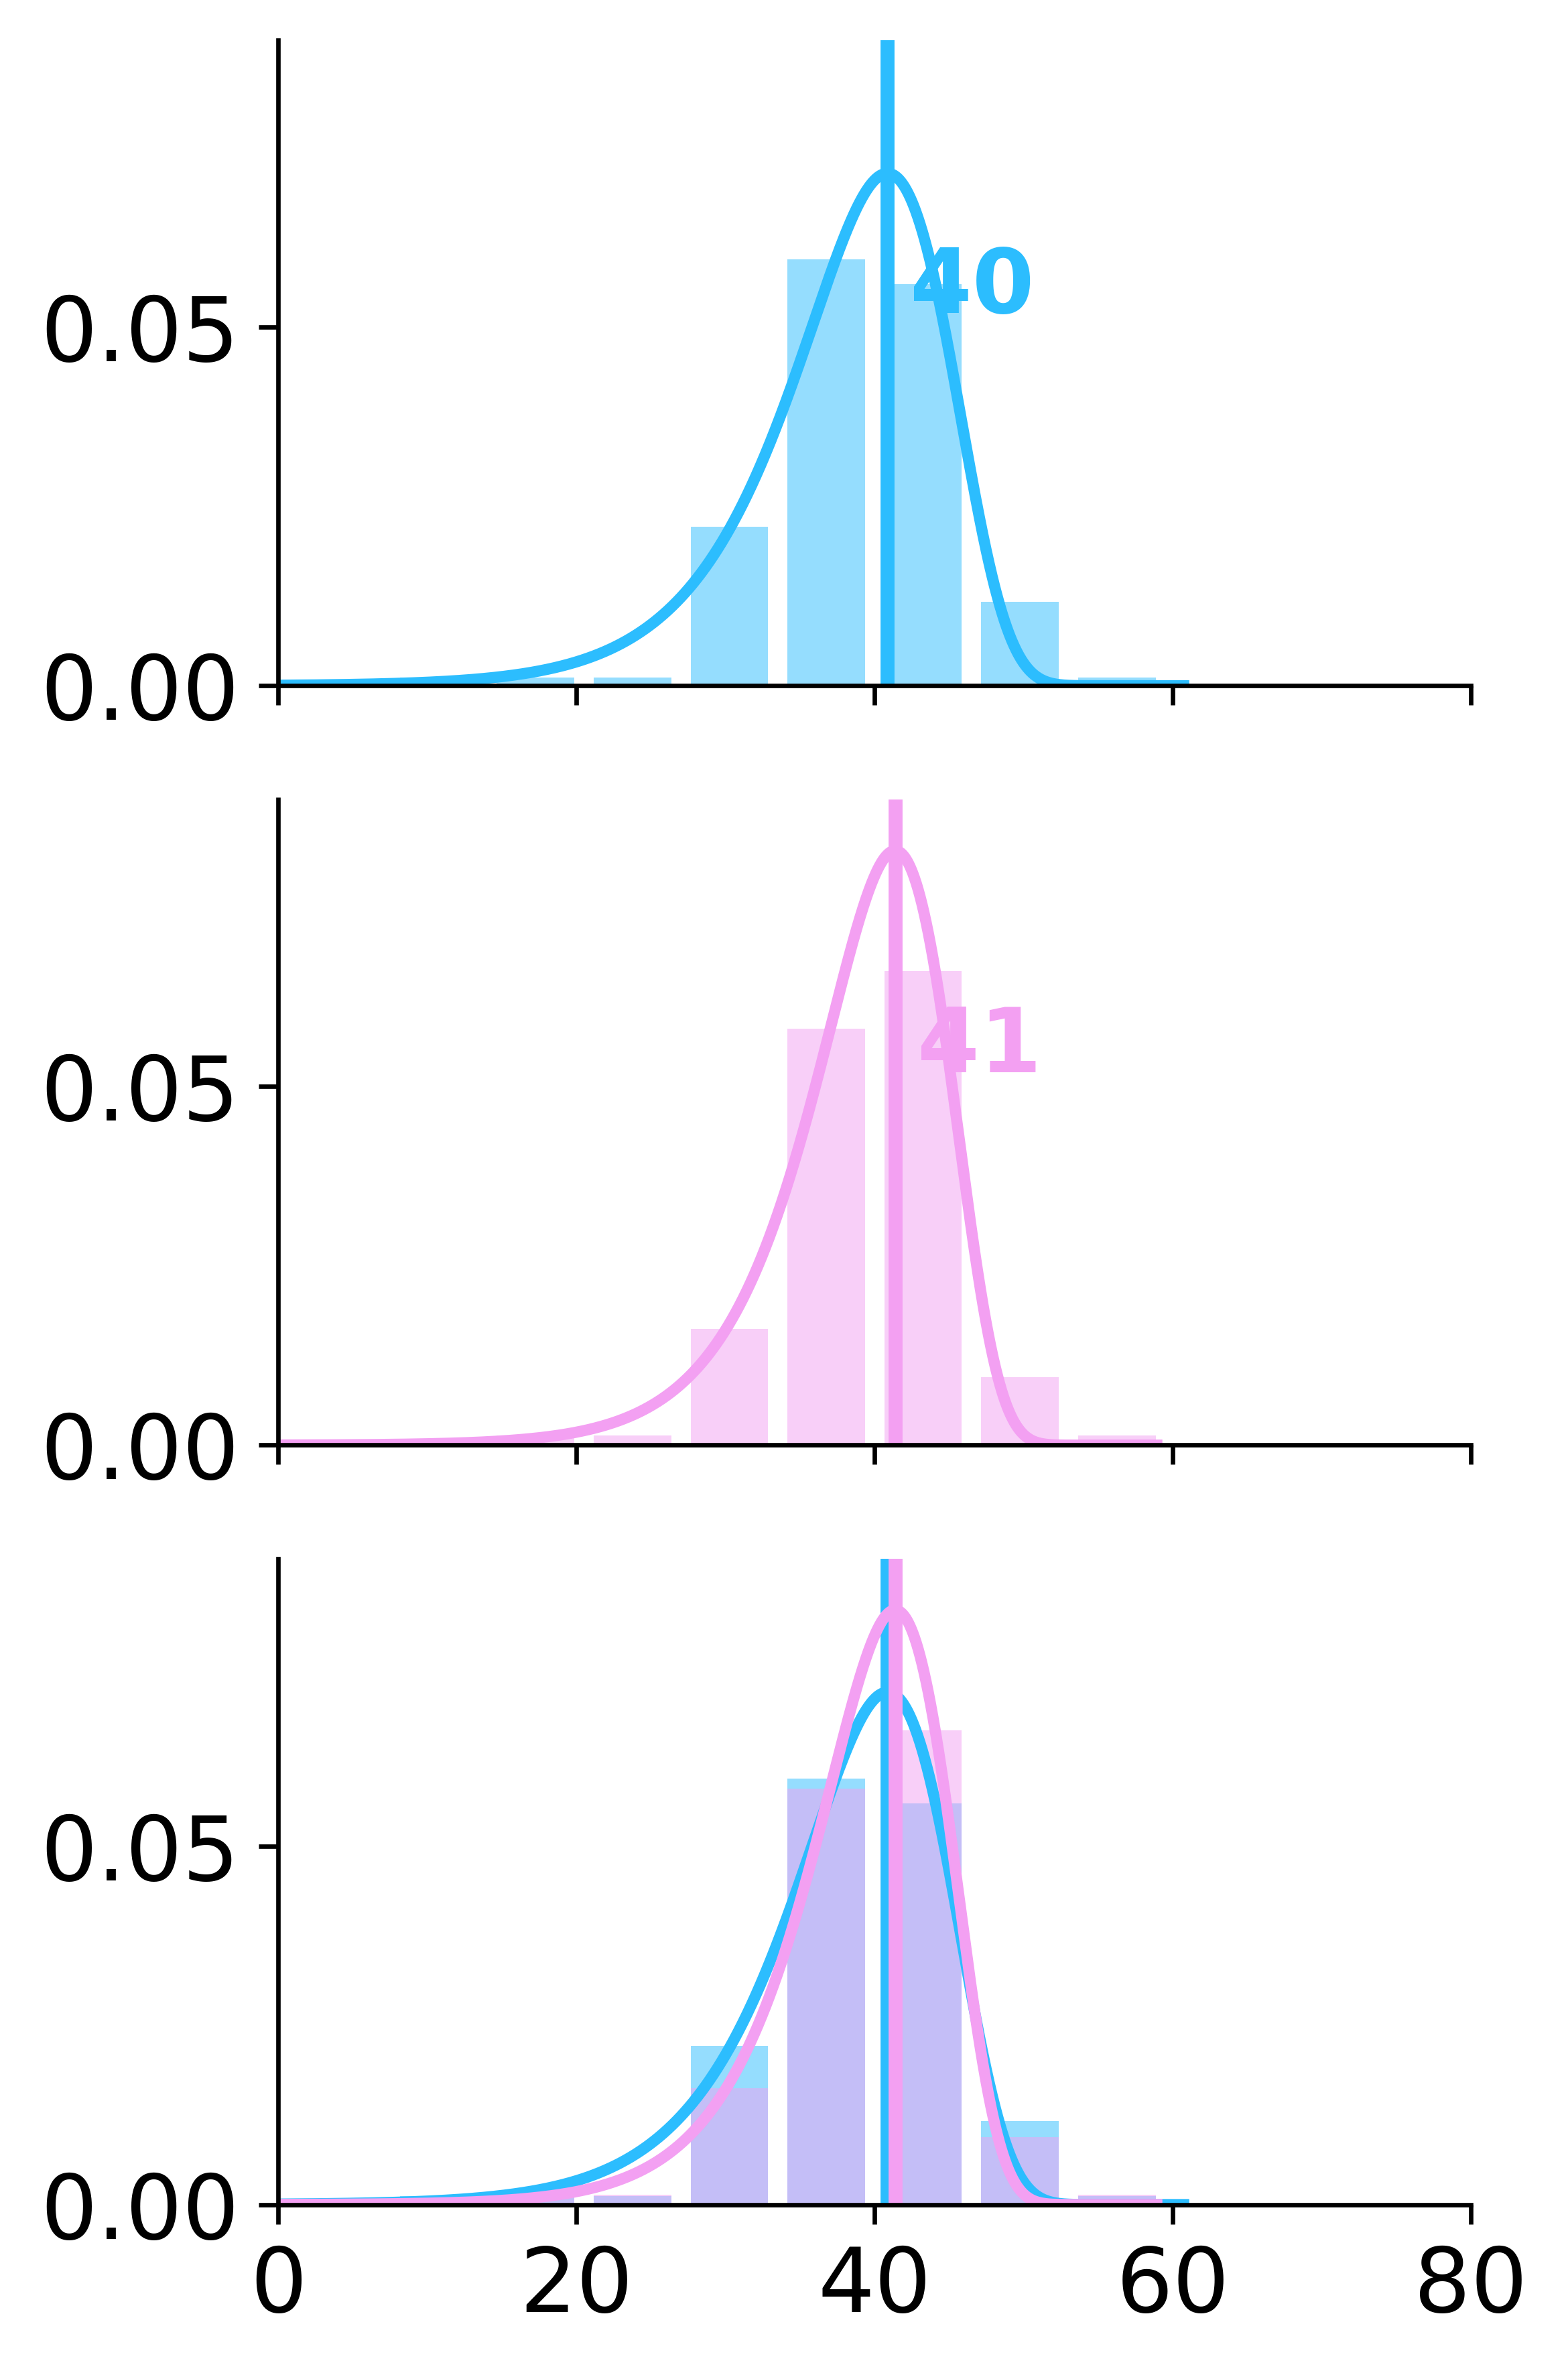

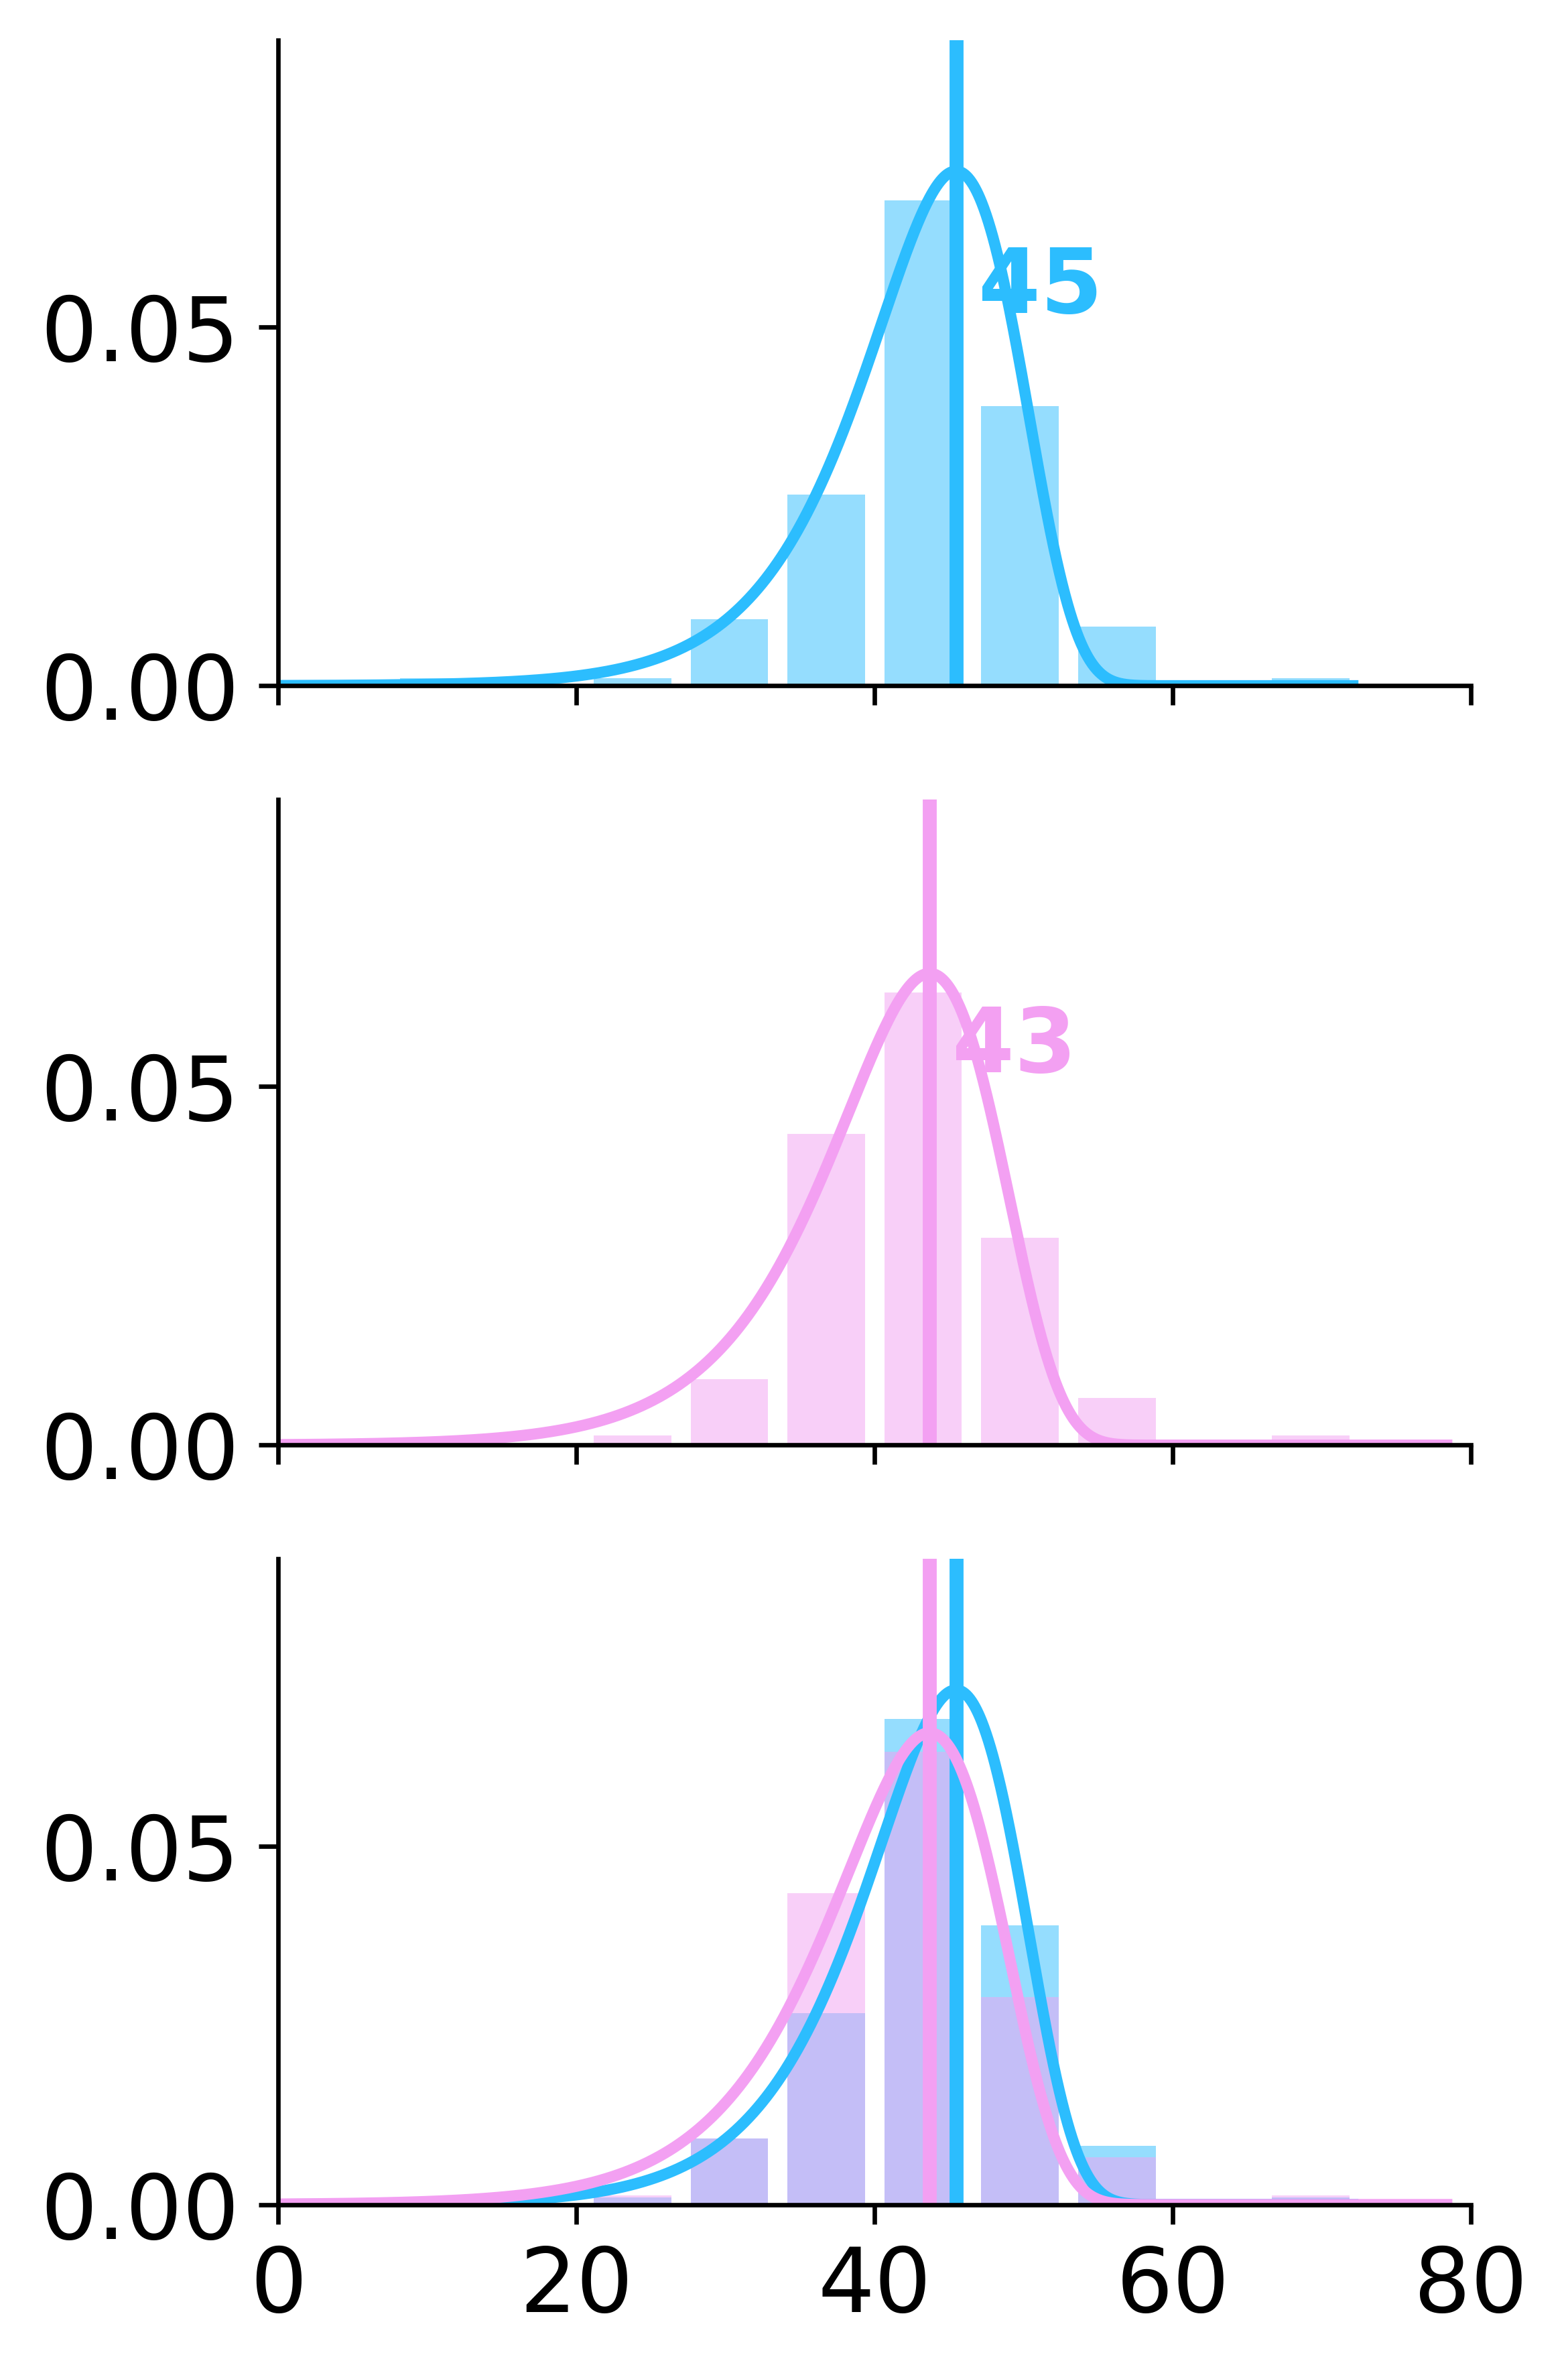

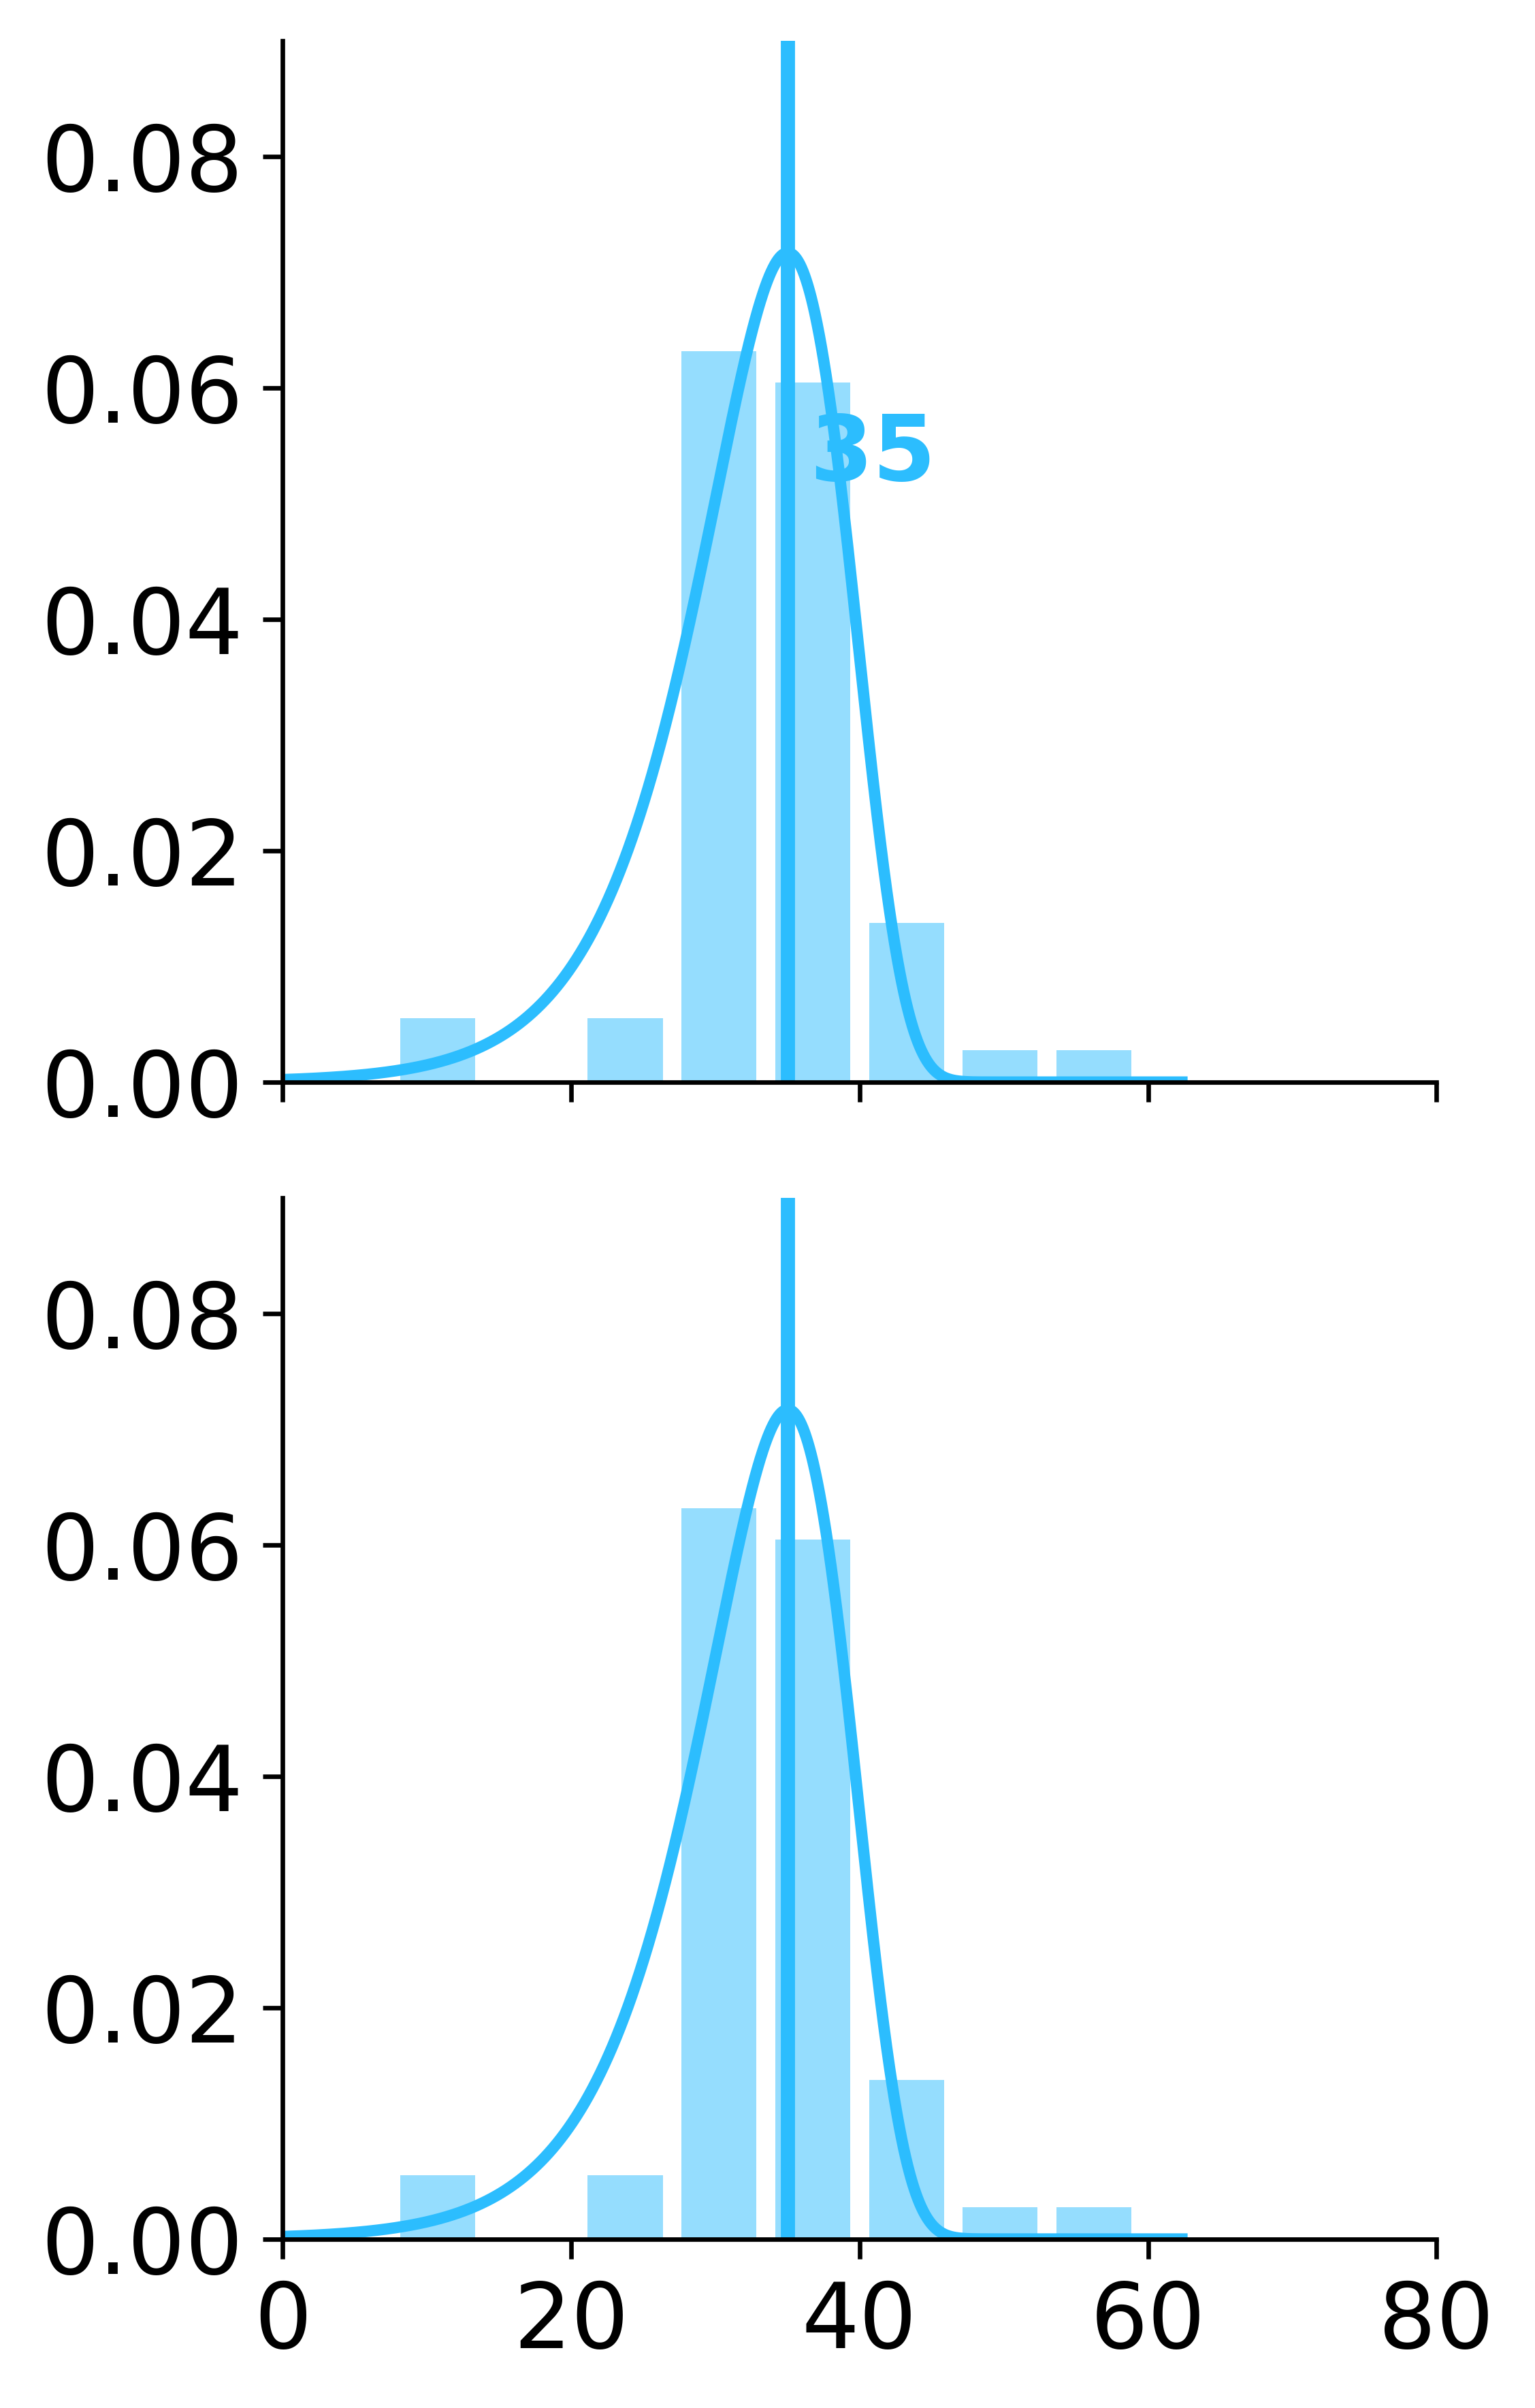

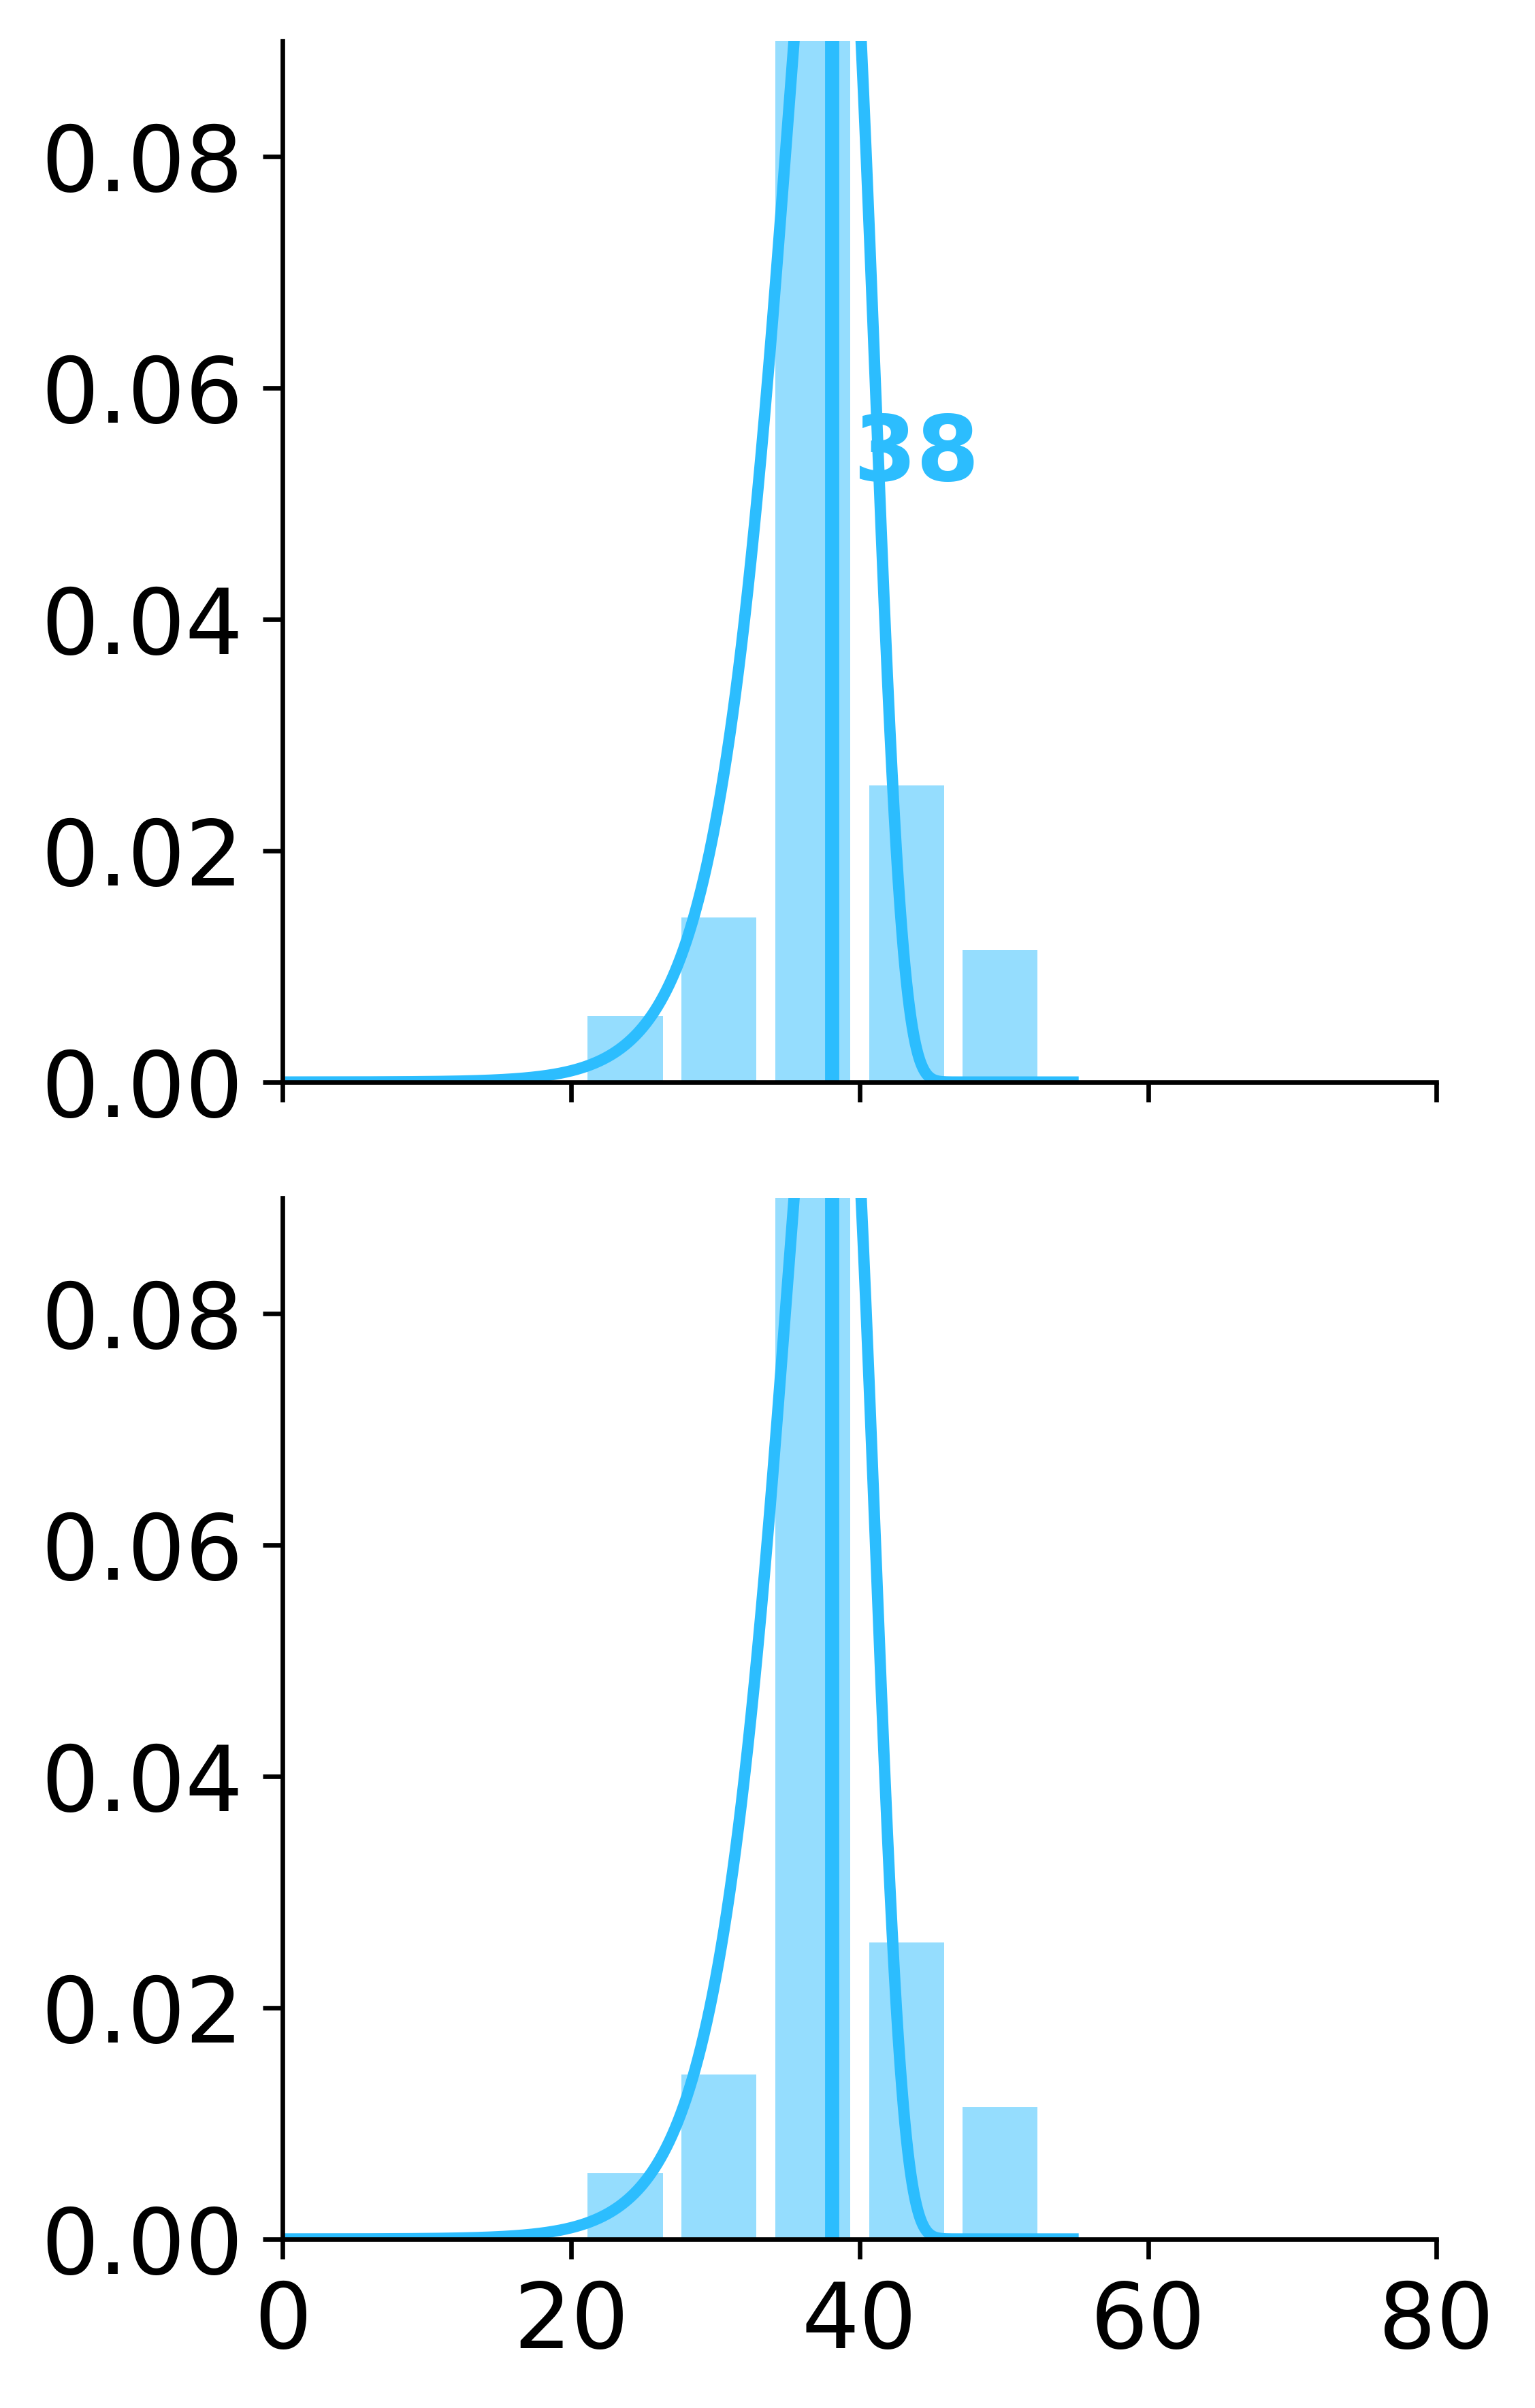

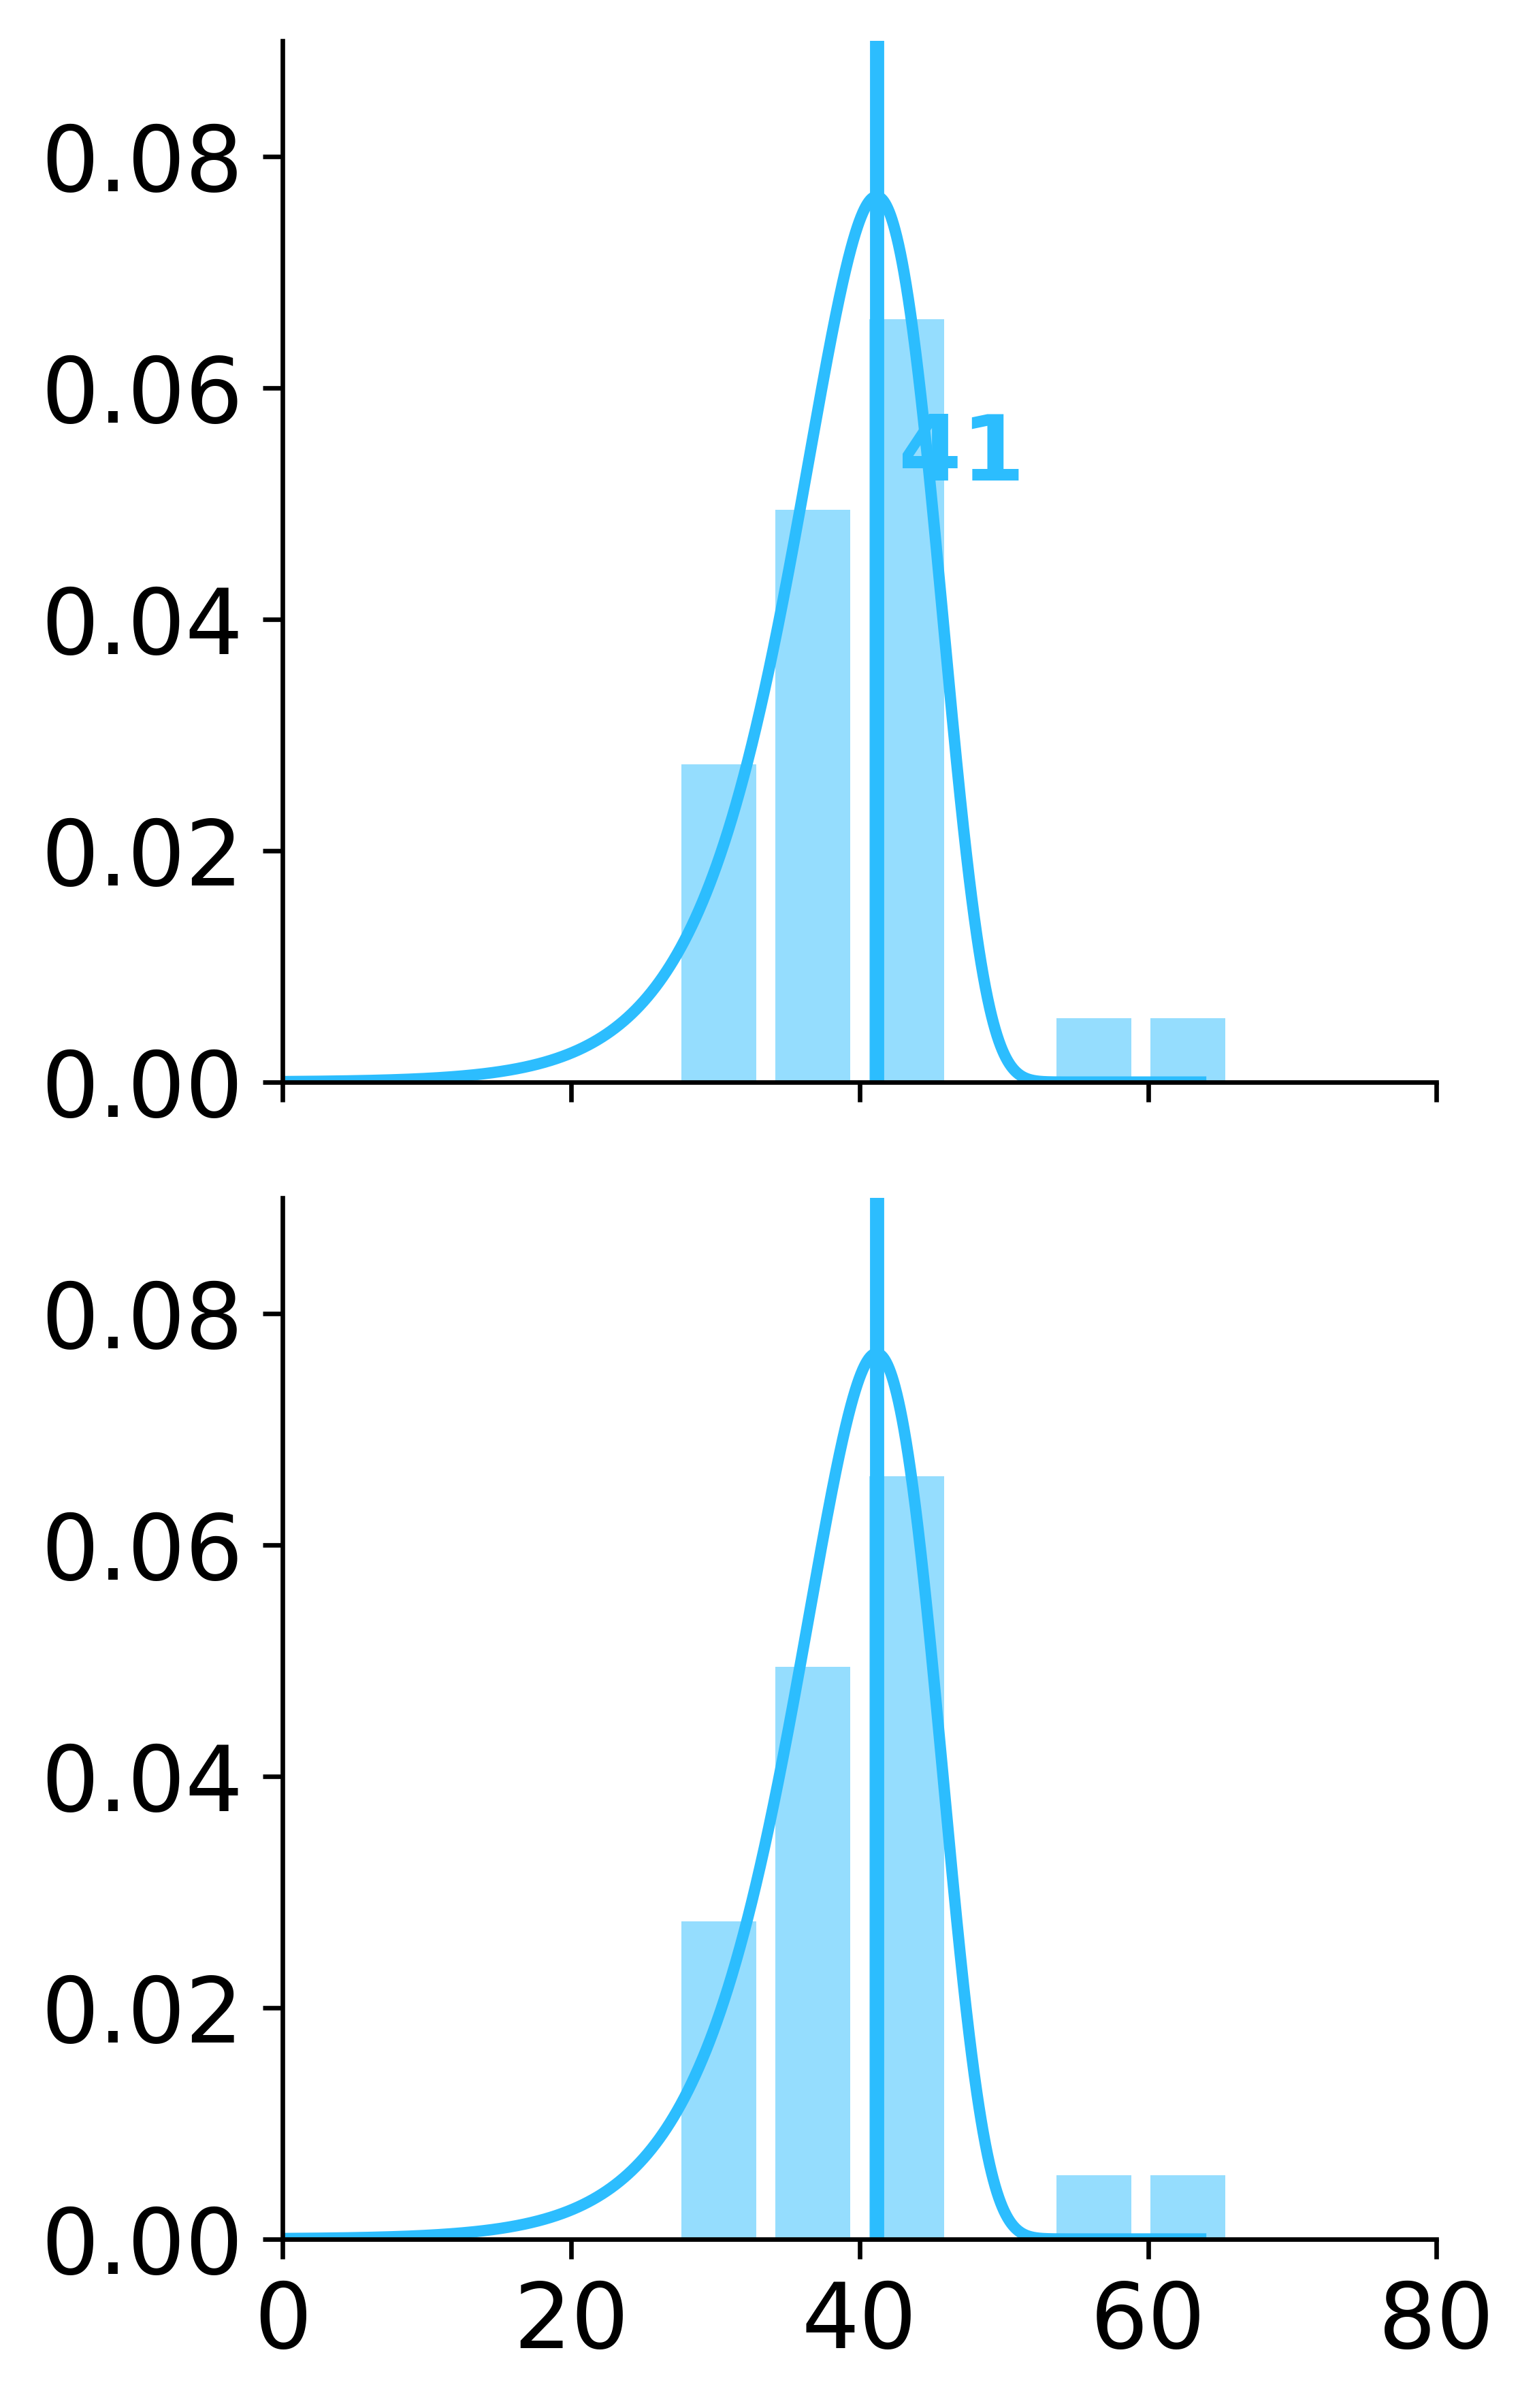

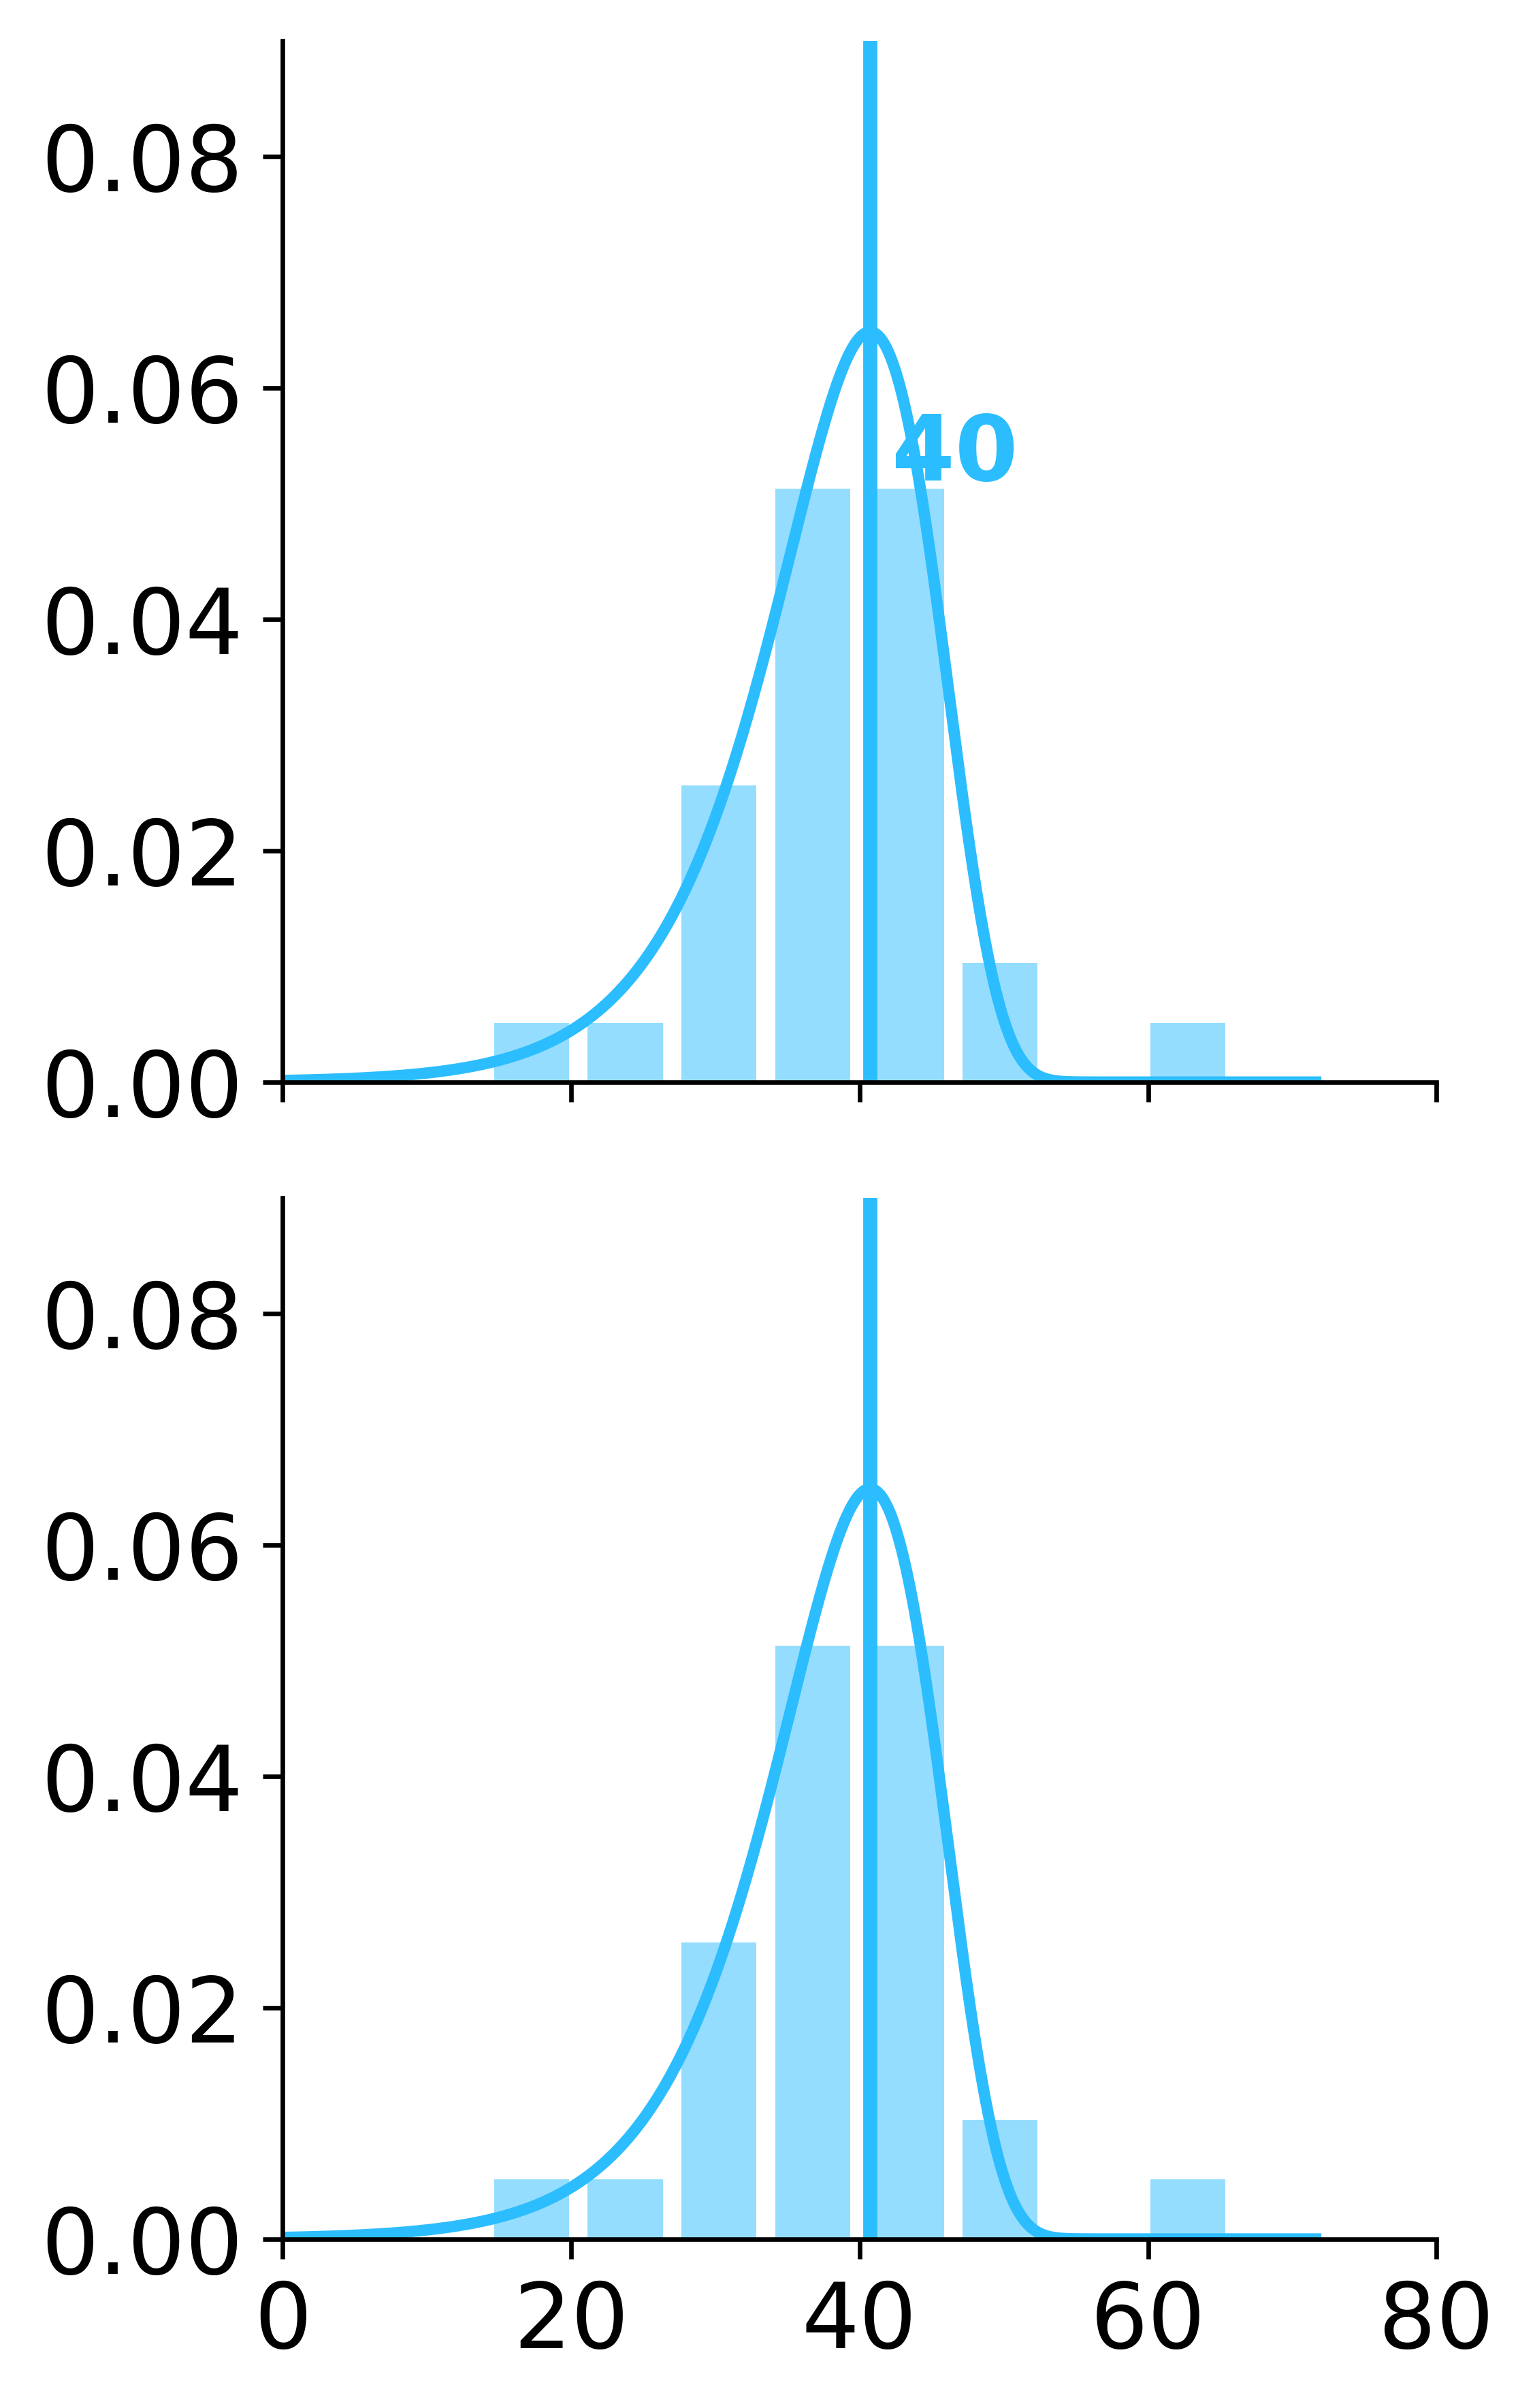

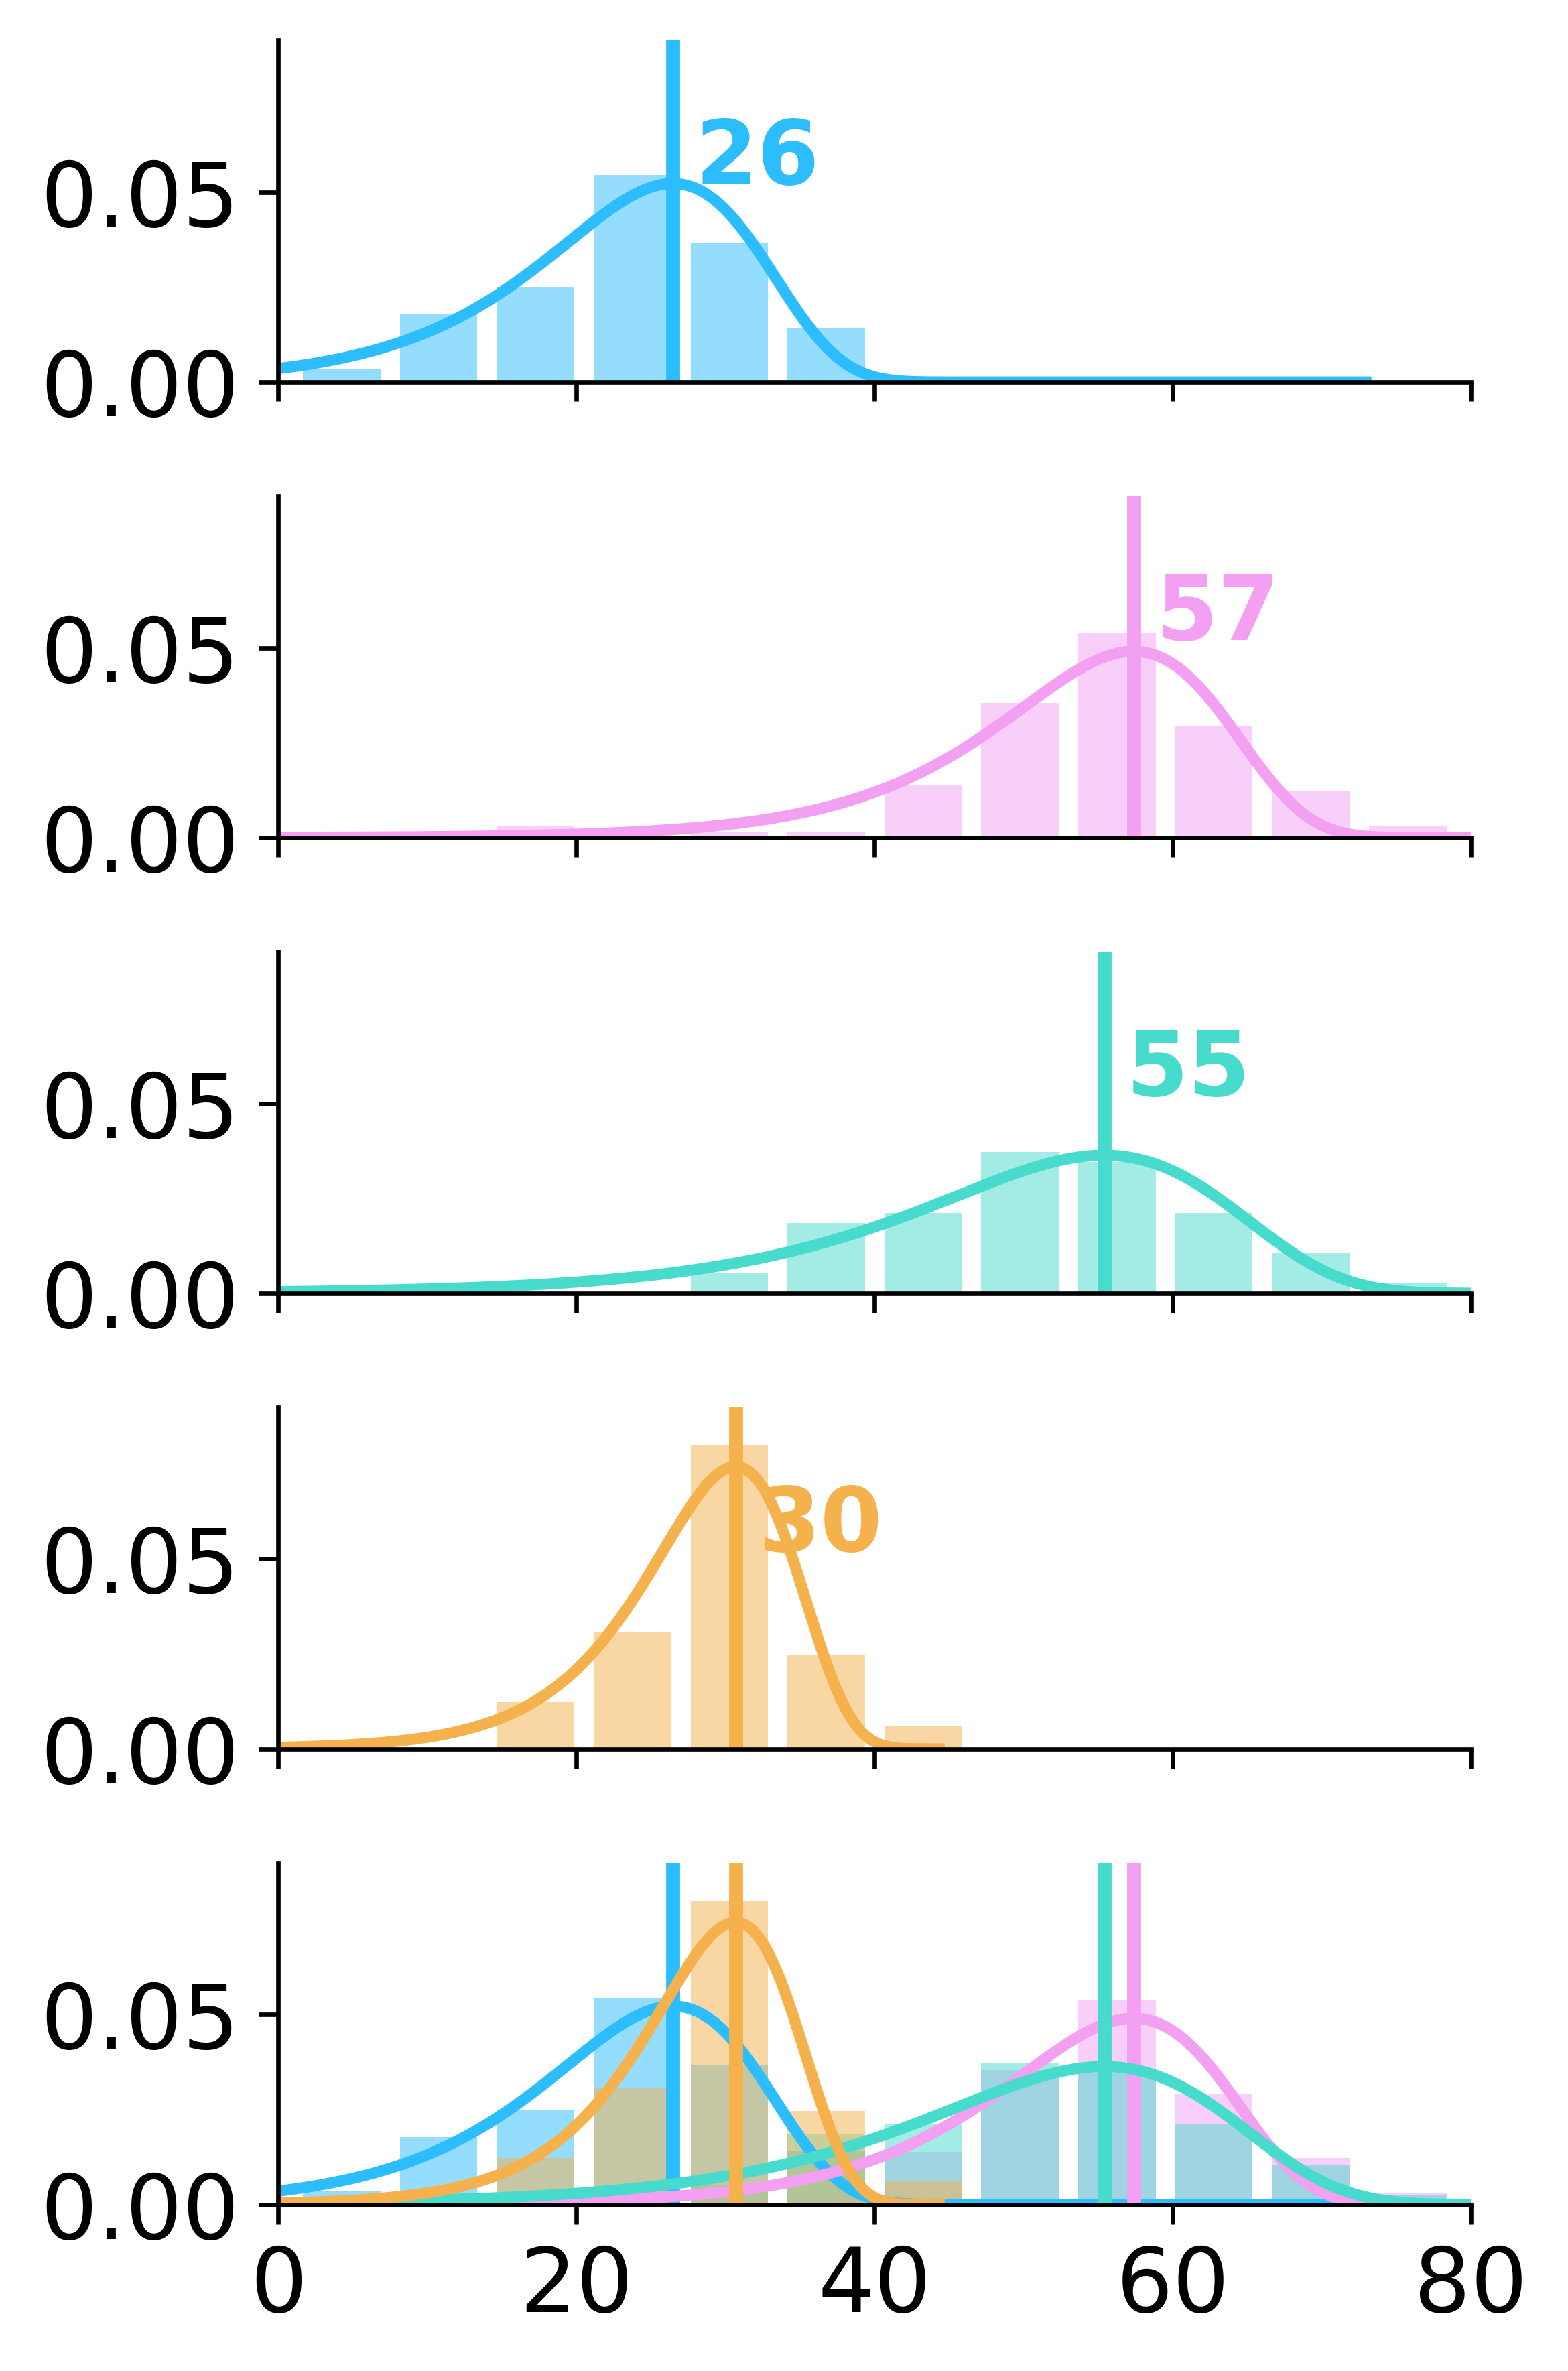

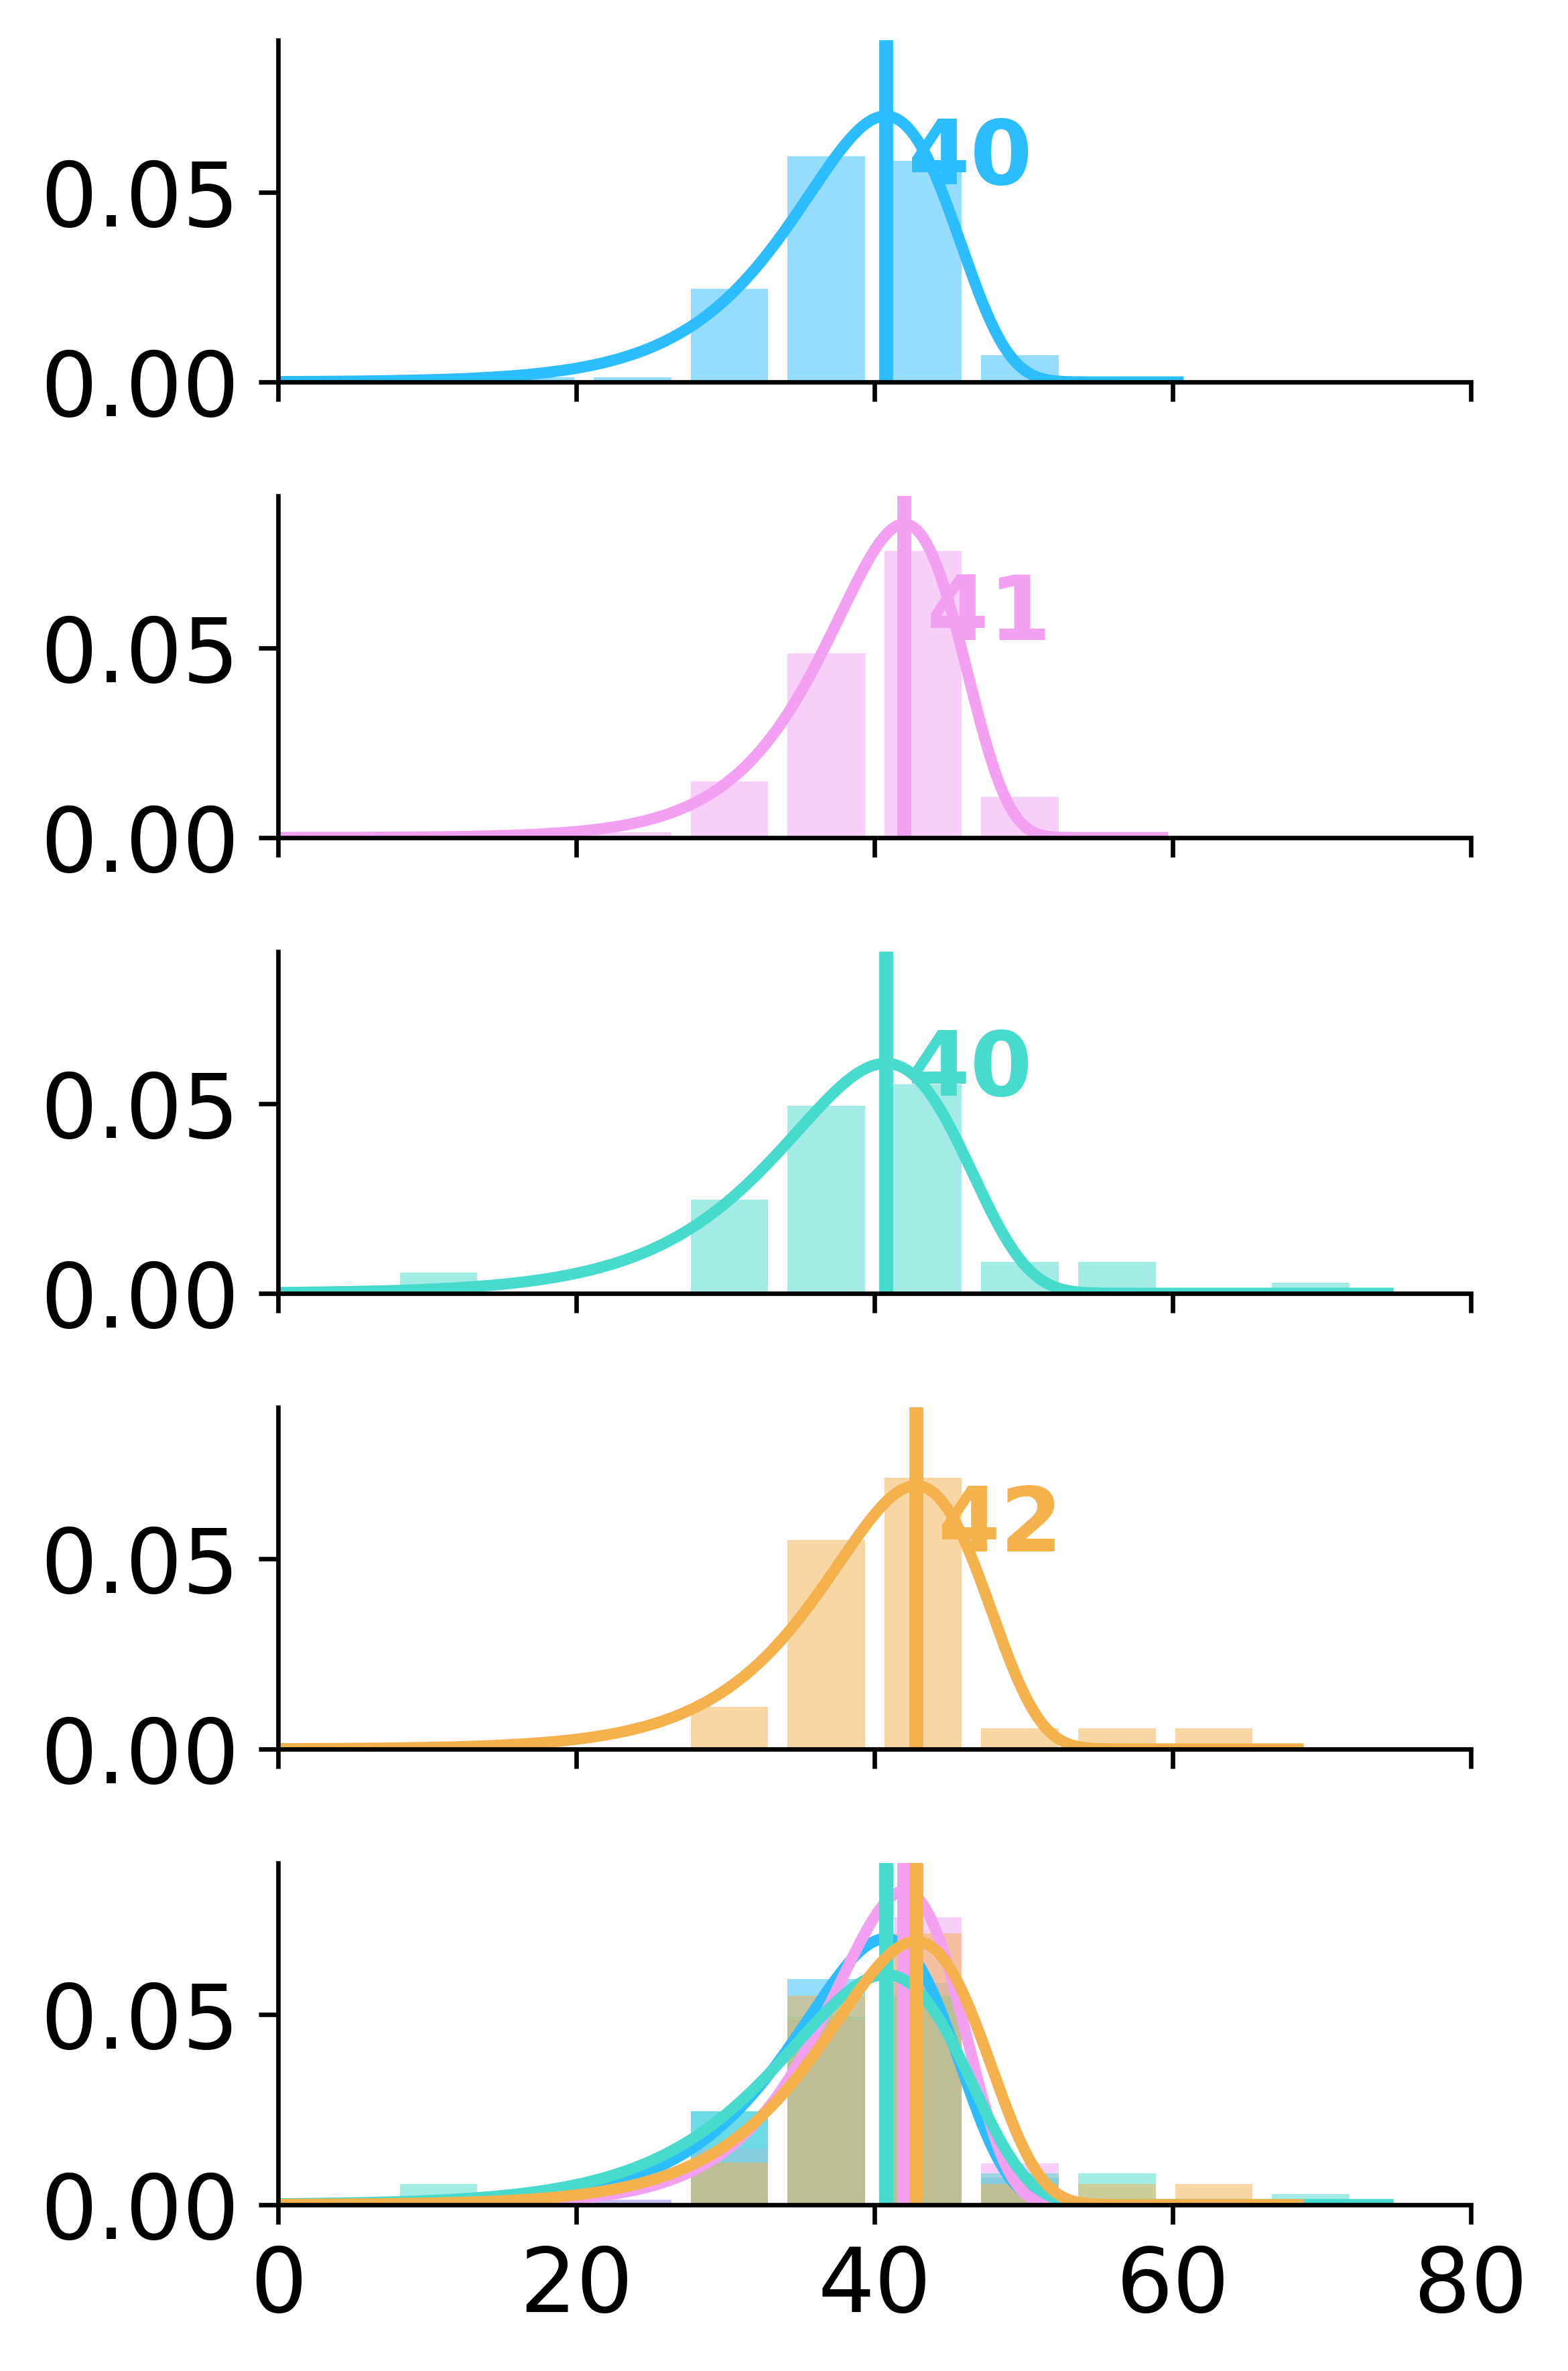

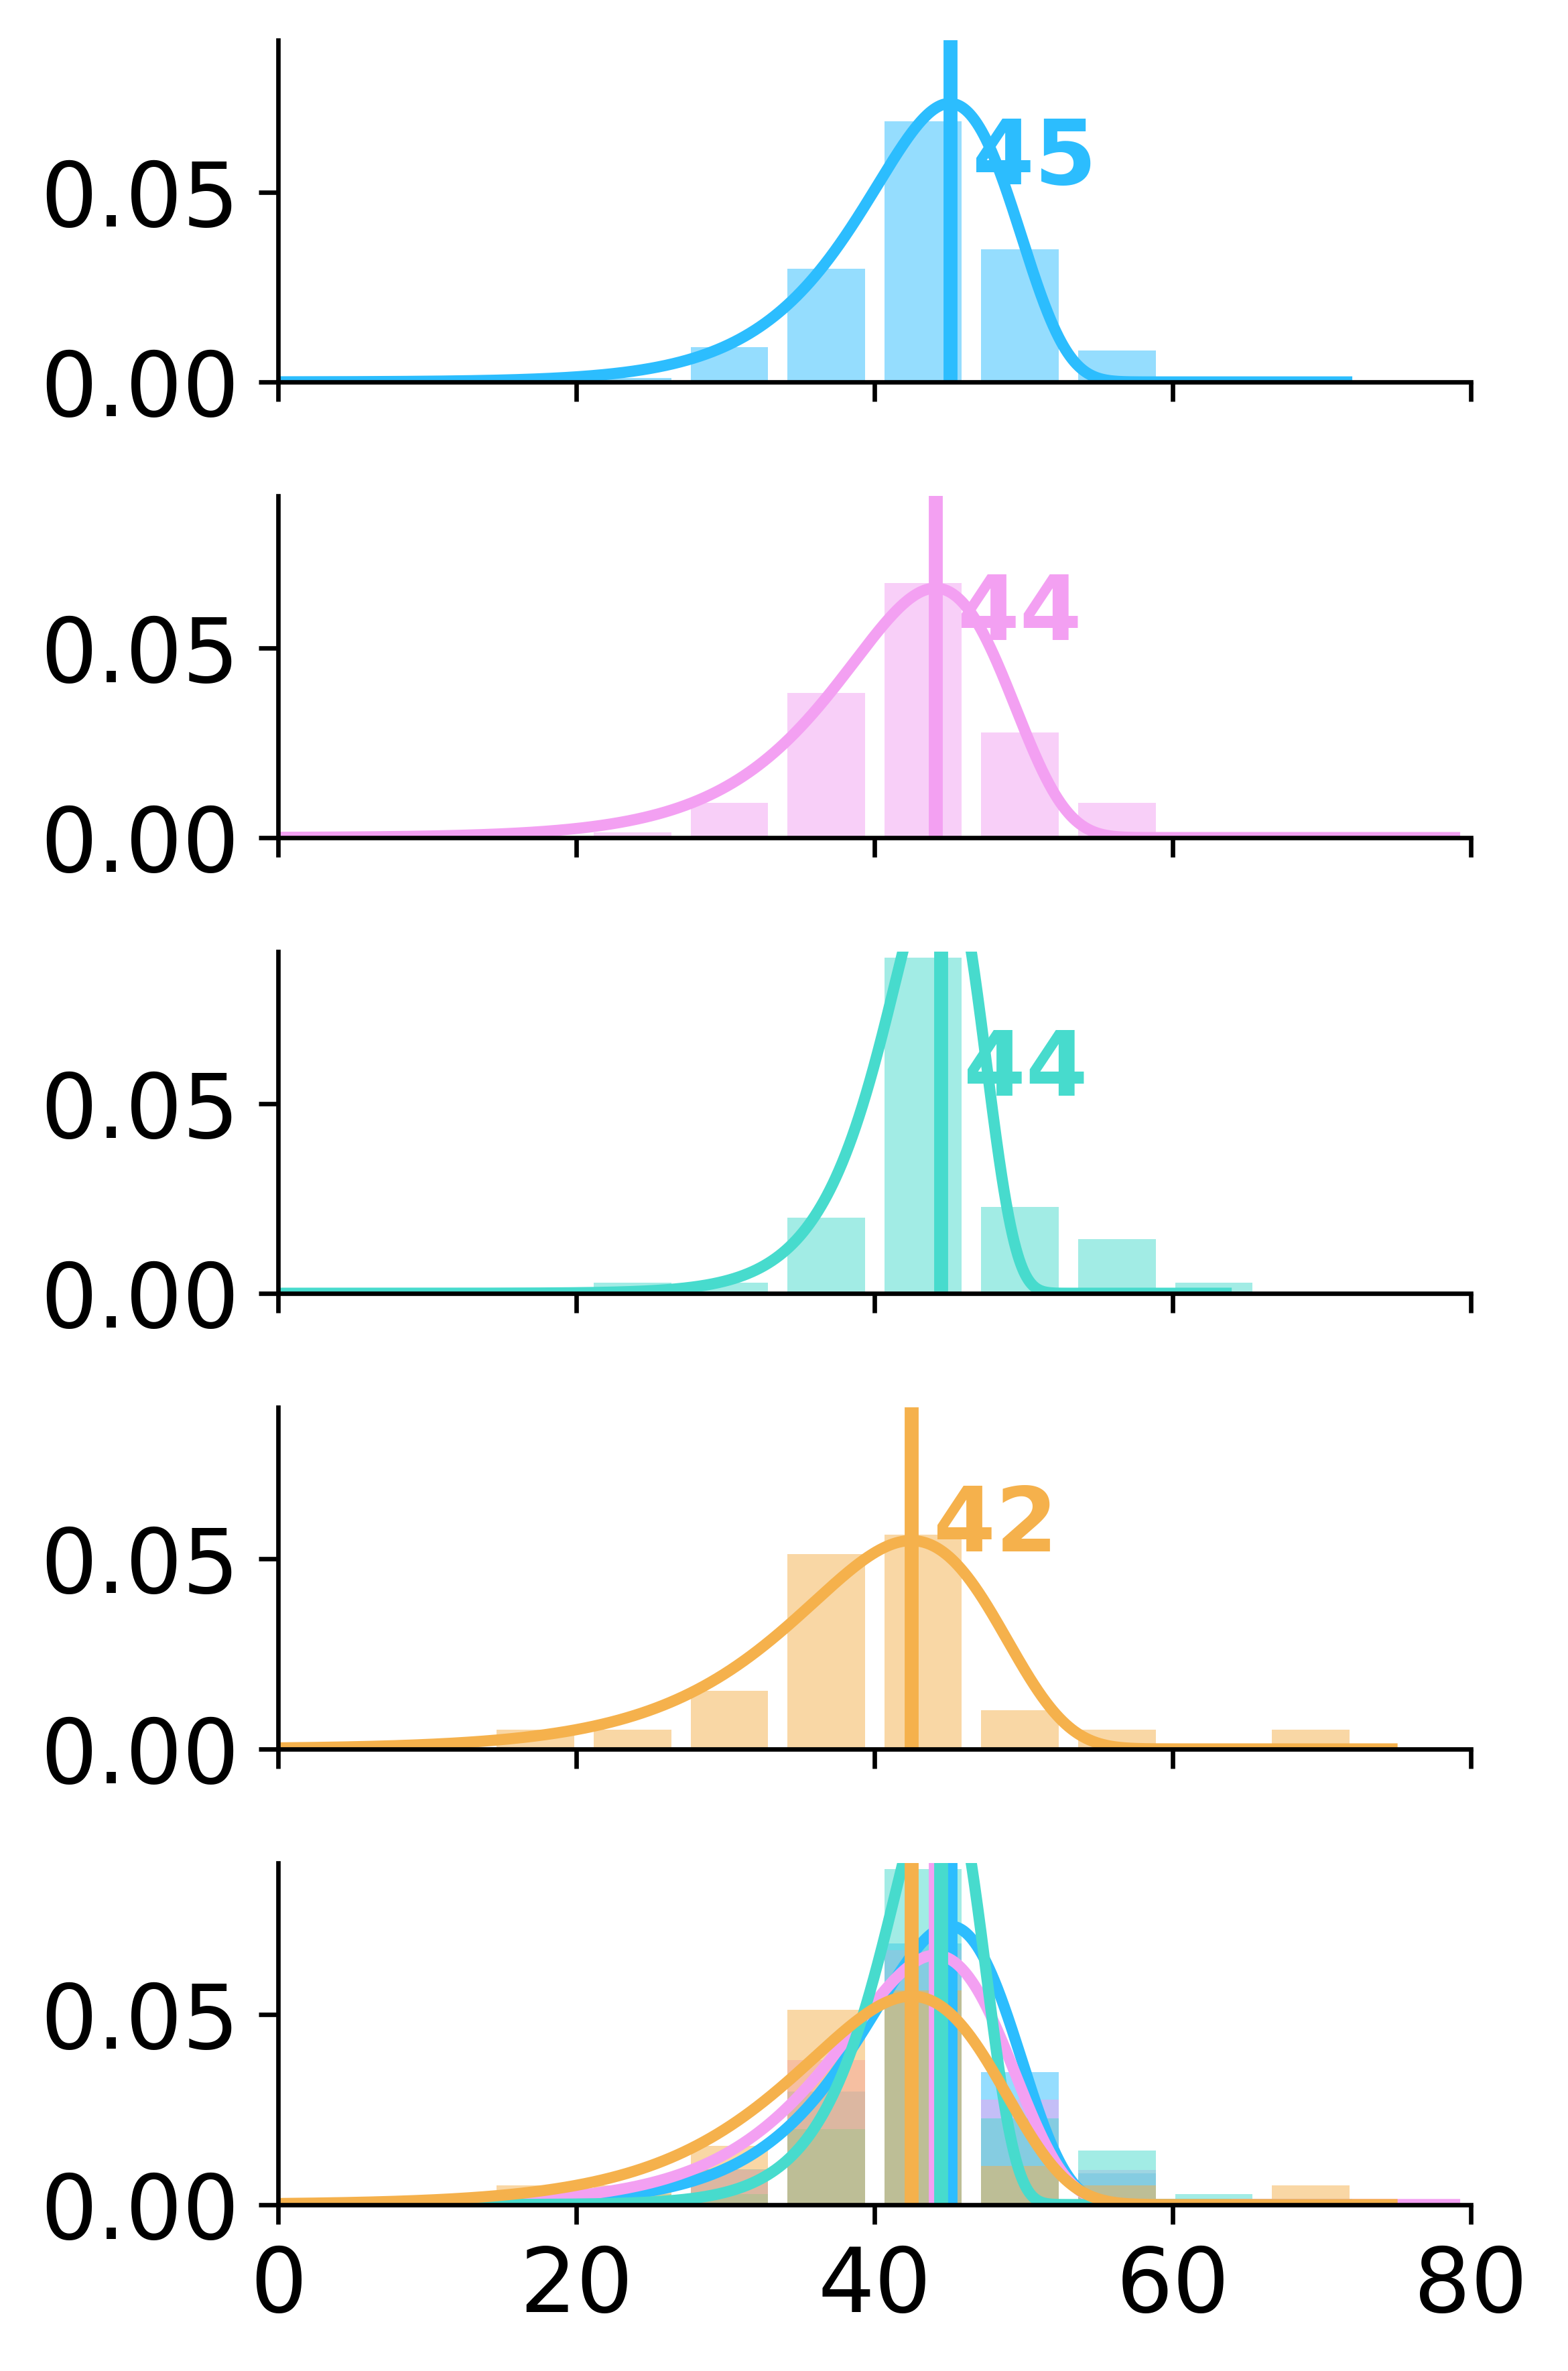

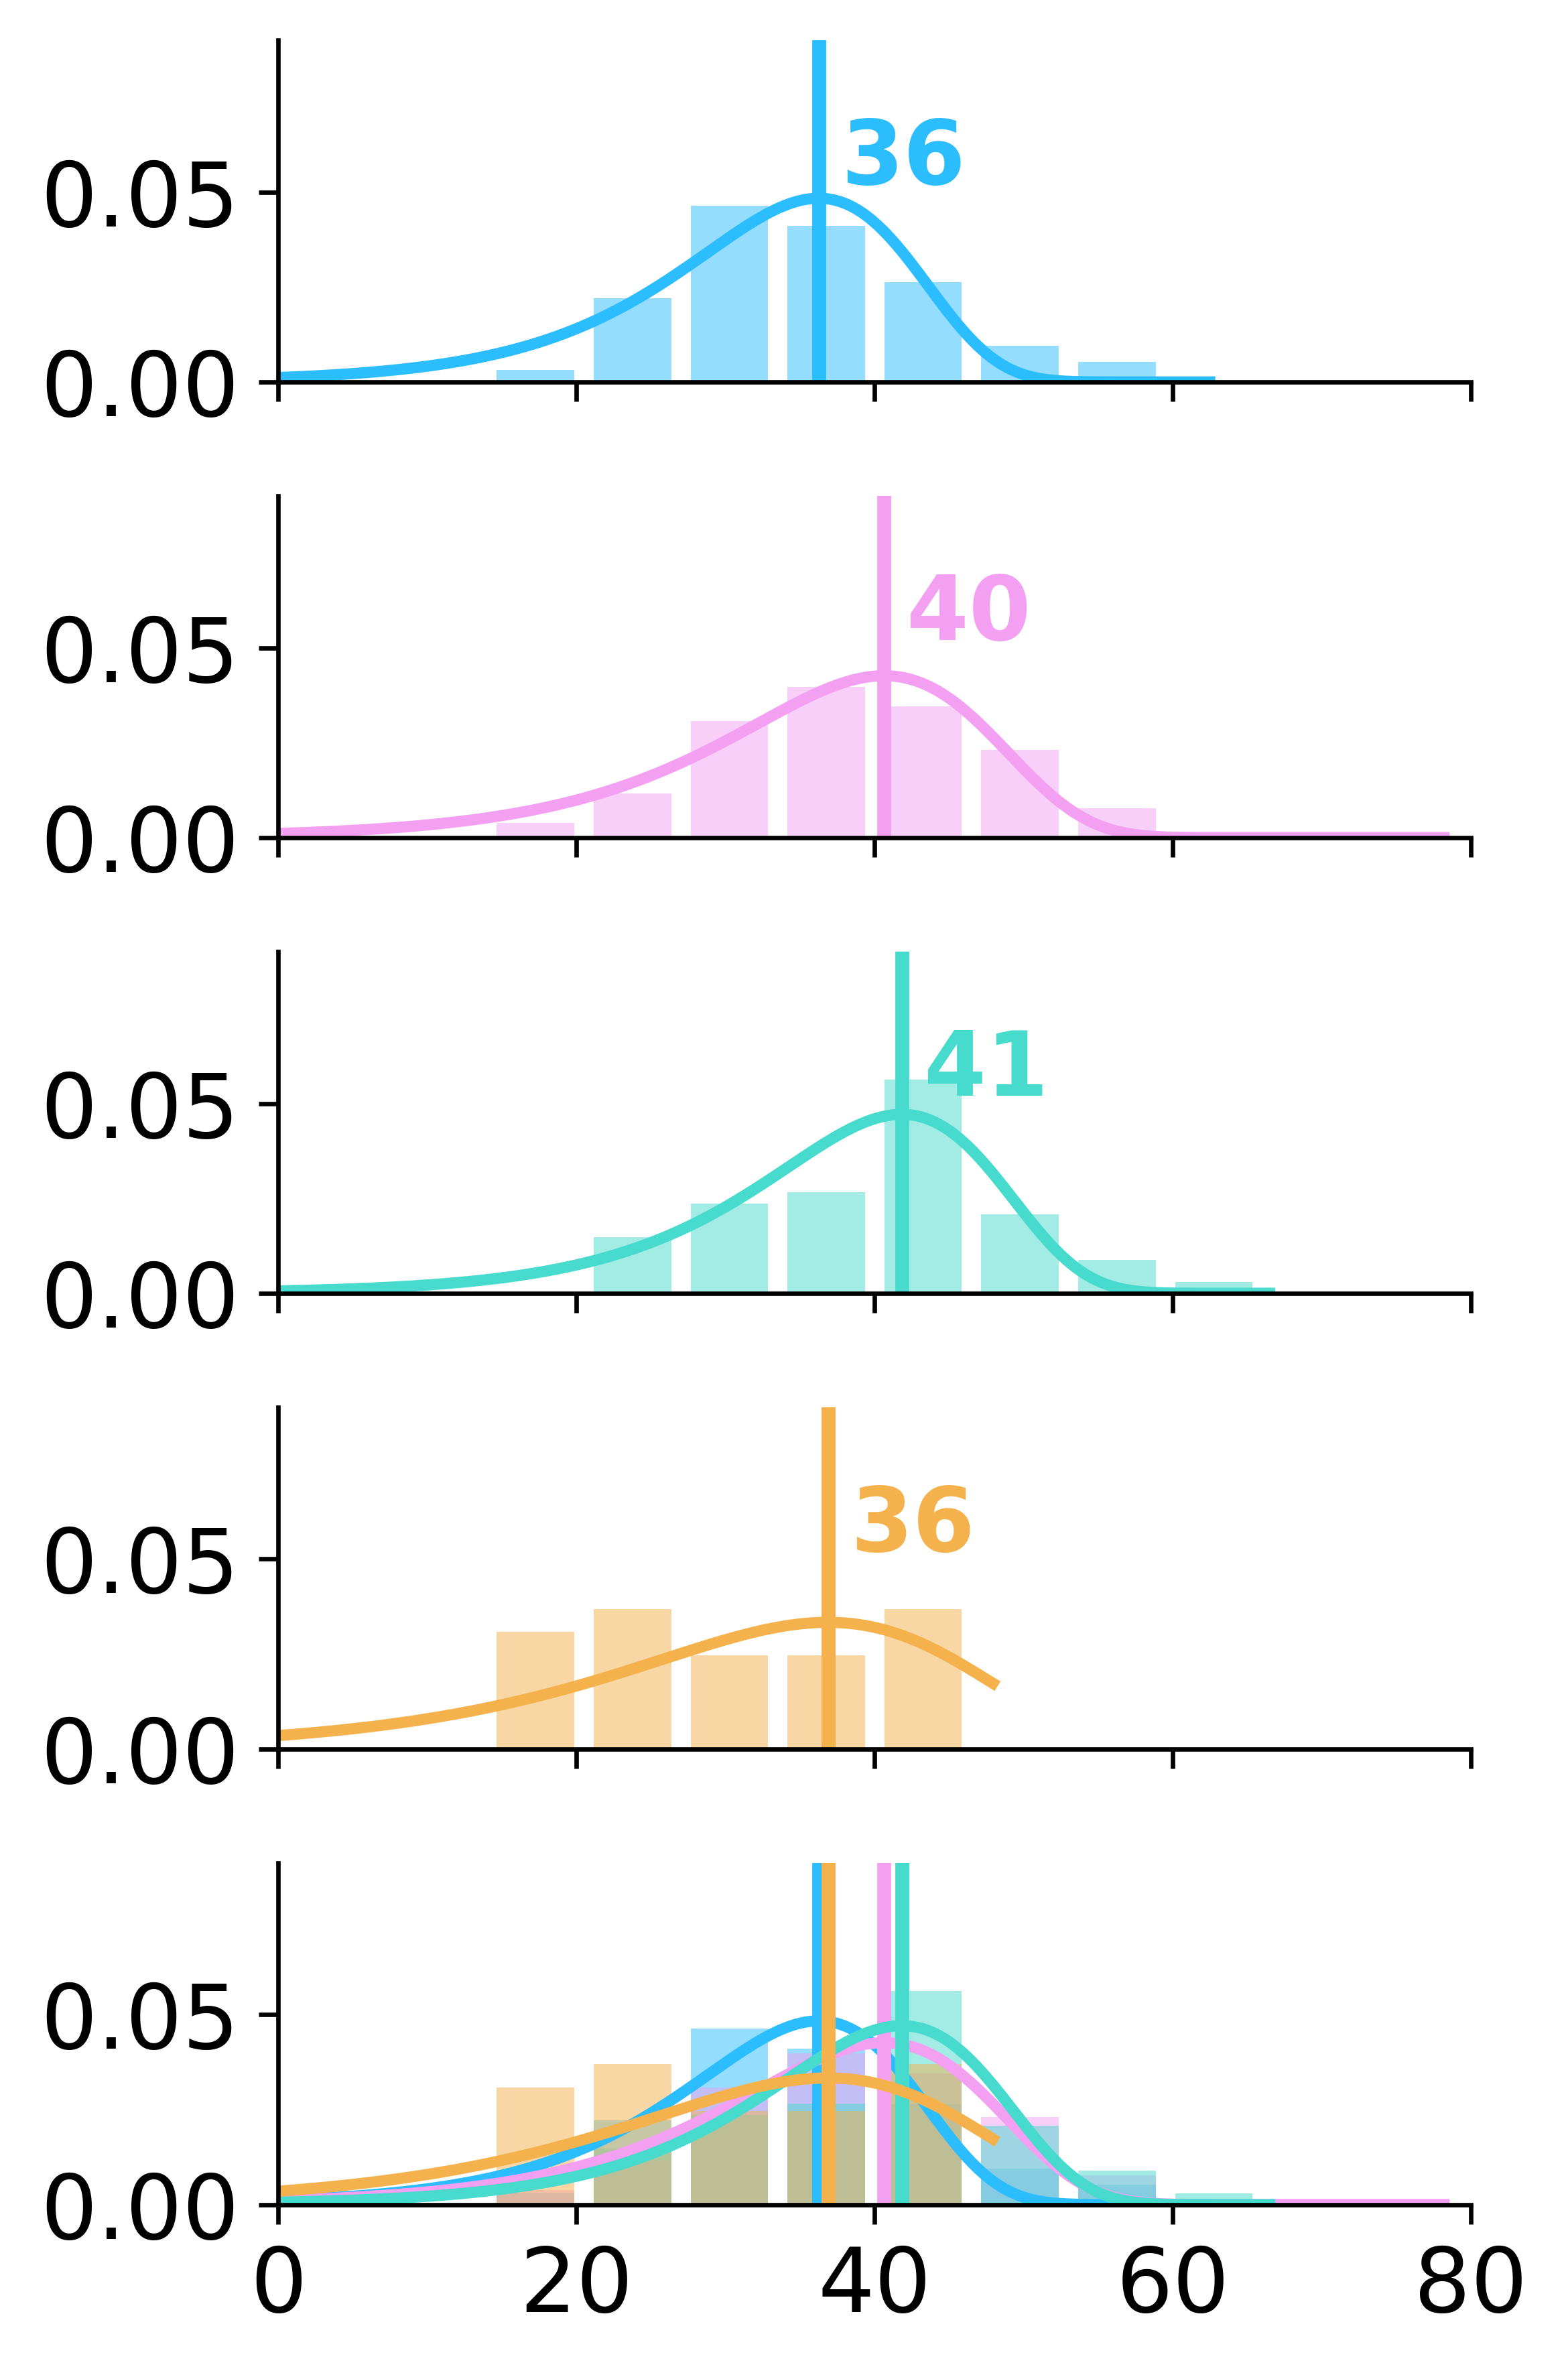

In [ ]:
listofmes=[A2S1_1,A2S2]#,A2S2_dyn_800]#,B117,P1,B1351,Delta]#,E484K,K417N,K417T,N501YE484K]

offs={}
for peak_it in [[b'ACE2_1']]:#,"p2","p3"]:
     p1mps=force_hists(peak_it, [iterate_peaks(x,peak_it,"f") for x in listofmes ],[iterate_peaks(x,peak_it,"lr") for x in listofmes ])
        
for peak_it in [[b'ACE2_2']]:#,"p2","p3"]:
     p2mps=force_hists(peak_it, [iterate_peaks(x,peak_it,"f") for x in listofmes ],[iterate_peaks(x,peak_it,"lr") for x in listofmes ])

listofmes=[A2S2_dyn_800]
for peak_it in [[b'ACE2_1']]:#,"p2","p3"]:
     p1mpsdyn=force_hists(peak_it, [iterate_peaks(x,peak_it,"f") for x in listofmes ],[iterate_peaks(x,peak_it,"lr") for x in listofmes ])
        
for peak_it in [[b'ACE2_2']]:#,"p2","p3"]:
     p2mpsdyn=force_hists(peak_it, [iterate_peaks(x,peak_it,"f") for x in listofmes ],[iterate_peaks(x,peak_it,"lr") for x in listofmes ])

listofmes=[A2S1_long_1]
for peak_it in [[b'ACE2_1']]:#,"p2","p3"]:
     p1mpslong=force_hists(peak_it, [iterate_peaks(x,peak_it,"f") for x in listofmes ],[iterate_peaks(x,peak_it,"lr") for x in listofmes ])
        
for peak_it in [[b'ACE2_2']]:#,"p2","p3"]:
     p2mpslong=force_hists(peak_it, [iterate_peaks(x,peak_it,"f") for x in listofmes ],[iterate_peaks(x,peak_it,"lr") for x in listofmes ])


p1offs=[]
pdynoffs=[]
for idx,i in enumerate(p1mps):
    #p1offs.append(((i-np.mean(p1mps))+(p2mps[idx]-np.mean(p2mps)))/2)
    p1offs.append(((np.mean(p1mps)/i)+(np.mean(p2mps)/p2mps[idx]))/2)
    if idx == 0:
      pdynoffs.append((((np.mean(p1mps)/np.mean(p1mpsdyn))+(np.mean(p2mps)/np.mean(p2mpsdyn))))/2)
      pdynoffs.append((((np.mean(p1mps)/np.mean(p1mpslong))+(np.mean(p2mps)/np.mean(p2mpslong))))/2)
#     p1offs.append(i-np.mean(p1mps))
print("pdoffs",pdynoffs)

p1offs.append(pdynoffs[0])
p1offs.append(pdynoffs[1])

# offs["p1"]=p1offs
    
listofmes=[A2S1_1,A2S2,A2S2_dyn_800,A2S1_long_1]

for peak_it in [[b'RBD'],[b'ACE2_1'],[b'ACE2_2'],[b'ACE2_3']]:
    #p1mps=force_hists( [iterate_peaks(x,peak_it,"f")-offs[idx] for idx,x in enumerate(listofmes) ],[iterate_peaks(x,peak_it,"lr") for x in listofmes ])
    p0mps=force_hists(peak_it, [iterate_peaks(x,peak_it,"f")*p1offs[idx] for idx,x in enumerate(listofmes) ],[iterate_peaks(x,peak_it,"lr")*p1offs[idx] for idx,x in enumerate(listofmes) ])



####################################
####################################
 ========= N-terminus ===========
raw_speeds ['0400', '0800', '1600', '3200']
### 0 0400 ####
 Cleared 1 - zero loading rate element(s)
extend max hist p_F to  0.060058287782960525
------ [RESULTS v=0400] ------
  most prob. loading rate +- sigma =   1141 pN/s -    429 +  510.7 pN/s
  Most probable rupture Force =  49.97 pN 
  deltax = 0.6499 nm
  koff0 = 0.0704 s^-1
scat
### 1 0800 ####
 Cleared 1 - zero loading rate element(s)
------ [RESULTS v=0800] ------
  most prob. loading rate +- sigma =   2593 pN/s -   1827 +   1249 pN/s
  Most probable rupture Force =  55.04 pN 
  deltax = 0.4186 nm
  koff0 =  1.006 s^-1
scat
### 2 1600 ####
------ [RESULTS v=1600] ------
  most prob. loading rate +- sigma =   4753 pN/s -   3294 +   3205 pN/s
  Most probable rupture Force =  60.11 pN 
  deltax = 0.6226 nm
  koff0 = 0.08511 s^-1
scat
### 3 3200 ####


findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


------ [RESULTS v=3200] ------
  most prob. loading rate +- sigma =   9531 pN/s -   7797 + 1.055E+04 pN/s
  Most probable rupture Force =  62.68 pN 
  deltax = 0.4865 nm
  koff0 = 0.7107 s^-1
scat
 - BE all  -   x0=0.669084 nm , k_off=0.0555561 1/s 

 Fitterror in +- ERR_x0=0.0639471 (0.096) nm, ERR_k_off=0.0437354 1/s (0.787) 


findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


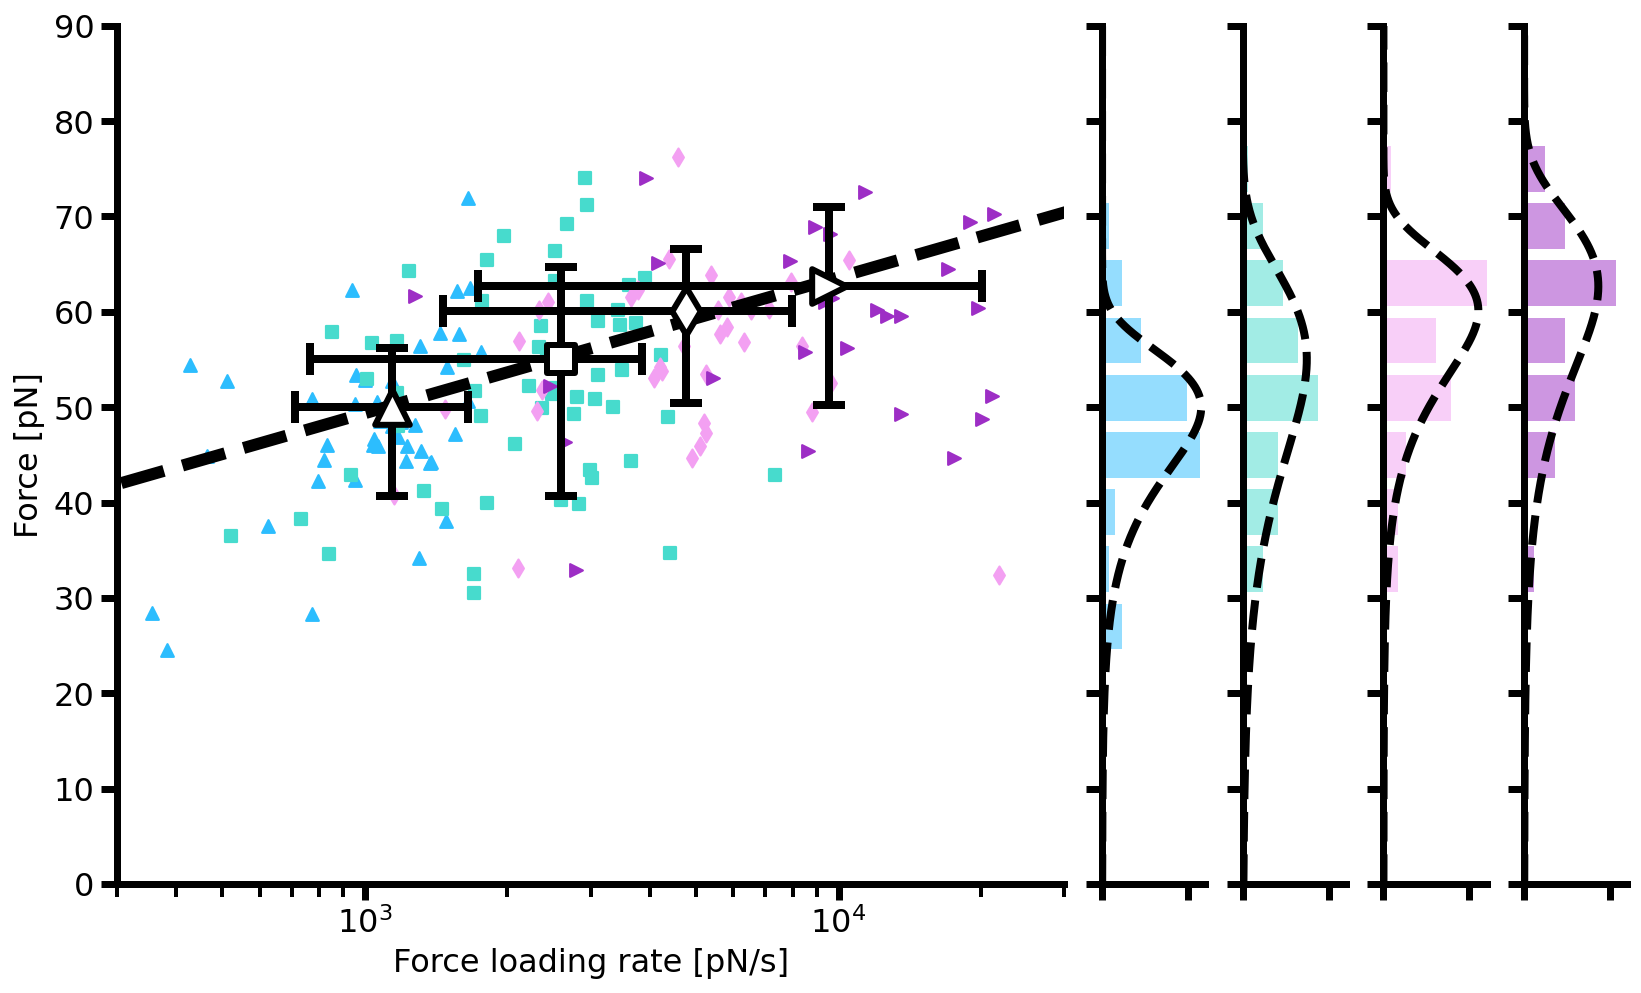

In [ ]:
# execfile("./_ipynb_lib_figures_bd.py")
# execfile("./_ipynb_dynfs_bd.py")

folder  = "_raw/"
savedir = "NC_dynfs/"

save_filename = "N_C"
_to_iterate = ["N-terminus"]



    
Npull = [
"400.txt" ,
"800.txt" ,
"1600.txt" ,
"3200.txt" ,
]


raw_speeds = ["0400", "0800", "1600", "3200"]


fig_h , fig_w = 7.69*1, 11.69*2
Blue = '#2CBDFE'
Green = '#47DBCD'
Pink = '#F3A0F2'
Purple = '#9D2EC5'
Violet = '#661D98'
Amber = '#F5B14C'
Clfa = '#E84E1B'
# colors_list = [ [get_lukas_colors()[0]]*9 ]
colors_list = [ [Blue,Green,Pink,Purple,Violet,Amber] ]
# print [get_lukas_colors()[0]]
markers    = ["^", 's', 'd', ">", 'o', "p" , "v" ] # "D", (5,0)
linestyles = [ "--", "-.", "-", "-."]

fit_ = 1

guesses_list = [ 
    [ [0.21e-9, 0.06], [0.2e-9, 1.0e-3], [0.2e-9, 0.06], ] ,
    [ [0.3e-9, 1.0e-3], [0.3e-9, 1.0e-4], [0.4e-9, 1.0e-1], ]     ]

lrminmaxs     = [[300.0e-12, 3.0e4*1.0e-12], [300.0e-12, 3.0e4*1.0e-12] ]
f_thresholds  = [10.0e-12  , 10.0e-12 ]
fmins =         [0.0e-12   , 0.0e-12 ]
fmaxs =         [90.0e-12 , 90.0e-12 ]
binwidths =     [6.0e-12 , 6.0e-12 ]

extra_args = [ 1 ,]

fontsize, fontsize_ticks, fontsize_labels, fontsize_legend = ( 16, 16, 16, 16)
fontsize_array = [fontsize, fontsize_ticks, fontsize_labels, fontsize_legend]


fig_h , fig_w = 7, 11.5

peak=[b"RBD"]
_to_iterate_data=[]
data=[ [iterate_peaks(x,peak,"f")*p1offs[2],iterate_peaks(x,peak,"lr")*p1offs[2]] for x in [A2S2_dyn_400,A2S2_dyn_800,A2S2_dyn_1600,A2S2_dyn_3200] ]
_to_iterate_data.append(data)

create_dynfs_marg1( save_filename, _to_iterate, _to_iterate_data, raw_speeds, savedir, 
                        fig_h, fig_w, colors_list, markers, linestyles, fontsize_array,
                        fit_, guesses_list, lrminmaxs, f_thresholds, fmins, fmaxs, binwidths, extra_args )

# NT = np.loadtxt(savedir + "N_C_N-terminus_means.txt"), np.loadtxt(savedir + "N_C_C-terminus_means.txt")


6.896074806403833e-11
bla
[0.0000e+00 2.5000e-02 5.0000e-02 ... 7.2900e+01 7.2925e+01 7.2950e+01]
 mean loading rate +- sigma =   2186 pN/s +-   2229 pN/s
 Most probable rupture Force =  26.46 pN 
 asymmetric FWHM Errors      = - 10.53 pN  + 7.093 pN
 deltax = 0.5736 nm
 koff0 =   7.76 s^-1

 resulting error in fit covar. matrix 
 deltax +- 0.04179 nm , koff0 +- 1.763E+09 1/s
---------------------------------
7.390481099743247e-11
bla
[0.00000e+00 3.75000e-02 7.50000e-02 ... 7.98000e+01 7.98375e+01
 7.98750e+01]
 mean loading rate +- sigma =   2824 pN/s +-   1251 pN/s
 Most probable rupture Force =  57.36 pN 
 asymmetric FWHM Errors      = - 10.93 pN  + 7.366 pN
 deltax =  0.552 nm
 koff0 = 0.1802 s^-1

 resulting error in fit covar. matrix 
 deltax +- 0.03431 nm , koff0 +- 7.812E+07 1/s
---------------------------------
0 95.7
1 148.6
2 190.10000000000002
3 223.60000000000002
4 378.6
0 101.2
1 148.70000000000002
2 190.10000000000002
3 225.4
4 373.5


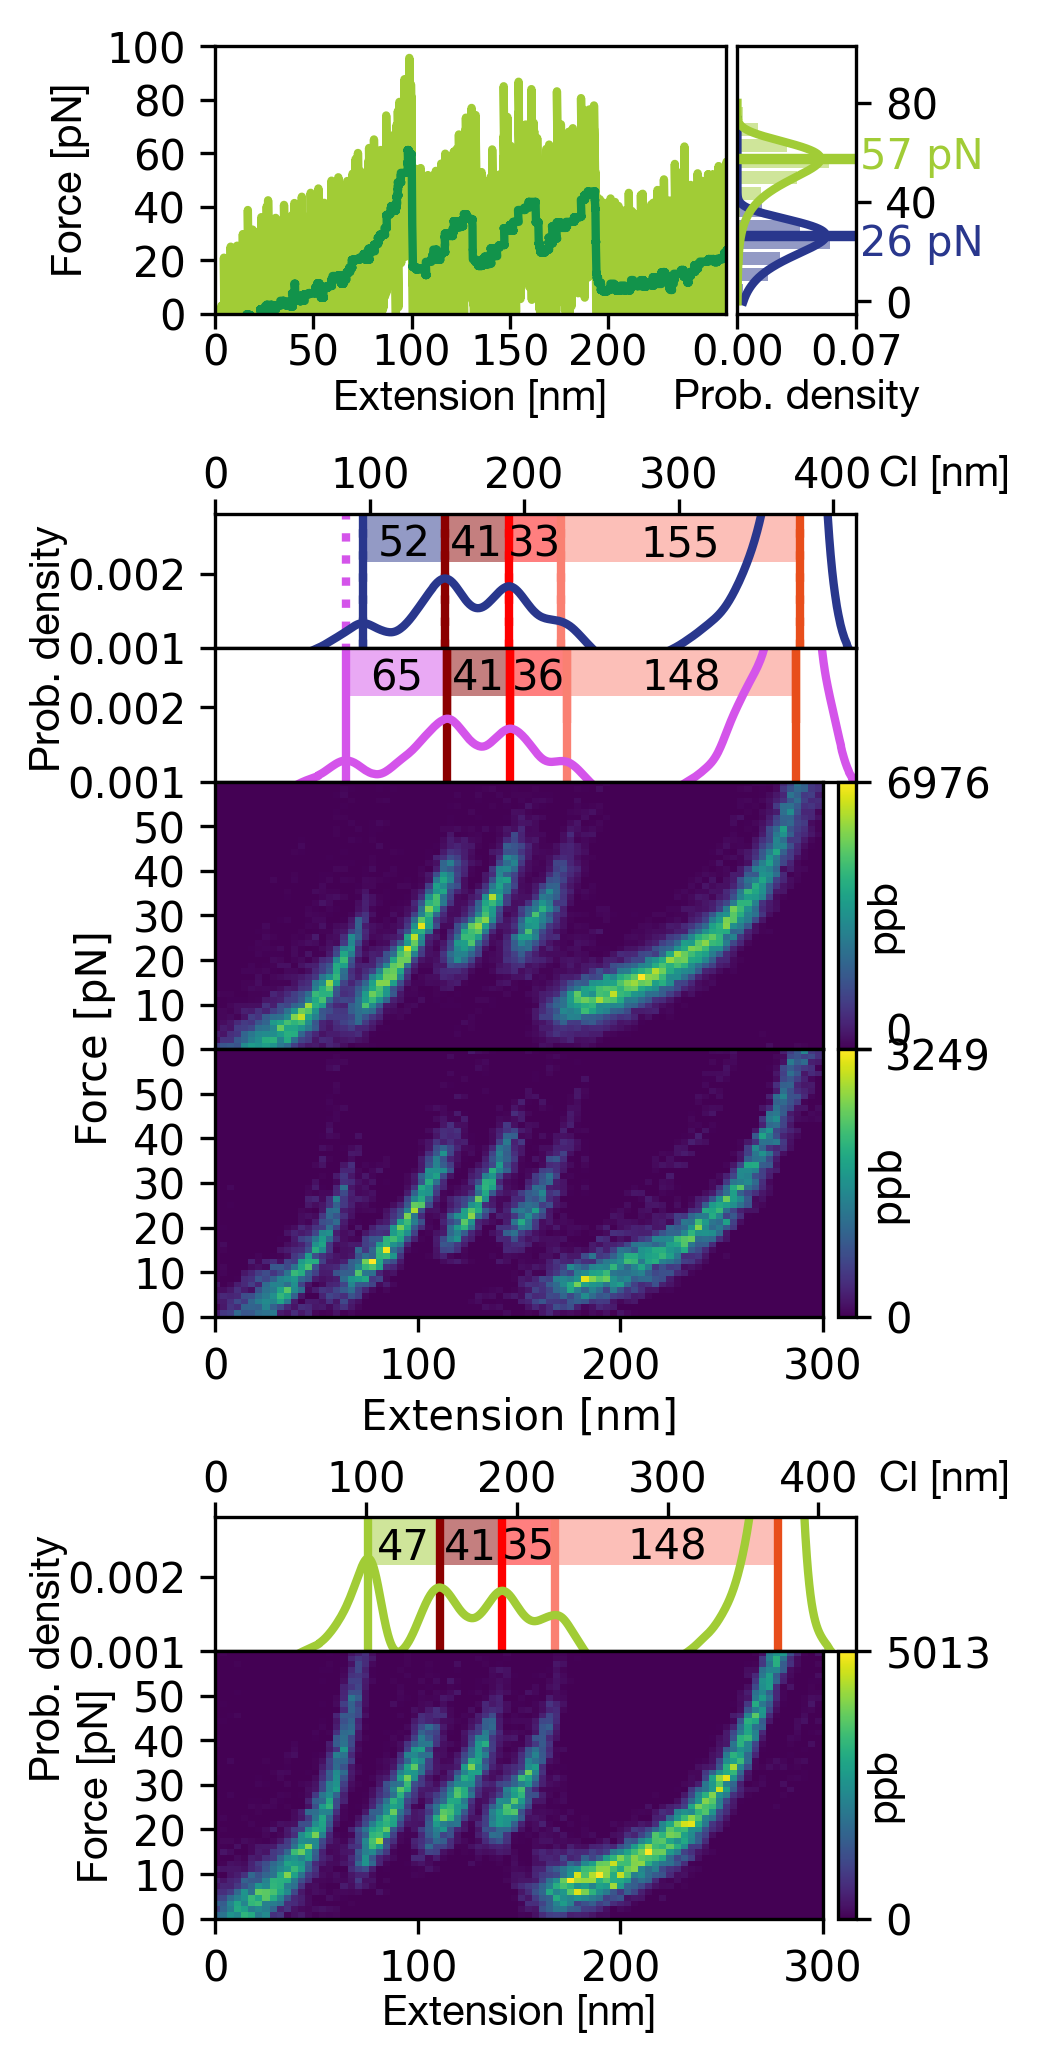

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

cm = 1/2.54  # centimeters in inches

plt.rcParams['font.family']='Helvetica Neue'
# plt.rcParams["font.weight"] = "regular"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
hfont = {'fontname':'Helvetica Neue'}

fig = plt.figure(figsize=(7*cm,21*cm), dpi=150,frameon=False)

gs_base = plt.GridSpec(10, 5, wspace=0.1,hspace=0, height_ratios=[4, 3, 2, 2, 4, 0.0, 4, 3, 2, 4])


# fig = plt.figure()
# fig.patch.set_facecolor('white')


ax0 = fig.add_subplot(gs_base[0,:-1])
ax1 = fig.add_subplot(gs_base[0,4])

ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)
ax1.set_xlabel('Prob. density', fontsize=10)

ax1.yaxis.tick_right()
    
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
ax0.set_xlabel('Extension [nm]', fontsize=10)
ax0.set_ylabel('Force [pN]', fontsize=10)
ax0.tick_params(axis='y', labelsize=10)

ax0.set_yticks([0,20,40,60,80,100])
ax0.set_xticks([0,50,100,150,200])

ax0.xaxis.labelpad = 1
ax0.tick_params(axis='x', pad=1)

ax1.xaxis.labelpad = 1
ax1.tick_params(axis='x', pad=1)
ax1.set_yticks([0,40,80])

ax0.set_xlim([-5, 300])
ax0.set_ylim([-0, 100])

data_raw = A2S2[0]['016158'][:]
ax0.plot(data_raw[:,0]*1e9,data_raw[:,1]*1e12,color=S2green,linewidth=2)
ax0.plot(data_raw[:,0]*1e9,data_raw[:,2]*1e12,color=S2greenalt,linewidth=2)
ax0.set_xlim([-0, 260])


peak_it = [b'RBD']
listofmes=[A2S1_1,A2S2]

forces = [iterate_peaks(x,peak_it,"f")*p1offs[idx] for idx,x in enumerate(listofmes) ]
loadingrates = [iterate_peaks(x,peak_it,"lr")*p1offs[idx] for idx,x in enumerate(listofmes) ]

singlecollist=[S1blue,S2green]

bins_all=np.arange(start=1, stop=100, step=6.5)*1e-12
for idx,(force,loadingrate) in enumerate(zip(forces,loadingrates)):

    pub = 0
    # delete all values with rupture forces below 0.0
    # should not exist in any case
    # curr_loading_rates = S2N501Y_lr#a[:,1]*1e-12#
    curr_loading_rates =loadingrate
    # this one last
    # curr_rup_forces = S2N501Y#ydata_#a[:,0]*1e-12#ydata2_
    curr_rup_forces = force

    fdot = curr_avg_loadrate = np.mean(curr_loading_rates[curr_loading_rates>0.0])
    curr_avg_loadrate_std = np.std(curr_loading_rates[curr_loading_rates>0.0] )

    N_ = curr_rup_forces.shape[0]

    if pub == 1:
        max_ = 200.0e-12
        binwidth = 50.0e-12 # pN, we calculate in SI
    else:
        max_ = np.max(curr_rup_forces)
        print(max_)
        if max_ > 2.0*np.mean(curr_rup_forces) : # maximum guessed too large
            max_ = 2 * np.mean(curr_rup_forces)

        # max_ = 120.0e-12
        binwidth = (int(max_*1.0e12)//20 )*1.0e-12 # we calculate in SI


    guesses = [ 0.7e-9, 0.1 ]
    ( most_probable_force, f_error_neg, f_error_pos,
            deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
            ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )

    if most_probable_force == -1 : # the fit must have failed, try again:
        guesses = [ 0.1e-9, 0.001 ]
        ( most_probable_force, f_error_neg, f_error_pos,
            deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
            ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )

        if most_probable_force == -1 : # the fit must have failed, try again:
            guesses = [ 0.05e-9, 0.00000001 ]
            ( most_probable_force, f_error_neg, f_error_pos,
                    deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
                    ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )



    koff0 = koff
    probability_density=ydata
    # width = 0.9*binwidth
    # self.dia_ax.bar( (bins-binwidth+(0.1*binwidth) )*1.0e12, probability_density*1.0e-12 , width*1.0e12, color=thiscolor,
    #     linewidth=1 , alpha=alpha*0.5)

    # binsall = bins
    nn, nbins, npatches = ax1.hist(curr_rup_forces*1.0e12, bins=bins_all*1.0e12,
         histtype='bar', rwidth=0.8 , density=True, stacked=True,
        cumulative=False, linewidth=1, color=singlecollist[idx],alpha=0.5,orientation="horizontal")


    if most_probable_force == -1.0:
        print(" BELL EVANS FIT FAILED !")
    else:
        # pass
        print("bla")
        print(bins__*1.0e12)
        ax1.plot(  bell_*1.0e-12,bins__*1.0e12,linewidth=2,color=singlecollist[idx])#, linestyle="--"
#         ax[len(forces)].plot( bins__*1.0e12, bell_*1.0e-12,linewidth=2,color=color_list[idx])#, linestyle="--"

    #
    #
    # plt.set_xlim([0.0,np.max(bins)*1.0e12])

    # print("\n\n------ [RESULTS] v=%s nm/s ------"%np.round( int(
    #          *1e9), decimals=-2)
    print(" mean loading rate +- sigma = %6.4G pN/s +- %6.4G pN/s"% (curr_avg_loadrate*1.0e12,
        curr_avg_loadrate_std*1.0e12 ))
    print(" Most probable rupture Force = %6.4G pN "%(most_probable_force*1.0e12 ))
    print(" asymmetric FWHM Errors      = -%6.4G pN  +%6.4G pN"%(f_error_neg*1.0e12,f_error_pos*1.0e12 ))
    print(" deltax = %6.4G nm\n koff0 = %6.4G s^-1"%(deltax*1.0e9, koff))
    print("\n resulting error in fit covar. matrix \n deltax +- %6.4G nm , koff0 +- %6.4G 1/s" %(
        deltax_fiterr*1.0e9, koff_fiterr*1.0e9))
    print("---------------------------------")
    ax1.axhline(most_probable_force*1.0e12,color=singlecollist[idx],linewidth=2.5)
    if idx==0:
      ax1.text(0.072,most_probable_force*1.0e12-3,str(int(most_probable_force*1.0e12))+' pN',rotation=0,va='center',color=singlecollist[idx])
    if idx==1:
      ax1.text(0.072,most_probable_force*1.0e12+1,str(int(most_probable_force*1.0e12))+' pN',rotation=0,va='center',color=singlecollist[idx])
#     ax[len(forces)].axvline(most_probable_force*1.0e12,color=color_list[idx],linewidth=2.5)

ax1.set_xticks([0, 0.07])
ax1.set_xlim([0, 0.07])

ax2 = fig.add_subplot(gs_base[1,:])
ax2.set_visible(False)


ax3 = fig.add_subplot(gs_base[2,:])
ax4 = fig.add_subplot(gs_base[3,:])

ax5 = fig.add_subplot(gs_base[4,:])


ax55 = fig.add_subplot(gs_base[5,:])
ax55.set_visible(False)
ax6 = fig.add_subplot(gs_base[6,:])

plot5=ax5.pcolormesh(A2S1_1[1][2],A2S1_1[1][1],A2S1_1[1][0], zorder=-2,rasterized=True)

bins=90 
xyrange=[[-15, 100], [-15, 300]]

xdata = np.empty(0)
ydata = np.empty(0)

for idx,i in enumerate(A2S1_long_1[0]):
    data_raw = A2S1_long_1[0][i][:]
    
    dx = A2S1_long_1[6][idx]
    
    xdata = np.append(xdata,data_raw[:,0]*1e9+dx)
    ydata = np.append(ydata,data_raw[:,2]*1e12)
    # plt.plot(xdata,ydata)
    # break

for idx,i in enumerate(A2S1_long_4[0]):
    data_raw = A2S1_long_4[0][i][:]
    
    dx = A2S1_long_4[6][idx]-25
    
    xdata = np.append(xdata,data_raw[:,0]*1e9+dx)
    ydata = np.append(ydata,data_raw[:,2]*1e12)
    # plt.plot(xdata,ydata)
    # break

# plt.ylim([0,60])
# plt.xlim([0,200])
H, xedges, yedges = np.histogram2d(ydata,xdata,range=xyrange,bins=bins)
plot6=ax6.pcolormesh(yedges,xedges,H, zorder=-2,rasterized=True)


# plot6=ax6.pcolormesh(A2S1_long_1[1][2],A2S1_long_1[1][1],A2S1_long_1[1][0], zorder=-2,rasterized=True)

divider1 = make_axes_locatable(ax5)
cax1 = divider1.append_axes("right", size="3%", pad=0.05)
cbar1 = fig.colorbar(plot5, cax = cax1)
yticks = cax1.yaxis.get_major_ticks()
cbar1.set_ticks([np.min(A2S1_1[1][0]), np.max(A2S1_1[1][0])])
cax1.tick_params(axis='y', labelsize=10)
cax1.yaxis.set_label_coords(1.5,0.5)
cax1.set_ylabel('ppb', fontsize=10)
# dx = 0/72.; dy = 10/72. 
# offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# dx = 0/72.; dy = 5/72. 
# dx = 0/72.; dy = 1.9/72. 
# offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
dx = 0/72.; dy = 5/72. 
offset2 = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# offset2 = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# label = cax1.yaxis.get_majorticklabels()[1]
# label.set_transform(label.get_transform() - offset)
label1 = cax1.yaxis.get_majorticklabels()[0]
label1.set_transform(label1.get_transform() + offset2)


divider1 = make_axes_locatable(ax6)
cax2 = divider1.append_axes("right", size="3%", pad=0.05)
cbar2 = fig.colorbar(plot6, cax = cax2)
yticks = cax2.yaxis.get_major_ticks()
cbar2.set_ticks([np.min(H), np.max(H)])
cax2.tick_params(axis='y', labelsize=10)
cax2.yaxis.set_label_coords(1.5,0.5)
cax2.set_ylabel('ppb', fontsize=10,fontweight='regular')
# cax2.yaxis.get_majorticklabels()[0].set_pad(5)
# set_pad(5)
# cax2.yaxis.get_majorticklabels()[1].set_pad(5)
dx = 0/72.; dy = 1.9/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# dx = 0/72.; dy = 5/72. 
# offset2 = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
label2 = cax2.yaxis.get_majorticklabels()[1]
label2.set_transform(label2.get_transform() - offset)
# label2 = cax2.yaxis.get_majorticklabels()[0]
# label2.set_transform(label2.get_transform() + offset2)

ax6.tick_params(axis='x', labelsize=10)
ax6.tick_params(axis='y', labelsize=10)
ax6.set_xlabel('Extension [nm]', fontsize=10,fontweight='regular',labelpad=2)
ax6.set_ylabel('Force [pN]', fontsize=10,fontweight='regular')
dx = 0/72.; dy = 35/72. 
offset3 = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
label4 = ax6.yaxis.get_label()
label4.set_transform(label4.get_transform() + offset3)

ax6.tick_params(axis='y', labelsize=10)
# ax1.set_xticks([])

ax6.set_yticks([0,10,20,30,40,50])
ax5.set_yticks([0,10,20,30,40,50])
ax5.set_xticks([])
# ax1.set_yticks(range(0, 60, 10))

ax5.set_xlim([-0, 300])
ax5.set_ylim([-0, 60])

ax6.set_xlim([-0, 300])
ax6.set_ylim([-0, 60])

ax3.xaxis.set_label_position('top') 
ax3.xaxis.tick_top()
ax3.set_xlabel('Cl [nm]', fontsize=10)
dx = 98/72.; dy = -8.3/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

label7 = ax3.xaxis.get_label()
label7.set_transform(label7.get_transform() + offset)

# for idx,liness in enumerate([popt42_1[1],popt42_2[1],popt42_3[1],popt42_t[7],popt42_5[1]]):
#     if idx == 0:
#         ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))],linewidth=2.5, color=Amber,linestyle="--", alpha=0.6)
#     else:
#         ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))],linewidth=2.5, color=Amber, alpha=0.6)
    
# for liness in [popt33_1[1],popt33_2[1],popt33_3[1],popt33_t[7],popt33_5[1]]:
#     ax2.axvline(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist33[0]))))],linewidth=2,color=Blue, alpha=0.6)

# ax2.plot(np.arange(0,451,0.1),alignhist42[1][3382+int(np.mean(alignhist42[0])):3382+int(np.mean(alignhist42[0]))+4510],linewidth=4, color=Amber)
# ax2.plot(np.arange(0,451,0.1),alignhist33[1][3382+int(np.mean(alignhist33[0])):3382+int(np.mean(alignhist33[0]))+4510],linewidth=4, color=Blue)


ax3.xaxis.set_label_position('top') 
ax3.xaxis.tick_top()
ax4.get_xaxis().set_ticks([])
# ax3.set_xlabel('Contour length [nm]', fontsize=10,fontweight='regular')#,fontweight='regular'
ax3.set_ylabel('Prob. density', fontsize=10)
ax3.yaxis.set_label_coords(-0.23, -0.00)
ax3.tick_params(axis='x', labelsize=10)
ax3.tick_params(axis='y', labelsize=10)

# ax2.set_ylim([0.0010, 0.0028])
ax3.set_xlim([-0, 415])
ax4.set_xlim([-0, 415])
ax3.xaxis.labelpad = 1
ax3.tick_params(axis='x', pad=0.5)

colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]
colors = ["dodgerblue","darkred","red","salmon",Clfa]
colors_42 = [Amber,"darkred","red","salmon",Clfa]
    
bbox = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height


colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]

for liness in [popt33_1[1],popt33_2[1],popt33_3[1],popt33_t[7],popt33_5[1]]:
    increments.append(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist33[0]))))])
    
incrementslong=[]

for liness in [popt42_1[1],popt42_2[1],popt42_3[1],popt42_t[7],popt42_5[1]]:
    incrementslong.append(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist42[0]))))])

    
ax4.plot(np.arange(0,451,0.1),alignhist42[1][3382+int(np.mean(alignhist42[0])):3382+int(np.mean(alignhist42[0]))+4510],linewidth=2, color="#D454EA")
ax3.plot(np.arange(0,451,0.1),alignhist33[1][3382+int(np.mean(alignhist33[0])):3382+int(np.mean(alignhist33[0]))+4510],linewidth=2, color=S1blue)


bbox = ax4.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height

colors = [S1blue,"darkred","red","salmon",Clfa]
colors_42 = ["#D454EA","darkred","red","salmon",Clfa]

for idx,fit in enumerate(increments):
    print (idx,fit)
    ax3.vlines(fit,color=colors[idx],ymin=0, ymax=max-2*factor*0.25,linewidth=2)
    
    ax3.vlines(fit,color=colors[idx],ymin=0.0010, ymax=0.0028,linewidth=2,linestyle=":")
    ax3.vlines(fit,color=colors[idx],ymin=max-2*factor*0.25, ymax=max,linewidth=2)
    
    if idx == 0:
        ax3.vlines(incrementslong[idx],color=colors_42[idx],linestyle=":",ymin=0.00095, ymax=0.0028,linewidth=2)
        ax4.vlines(incrementslong[idx],color=colors_42[idx],ymin=0, ymax=max,linewidth=2)
    else:
        ax4.vlines(incrementslong[idx],color=colors_42[idx],ymin=0, ymax=max,linewidth=2)
        ax4.vlines(incrementslong[idx],color=colors_42[idx],ymin=max-factor*0.25, ymax=max,linewidth=2)
        
    if idx == len(increments)-1:
        break
        
    ax3.annotate(int(increments[idx+1]-fit), xy=(fit+(increments[idx+1]-fit)/2, max-(max-min)/3.2), xycoords='data',color='black', ha='center',fontweight='regular', fontsize=10)
    ax4.annotate(int(incrementslong[idx+1]-incrementslong[idx]), xy=(incrementslong[idx]+(incrementslong[idx+1]-incrementslong[idx])/2, max-(max-min)/3.2), xycoords='data',color='black', ha='center',fontweight='regular', fontsize=10)
#     if idx != 0:
#         ax2.annotate(int(bfits[idx+1]-fit), xy=(fit+(bfits[idx+1]-fit)/2, 0.14-((0.378048780488*(ax1h/height))/1.4)), xycoords='data',color='white', ha='center',fontweight='regular', fontsize=16)
    rect1 = matplotlib.patches.Rectangle((fit,max-factor*0.16), increments[idx+1]-fit, factor*0.25, color=colors[idx], alpha = 0.5,linewidth=0)
    ax3.add_patch(rect1)
    
    rect2 = matplotlib.patches.Rectangle((incrementslong[idx],max-factor*0.16), incrementslong[idx+1]-incrementslong[idx], factor*0.25, color=colors_42[idx], alpha = 0.5,linewidth=0)
    ax4.add_patch(rect2)

ax3.set_ylim([0.0010, 0.0028])
ax4.set_ylim([0.0010, 0.0028])



ax7 = fig.add_subplot(gs_base[7,:])
ax7.set_visible(False)


ax8 = fig.add_subplot(gs_base[8,:])
ax9 = fig.add_subplot(gs_base[9,:])


plot9 = ax9.pcolormesh(A2S2[1][2],A2S2[1][1],A2S2[1][0], zorder=-2,rasterized=True)

divider1 = make_axes_locatable(ax9)
cax1 = divider1.append_axes("right", size="3%", pad=0.05)
cbar1 = fig.colorbar(plot9, cax = cax1)
yticks = cax1.yaxis.get_major_ticks()
cbar1.set_ticks([np.min(A2S2[1][0]), np.max(A2S2[1][0])])
cax1.tick_params(axis='y', labelsize=10)
cax1.yaxis.set_label_coords(1.5,0.5)
cax1.set_ylabel('ppb', fontsize=10)
# dx = 0/72.; dy = 10/72. 
# offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# dx = 0/72.; dy = 5/72. 
# offset2 = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# dx = 0/72.; dy = 1.9/72. 
# offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# dx = 0/72.; dy = 5/72. 
# offset2 = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# label5 = cax1.yaxis.get_majorticklabels()[1]
# label5.set_transform(label5.get_transform() - offset)
# label6 = cax1.yaxis.get_majorticklabels()[0]
# label6.set_transform(label6.get_transform() + offset2)


ax9.tick_params(axis='x', labelsize=10)
ax9.tick_params(axis='y', labelsize=10)
ax9.set_xlabel('Extension [nm]', fontsize=10)
ax9.set_ylabel('Force [pN]', fontsize=10)
ax9.tick_params(axis='y', labelsize=10)
# ax1.set_xticks([])

ax9.set_yticks([0,10,20,30,40,50])

ax9.set_xlim([-0, 300])
ax9.set_ylim([-0, 60])

ax8.xaxis.set_label_position('top') 
ax8.xaxis.tick_top()
ax8.set_xlabel('Cl [nm]', fontsize=10)
dx = 98/72.; dy = -11.55/72. 
offset3 = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

label3 = ax8.xaxis.get_label()
label3.set_transform(label3.get_transform() + offset3)

ax8.set_ylabel('Prob. density', fontsize=10)
ax8.yaxis.set_label_coords(-0.23, -0.05)
ax8.tick_params(axis='x', labelsize=10)
ax8.tick_params(axis='y', labelsize=10)

# ax2.set_ylim([0.0010, 0.0028])
ax8.set_xlim([-20, 400])
ax9.xaxis.labelpad = 1
ax8.tick_params(axis='x', pad=0.5)
# ax3.set_xlim([0, 410])


colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]
colors = ["dodgerblue","darkred","red","salmon",Clfa]
colors_42 = [Amber,"darkred","red","salmon",Clfa]


    
bbox = ax8.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height

colors = ["dodgerblue","darkred","red",(float(237.0/255.0),float(114.0/255.0),float(24.0/255.0))]
bfits=[]

names = ["RBD","ACE2_1","ACE2_2","ACE2_3","ClfA"]

increments=[]

for liness in [poptS2_1[1],poptS2_2[1],poptS2_3[1],poptS2_4[1],poptS2_5[1]]:
    increments.append(np.arange(0,451,0.1)[int(liness-(3382+int(np.mean(alignhist_S2[0]))))])
    
    
bbox = ax8.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height

max=0.0028
min=0.001

factor=(max-min)/height

colors = [S2green,"darkred","red","salmon",Clfa]

for idx,fit in enumerate(increments):
    print (idx,fit)
    ax8.vlines(fit,color=colors[idx],ymin=0, ymax=max,linewidth=2)
        
    if idx == len(increments)-1:
        break
        
    ax8.annotate(int(increments[idx+1]-fit), xy=(fit+(increments[idx+1]-fit)/2, max-(max-min)/3.2), xycoords='data',color='black', ha='center', fontsize=10)

#     if idx != 0:
#         ax2.annotate(int(bfits[idx+1]-fit), xy=(fit+(bfits[idx+1]-fit)/2, 0.14-((0.378048780488*(ax1h/height))/1.4)), xycoords='data',color='white', ha='center',fontweight='regular', fontsize=16)
    rect1 = matplotlib.patches.Rectangle((fit,max-factor*0.16), increments[idx+1]-fit, factor*0.25, color=colors[idx], alpha = 0.5,linewidth=0)
    ax8.add_patch(rect1)

ax8.set_ylim([0.0010, 0.0028])
ax8.set_xlim([0, 425])


ax8.plot(np.arange(0,451,0.1),alignhist_S2[1][3382+int(np.mean(alignhist_S2[0])):3382+int(np.mean(alignhist_S2[0]))+4510], color=S2green,linewidth=2)

plt.xticks(**hfont)
plt.yticks(**hfont)
plt.savefig('Figure2.pdf',bbox_inches = "tight", dpi=600,transparent=True)#114 167 195 228 373

In [ ]:
print(fontpath)

/usr/share/fonts/HelveticaNeue/HelveticaNeue-UltraLightItalic.ttf


In [ ]:
!git clone https://github.com/ElectricEasel/shindaiwacordless.git

fatal: destination path 'shindaiwacordless' already exists and is not an empty directory.


In [ ]:
!cp -r /content/shindaiwacordless/fonts/HelveticaNeue /usr/share/fonts

In [ ]:
# Install font packages, alternative fonts: fonts-arphic-uming fonts-moe-standard-song
# ! apt-get install -y fonts-noto-cjk

# Optional: check to make sure the fonts are available after install
! fc-list :lang=en

# Find fonts from system path and add to matplotlib
import matplotlib.font_manager as fm
for fontpath in fm.findSystemFonts():   # optionally provide arg: fontpaths=['/path/to/fonts']
    fm.fontManager.addfont(fontpath)

/usr/share/fonts/TTF/HelveticaNeue/HelveticaNeueRegular.ttf: Helvetica Neue:style=Regular,標準體,Ordinær,Normal,Normaali,Regolare,レギュラー,일반체,Regulier,Обычный,常规体,عادي
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc: Noto Serif CJK SC:style=Bold
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc: Noto Serif CJK TC:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc: Noto Serif CJK JP:style=Bold
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc: Noto Serif CJK KR:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc: Noto Sans CJK JP:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc: Noto Sans CJK HK:style=Regular
/usr/share/fonts/opentype/no

In [ ]:
print("\n".join(sorted(set([f.name for f in fm.fontManager.ttflist]))))

DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif Display
Helvetica Neue
Helvetica Neue LT Std
Humor Sans
Liberation Mono
Liberation Sans
Liberation Sans Narrow
Liberation Serif
Noto Sans CJK JP
Noto Serif CJK JP
STIXGeneral
STIXNonUnicode
STIXSizeFiveSym
STIXSizeFourSym
STIXSizeOneSym
STIXSizeThreeSym
STIXSizeTwoSym
cmb10
cmex10
cmmi10
cmr10
cmss10
cmsy10
cmtt10


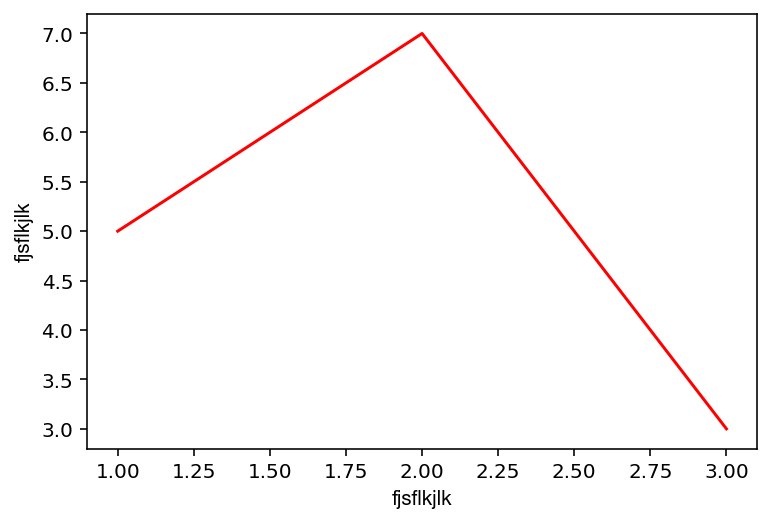

In [ ]:
# plt.rcParams['font.family']='Helvetica Neue'
plt.plot([1,2,3], [5,7,3], 'r')
plt.ylabel('fjsflkjlk')
plt.xlabel('fjsflkjlk')
plt.savefig("testplot.pdf")

In [ ]:
from matplotlib import font_manager as fm, pyplot as plt

# Pick up any fonts in the current directory.
# If you do end up downloading the fonts to /usr/share/fonts/truetype,
# change this to: fm.findSystemFonts()
font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Use your new font on all your plots.
plt.rc('font', family='Helvetica Neue')

In [ ]:
!fc-cache -fv 

/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/TTF: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/TTF/HelveticaNeue: caching, new cache contents: 3 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 28 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
!rm -fr ~/.cache/matplotlib 

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fetch the name of font that was installed
path = '/usr/share/fonts/truetype/HelveticaNeue-Regular.otf'
fontprop = fm.FontProperties(fname=path)

In [ ]:
import matplotlib.font_manager as mfm
mfm.findSystemFonts()

In [ ]:
%matplotlib inline  

# import matplotlib packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# install font
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# display installed nanum font list
sys_font=fm.findSystemFonts()
nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")
print("\n".join(nanum_font))

# refresh font list, so that Matplotlib font manager knows them.
fm._rebuild()

In [ ]:
from matplotlib import font_manager

font_dirs = ["/resources/fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fetch the name of font that was installed
path = '/usr/share/fonts/HelveticaNeue/HelveticaNeueRegular.ttf'
fontprop = fm.FontProperties(fname=path)

path = '/usr/share/fonts/HelveticaNeue/HelveticaNeueLight.ttf'
fontprop = fm.FontProperties(fname=path)

path = '/usr/share/fonts/HelveticaNeue/HelveticaNeueBold.ttf'
fontprop = fm.FontProperties(fname=path)

In [ ]:
!git clone https://github.com/ElectricEasel/shindaiwacordless.git

Cloning into 'shindaiwacordless'...
remote: Enumerating objects: 797, done.
remote: Total 797 (delta 0), reused 0 (delta 0), pack-reused 797
Receiving objects: 100% (797/797), 11.09 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (290/290), done.


In [ ]:
!cp -r /content/shindaiwacordless/fonts/HelveticaNeue /usr/share/fonts

In [ ]:
!cp -r /content/shindaiwacordless/fonts/HelveticaNeue /usr/share/fonts/truetype/

In [ ]:
!cp -r /content/shindaiwacordless/fonts/HelveticaNeue/* /usr/share/fonts/truetype/

In [ ]:
!rm -r /usr/share/fonts/HelveticaNeue/

In [ ]:
!fc-cache -fv 

/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/TTF: caching, new cache contents: 3 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 28 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/var/cache/fontconfig: invalid cache file: 5924e4955bc196c4b80a15b25f809515-le64.cache-7
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
!rm -fr ~/.cache/matplotlib

In [ ]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('/usr/share/fonts/HelveticaNeue/HelveticaNeueRegular.ttf')
mpl.rc('font', family='Helvetica Neue')

FileNotFoundError: ignored

In [ ]:
forcesRBD=iterate_peaks(A2S2_dyn_800,[b'RBD'],"f")

In [ ]:
print(forcesRBD)

[4.59993089e-11 6.06890673e-11 5.39236712e-11 3.11055766e-11
 4.69029090e-11 5.42287214e-11 4.73019747e-11 6.31175573e-11
 5.48595888e-11 5.21378092e-11 4.26103254e-11 3.43338776e-11
 4.34094349e-11 5.35642534e-11 4.99452316e-11 3.69825436e-11
 4.35679612e-11 4.41340148e-11 4.37820433e-11 5.21156338e-11
 4.51371903e-11 4.18090809e-11 4.27007188e-11 4.85350569e-11
 5.13649456e-11 4.17271134e-11 3.51812900e-11 4.80500099e-11
 7.84411489e-11 5.01315078e-11 4.20590605e-11 4.39150424e-11
 3.78558877e-11 5.90697776e-11 5.03667566e-11 2.59942741e-11
 4.55547597e-11 5.58323173e-11 3.39714457e-11 4.09274850e-11
 4.45452202e-11 5.79152155e-11 5.65838037e-11 3.26402313e-11
 3.35671917e-11 4.93456397e-11 2.95797597e-11 3.40722179e-11
 3.66037826e-11 4.74747592e-11 3.65398141e-11 3.93080619e-11
 4.83487556e-11 2.94863337e-11 2.76821227e-11 4.43916727e-11
 5.00311723e-11 3.63169685e-11]


(array([ 5.,  7.,  7., 15., 13.,  6.,  3.,  1.,  0.,  1.]),
 array([2.59942741e-11, 3.12389615e-11, 3.64836490e-11, 4.17283365e-11,
        4.69730240e-11, 5.22177115e-11, 5.74623990e-11, 6.27070865e-11,
        6.79517739e-11, 7.31964614e-11, 7.84411489e-11]),
 <a list of 10 Patch objects>)

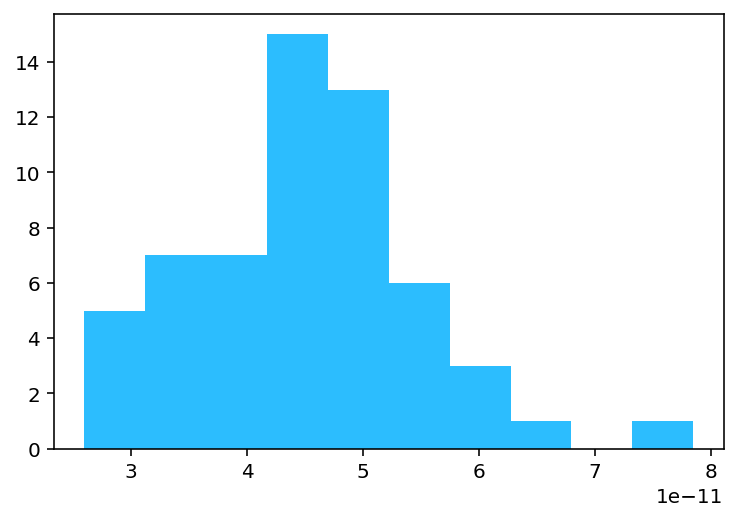

In [ ]:
plt.hist(forcesRBD)

In [ ]:
peaks=[b'RBD']
curves=A2S1_1[0]
peak_lbl=A2S1_1[5]
peak_data=A2S1_1[2]
for i,peak in enumerate(peaks):

    ydata = np.empty(0)
    for idx, curve in enumerate(curves):
        # print(curve)
        # print(peak_lbl[curve][:])
        if np.where(peak_lbl[curve][:]==peak)[0].size == 0:
            continue
        ydata = np.append(ydata,peak_data[curve][:][np.where(peak_lbl[curve][:]==peak)[0][0]][2])
    
    # ydata = ydata*1e12
    # ydata = ydata[ np.where( ydata > 5 ) ] 
    # ydata = ydata[ np.where( ydata < 190 ) ] 
    
    # filtered = ydata

In [ ]:
f=ydata

In [ ]:
peaks=[b'RBD']
for i,peak in enumerate(peaks):

    xdata = np.empty(0)
    for idx, curve in enumerate(curves):
        # print(curve)
        # print(peak_lbl[curve][:])
        if np.where(peak_lbl[curve][:]==peak)[0].size == 0:
            continue
        xdata = np.append(ydata,peak_data[curve][:][np.where(peak_lbl[curve][:]==peak)[0][0]][5])
    
    # xdata = xdata*1e9
    # ydata = ydata[ np.where( ydata > 5 ) ] 
    # ydata = ydata[ np.where( ydata < 190 ) ] 
    
    # filtered = ydata

In [ ]:
lr=xdata

In [ ]:
xdata

array([1.66814941e-11, 2.62877959e-11, 1.34351739e-11, 2.28399504e-11,
       2.68415658e-11, 2.25331704e-11, 2.61561147e-11, 2.26700155e-11,
       2.34578015e-11, 8.76443788e-12, 1.00943765e-11, 2.46887952e-11,
       1.08640274e-11, 1.33907781e-11, 2.89157586e-11, 2.02137605e-11,
       1.29694805e-11, 1.57656091e-11, 2.85013197e-11, 2.54599675e-11,
       2.22751947e-11, 3.38047244e-11, 3.10961773e-11, 3.42084163e-11,
       2.54207501e-11, 2.83526942e-11, 1.93665898e-11, 1.73038118e-11,
       2.28815288e-11, 2.83342451e-11, 2.03344358e-11, 1.61981453e-11,
       8.20852878e-12, 2.08481266e-11, 2.48448897e-11, 2.60421374e-11,
       3.34456806e-11, 1.05958955e-11, 3.03041490e-11, 6.85200237e-12,
       2.04199254e-11, 2.82324216e-11, 2.88356468e-11, 2.26486481e-11,
       2.57637216e-11, 2.84636513e-11, 2.31956767e-11, 3.47718214e-11,
       2.37001635e-11, 1.81014764e-11, 2.37904234e-11, 2.82049880e-11,
       8.07465558e-12, 2.57103822e-11, 1.65814062e-11, 1.23509297e-11,
      

(array([10., 18., 32., 44., 24.,  0.,  0.,  0.,  0.,  2.]),
 array([0.00424189, 0.0107594 , 0.0172769 , 0.02379441, 0.03031191,
        0.03682942, 0.04334692, 0.04986443, 0.05638193, 0.06289944,
        0.06941694]),
 <a list of 10 Patch objects>)

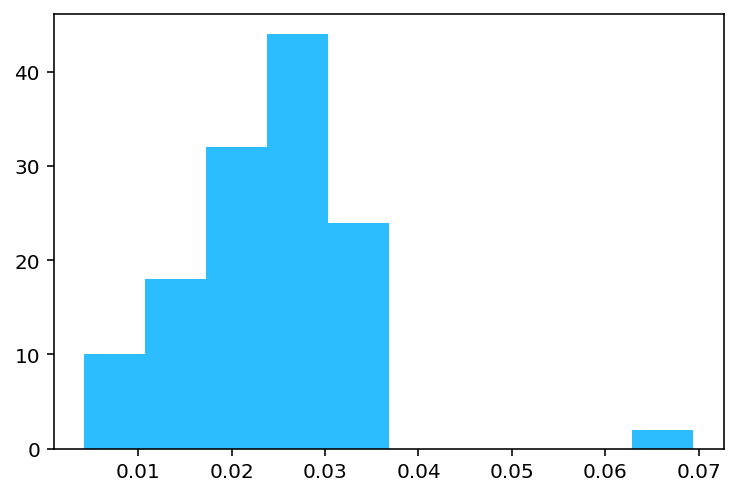

In [ ]:
plt.hist(xdata[:-1]*1e9)

In [ ]:
np.mean(ydata)

2.4194485724571423e-11

(array([11., 23., 44., 34., 16.,  0.,  0.,  0.,  2.]),
 array([4.24189349e-12, 1.14835658e-11, 1.87252381e-11, 2.59669104e-11,
        3.32085827e-11, 4.04502550e-11, 4.76919273e-11, 5.49335996e-11,
        6.21752719e-11, 6.94169442e-11]),
 <a list of 9 Patch objects>)

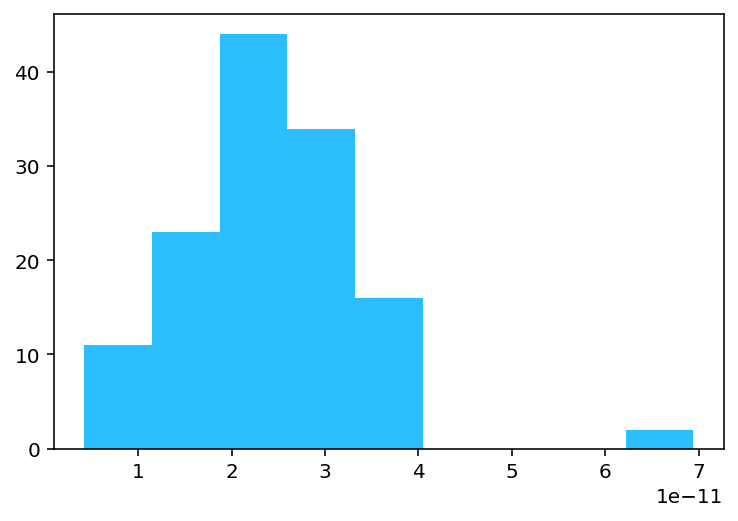

In [ ]:
plt.hist(ydata, bins=9)

In [ ]:
np.mean(ydata)

2.4194485724571423e-11

In [ ]:
kT=4.14194556e-21

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
Violet="#ff0091"

6.941694417527704e-11
bla
[0.00000e+00 1.25000e-02 2.50000e-02 ... 7.13875e+01 7.14000e+01
 7.14125e+01]
 mean loading rate +- sigma =  37.68 pN/s +-    154 pN/s
 Most probable rupture Force =  26.54 pN 
 asymmetric FWHM Errors      = - 10.52 pN  + 7.101 pN
 deltax = 0.5744 nm
 koff0 = 0.1318 s^-1

 resulting error in fit covar. matrix 
 deltax +- 0.04643 nm , koff0 +- 3.338E+07 1/s
---------------------------------


([<matplotlib.axis.XTick at 0x7fbbd7ec66d0>,
 <a list of 5 Text major ticklabel objects>)

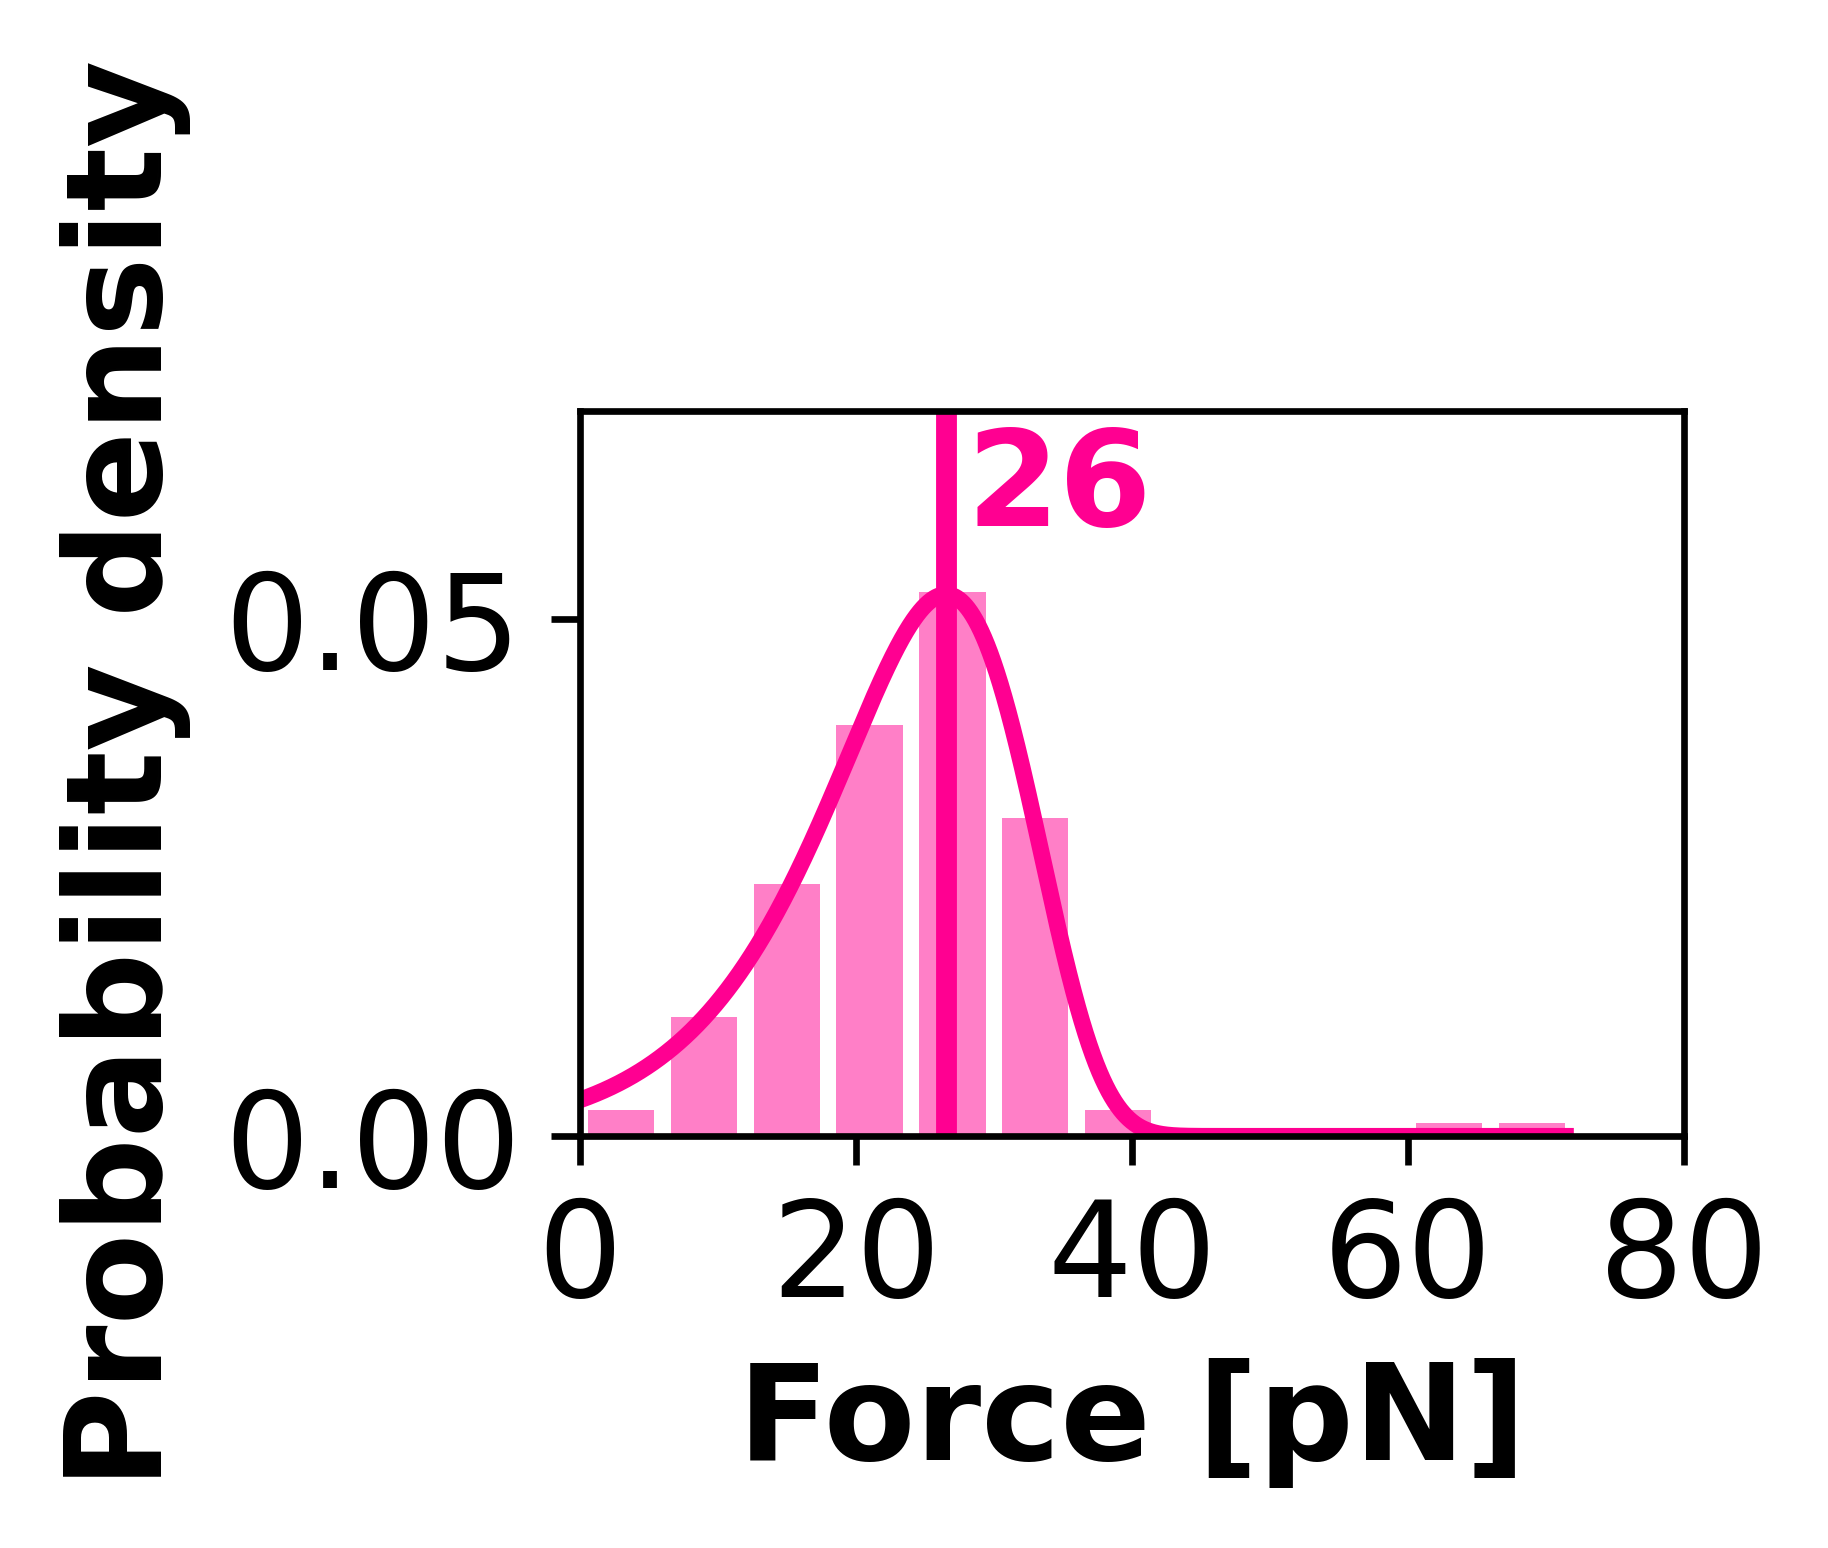

In [ ]:
plt.figure(figsize=(2.375, 1.6), dpi=300)

pub = 0
# delete all values with rupture forces below 0.0
# should not exist in any case
# curr_loading_rates = S2N501Y_lr#a[:,1]*1e-12#
curr_loading_rates =lr
# this one last
# curr_rup_forces = S2N501Y#ydata_#a[:,0]*1e-12#ydata2_
curr_rup_forces = f

fdot = curr_avg_loadrate = np.mean(curr_loading_rates[curr_loading_rates>0.0])
curr_avg_loadrate_std = np.std(curr_loading_rates[curr_loading_rates>0.0] )

N_ = curr_rup_forces.shape[0]

if pub == 1:
    max_ = 200.0e-12
    binwidth = 50.0e-12 # pN, we calculate in SI
else:
    max_ = np.max(curr_rup_forces)
    print(max_)
    if max_ > 2.0*np.mean(curr_rup_forces) : # maximum guessed too large
        max_ = 1.5 * np.mean(curr_rup_forces)

    # max_ = 120.0e-12
    binwidth = (int(max_*1.0e12)//20 )*1.0e-12 # we calculate in SI


guesses = [ 0.7e-9, 0.1 ]
( most_probable_force, f_error_neg, f_error_pos,
        deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
        ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )

if most_probable_force == -1 : # the fit must have failed, try again:
    guesses = [ 0.1e-9, 0.001 ]
    ( most_probable_force, f_error_neg, f_error_pos,
        deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
        ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )

    if most_probable_force == -1 : # the fit must have failed, try again:
        guesses = [ 0.05e-9, 0.00000001 ]
        ( most_probable_force, f_error_neg, f_error_pos,
                deltax, deltax_fiterr, koff, koff_fiterr , bins, xdata,
                ydata, bins__, bell_)  = fit_be_deltax_koff( fdot, curr_rup_forces, kT, binwidth, guesses, -1.0 )



koff0 = koff
probability_density=ydata
# width = 0.9*binwidth
# self.dia_ax.bar( (bins-binwidth+(0.1*binwidth) )*1.0e12, probability_density*1.0e-12 , width*1.0e12, color=thiscolor,
#     linewidth=1 , alpha=alpha*0.5)

# binsall = bins
nn, nbins, npatches = plt.hist(curr_rup_forces*1.0e12, bins=bins_all*1.0e12,
     histtype='bar', rwidth=0.8 , density=True,
    cumulative=False, linewidth=1, color=Violet,alpha=0.5)

if most_probable_force == -1.0:
    print(" BELL EVANS FIT FAILED !")
else:
    # pass
    print("bla")
    print(bins__*1.0e12)
    plt.plot( bins__*1.0e12, bell_*1.0e-12,linewidth=2,color=Violet)#, linestyle="--"

#
#
# plt.set_xlim([0.0,np.max(bins)*1.0e12])

# print("\n\n------ [RESULTS] v=%s nm/s ------"%np.round( int(
#          *1e9), decimals=-2)
print(" mean loading rate +- sigma = %6.4G pN/s +- %6.4G pN/s"% (curr_avg_loadrate*1.0e12,
    curr_avg_loadrate_std*1.0e12 ))
print(" Most probable rupture Force = %6.4G pN "%(most_probable_force*1.0e12 ))
print(" asymmetric FWHM Errors      = -%6.4G pN  +%6.4G pN"%(f_error_neg*1.0e12,f_error_pos*1.0e12 ))
print(" deltax = %6.4G nm\n koff0 = %6.4G s^-1"%(deltax*1.0e9, koff))
print("\n resulting error in fit covar. matrix \n deltax +- %6.4G nm , koff0 +- %6.4G 1/s" %(
    deltax_fiterr*1.0e9, koff_fiterr*1.0e9))
print("---------------------------------")
plt.axvline(most_probable_force*1.0e12,color=Violet,label="ACE2-85aa-SARS-CoV-2",linewidth=2.5)
plt.text(most_probable_force*1.0e12+1.5, .059, int(most_probable_force*1.0e12),color=Violet,fontsize=16,fontweight='bold')


plt.xlabel('Force [pN]',fontsize=16,fontweight='bold')
plt.ylabel('Probability density',fontsize=16,fontweight='bold')
# plt.legend(loc='upper right',
#           fancybox=True, shadow=True,  prop={'size': 13})#, bbox_to_anchor=(0.4, -0.45), ncol=5,
plt.xlim([0,80])
plt.ylim([0,0.07])

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xticks([0,20,40,60,80])

In [ ]:
for i in wlc_data:
  print(wlc_data[i][:])

NameError: ignored

In [ ]:
for i in peak_data:
  print(peak_data[i][:])

[[1.46399118e-07 4.62108603e-11 3.05000330e-11 5.55208751e-12
  9.17600000e+03 2.12083212e-09 2.00000000e-07]
 [1.36538517e-07 4.66923605e-11 4.46600011e-11 2.36881044e-11
  8.56000000e+03 5.76857892e-10 1.81000000e-07]
 [1.06095592e-07 4.43691222e-11 4.09625380e-11 2.09337217e-11
  6.65600000e+03 0.00000000e+00 1.36000000e-07]
 [4.14068609e-08 3.91689203e-11 1.66814941e-11 4.64160819e-12
  2.61000000e+03 1.15751461e-09 1.90000000e-07]]
[[1.72574268e-07 5.24995448e-11 3.92535371e-11 3.73100284e-11
  1.08150000e+04 4.85725821e-10 2.40000000e-07]
 [1.44940295e-07 5.78554091e-11 4.59461466e-11 5.81925028e-12
  9.09100000e+03 2.13340976e-09 2.00000000e-07]
 [1.15048088e-07 4.61687928e-11 4.02145551e-11 1.72791952e-11
  7.21600000e+03 1.42053444e-09 1.62000000e-07]
 [6.68892617e-08 2.52387971e-11 2.62877959e-11 1.67204184e-11
  4.19400000e+03 1.03804100e-09 1.52000000e-07]]
[[1.37726490e-07 5.51666157e-11 4.60633767e-11 2.34961140e-11
  8.64000000e+03 2.68406381e-09 1.86000000e-07]]
[[1.905